In [1]:
%load_ext Cython

## 1. Main codes

In [3]:
%%cython --annotate

from scipy.sparse import csr_matrix, find
from collections import defaultdict

import pandas as pd

import numpy as np

from random import choice

from math import log, ceil

def BinScale(D,val):
    """
    This binary scaling function takes genotype matrix and transforms
    it to the context w.r.t. the value val
    """
    R=np.copy(D)
  
    for i in range(D.shape[0]):
        for j in range(D.shape[1]):
            if D[i][j]!=val:
                R[i][j]=0
            else:
                R[i][j]=1
                
            
    return R 

def OnlineOABic(D):
    """
    Oline biclustering function for a given context D
    """

    S = csr_matrix(D)
    Ind=find(S)

    ObjP=defaultdict(list)
    AttrP=defaultdict(list)
    BiclS=[]

    for i in range(len(Ind[2])):
        AttrP[Ind[1][i]].append(Ind[0][i])
        ObjP[Ind[0][i]].append(Ind[1][i])
        BiclS.append((Ind[0][i],Ind[1][i],AttrP[Ind[1][i]],ObjP[Ind[0][i]]))

    return BiclS


def OnlineOABicRS(D, RS):
    """
    Oline biclustering function for a given context D with rs identifiers
    """

    S = csr_matrix(D)
    Ind=find(S)

    ObjP=defaultdict(list)
    AttrP=defaultdict(list)
    BiclS=[]

    for i in range(len(Ind[2])):
        ObjP[Ind[0][i]].append(Ind[1][i])
        if Ind[1][i] in RS:
            AttrP[Ind[1][i]].append(Ind[0][i])
            BiclS.append((Ind[0][i],Ind[1][i],AttrP[Ind[1][i]],ObjP[Ind[0][i]]))

    return BiclS


def Density2(S,b):
    """
    Returns bicluster density for a given pair (S,b),
    i.e. bicluster b within context/matrix S
    """
    
    num=0
    num=np.count_nonzero(S[b[0],:][:,b[1]])

    return num/(len(b[0])*len(b[1]))



def ED_Density(S,b,e,d):
    """
    This is an epsilon delta approximator for
    an OA-bicluster b density computation
    within contrxt/matrix S
    """
    
    n=ceil(log(2/(1-d))/(2*e**2))
    
    
    
    #print("n=",n)
    
    lext=len(b[2])
    lint=len(b[3])
    
    if n>=lext*lint:
        return Density2(S,b[2:])
        
    
    num=lext+lint
    
    #print("num=",num)
    
    cells=[]
    
    ones=0
    
    while len(cells)<n:
        g=choice(b[2])
        m=choice(b[3])
        if g!=b[0] and m!=b[1] and (g,m) not in cells:
            cells.append((g,m))
            ones+=S[g,m]
    
    #print("ones=", ones)
    #print("len(cells)", len(cells))
    
    num=num+ones/n* (lext-1)*(lint-1)
    
    return num/(lext*lint)
    
    
    

def Purity(ext,Pos):
    """
    Purity with respect to positive class objects Pos (or negative)
    and extent of a bicluster or concept 
    """
    num=0
    for i in Pos:
        if i in ext:
            num+=1
    
    lex=len(ext)
    
    return max(num/lex, (lex-num)/lex)

def biclPurArr(Bicl,Pos):
    """
    Purity dictionary for a collection of biclusters 
    """
    pur={}
    for i in range(len(Bicl)):
        pur[Bicl[i][:2]]=(Purity(Bicl[i][2],Pos))
        if i%100==0: print(i)
    return pur
    

def biclDenLenArr(S,Bicl,ids):
    """
    Density dictionary for a collection of biclusters 
    """
    den={}
    for i in ids:
        den[Bicl[i][:2]]=(Density2(S,Bicl[i][2:]), len(Bicl[i][2]),len(Bicl[i][3]))
        if i%100==0: print(i)
    return den

def biclDicGlue(dic1, dic2):
    """
    Dictionary gluestick
    """
    dic={}
    for key in dic1:
        dic[key]=dic1[key]+(dic2[key],)
    
    return dic

def Selection(Bicl_stat, density_min, density_max, ext_min, ext_max, int_min, int_max):
    """
    Density-size selection operator for a bicluter statistics structure
    """
    Sel=[]
    for triple in range(len(Bicl_stat)):

        if Bicl_stat[triple][0]>=density_min and Bicl_stat[triple][0]<=density_max and Bicl_stat[triple][1]>=ext_min and Bicl_stat[triple][1]<=ext_max and Bicl_stat[triple][2]>=int_min and Bicl_stat[triple][2]<=int_max:
            Sel.append(Bicl_stat[triple])
    return Sel   

def SelectionD(dicBic, density_min, density_max, ext_min, ext_max, int_min, int_max):
    """
    Density-size selection operator for a bicluter dictionary
    """
    Sel={}
    for key in dicBic.keys():

        if dicBic[key][0]>=density_min and dicBic[key][0]<=density_max and dicBic[key][1]>=ext_min and dicBic[key][1]<=ext_max and dicBic[key][2]>=int_min and dicBic[key][2]<=int_max:
            Sel[key]=dicBic[key]
    return Sel   

def FindBic(Bicl, key):
    """
    Find a bicluster by key
    """
    for t in range(len(Bicl)):
        if Bicl[t][0]==key[0] and Bicl[t][1]==key[1]:
       
            return (Bicl[t][2],Bicl[t][3])


def SNPswithinBiclBySupp(Bic, D):
    """
    Support of SNPs within a bicluster and an input context
    """
    SNPs={}
    for s in Bic[1]:
        for i in Bic[0]:
            if s in SNPs.keys():
                SNPs[s]+=D[i,s]
            else:
                SNPs[s]=D[i,s]
        SNPs[s]=(SNPs[s],SNPs[s]/len(Bic[0]))
       
    return SNPs


def ED_exp(D,Bicls):
    """
    A full experiment dictionary with the epsilon-delta approximator
    for a context D and a collection of its biclusters
    """
    expd={}
    cnt=0
    for b in Bicls:
        dens=Density2(D, b[2:])
        for e in np.arange(0.05,0.55,0.05):
            for d in np.arange(0.5,1.0,0.05):
                if abs(ED_Density(D,b,e,d)-dens)<=e: 
                    if (e,d) in expd.keys():
                        expd[(e,d)]+=1
                    else:
                        expd[(e,d)]=1
                else:
                    if (e,d) in expd.keys():
                        pass
                    else:
                        expd[(e,d)]=0
        cnt+=1
        if cnt%10==0: print(cnt)
            
    lB=len(Bicls)                    
    for k in expd.keys():
        expd[k]=expd[k]/lB

    
    return expd

def PrintExpTable(expd):
    """
    Returns an experiment table as a dictionary
    """
    
    res=np.zeros((10,10))
    for key in expd.keys():
        res[int((key[0]-0.05)/0.05),int((key[1]-0.5)/0.05)]=expd[key]
    return res
        

/Users/machine1/.ipython/cython/_cython_magic_c7798c6790aa4d8bc3696786f42cd98d.c:8551:21: warning: fallthrough annotation in unreachable code [-Wunreachable-code-fallthrough]
                    CYTHON_FALLTHROUGH;
                    ^
/Users/machine1/.ipython/cython/_cython_magic_c7798c6790aa4d8bc3696786f42cd98d.c:293:34: note: expanded from macro 'CYTHON_FALLTHROUGH'
      #define CYTHON_FALLTHROUGH __attribute__((fallthrough))
                                 ^
/Users/machine1/.ipython/cython/_cython_magic_c7798c6790aa4d8bc3696786f42cd98d.c:8562:21: warning: fallthrough annotation in unreachable code [-Wunreachable-code-fallthrough]
                    CYTHON_FALLTHROUGH;
                    ^
/Users/machine1/.ipython/cython/_cython_magic_c7798c6790aa4d8bc3696786f42cd98d.c:293:34: note: expanded from macro 'CYTHON_FALLTHROUGH'
      #define CYTHON_FALLTHROUGH __attribute__((fallthrough))
                                 ^
/Users/machine1/.ipython/cython/_cython_magic_c7798c6790aa4d

## 2. Data Preparations

In [218]:
choice([1,2,3])

1

In [213]:
log(2)

0.6931471805599453

In [3]:
DF=pd.read_csv("data.merged.txt",sep=" ")

In [4]:
DF.head()

IID  PHENOTYPE  chr22:16152031_A  chr22:16504399_C  chr22:16851394_T  \
0  id2_0          1                 0                 0                 0   
1  id2_1          1                 0                 0                 0   
2  id2_2          1                 0                 0                 0   
3  id2_3          1                 0                 0                 0   
4  id2_4          1                 0                 0                 0   

   chr22:16854778_T  chr22:16869887_A  chr22:16872459_A  chr22:16890307_T  \
0                 0                 0                 0                 0   
1                 0                 1                 0                 0   
2                 0                 0                 0                 0   
3                 0                 0                 0                 0   
4                 0                 0                 0                 0   

   chr22:16923693_A  ...  rs6010063_A  rs10451_A  rs715586_T  rs2301584_A  \
0                 0  ...            1          0           0            1   
1                 1  ...            1          1           0            1   
2                 1  ...            2          0           0            0   
3                 1  ...            1          1           0            1   
4                 1  ...            2          0           0            0   

   rs756638_A  rs3810648_G  rs2285395_A  rs13056621_A  rs5771007_C  \
0           1            1            1             1            0   
1           1            0            0             0            0   
2           2            0            0             0            0   
3           1            0            0             0            0   
4           0            0            0             0            0   

   rs3888396_C  
0            0  
1            1  
2            0  
3            0  
4            2  

[5 rows x 32030 columns]

In [5]:
DF.shape

(5581, 32030)

In [6]:
RS=["rs4823464", "rs137425", "rs3761422", "rs9606478", "rs7292279"]

In [7]:
list(DF.columns)[:10]

['IID',
 'PHENOTYPE',
 'chr22:16152031_A',
 'chr22:16504399_C',
 'chr22:16851394_T',
 'chr22:16854778_T',
 'chr22:16869887_A',
 'chr22:16872459_A',
 'chr22:16890307_T',
 'chr22:16923693_A']

In [8]:
list(DF.columns)[-10:]

['rs6010063_A',
 'rs10451_A',
 'rs715586_T',
 'rs2301584_A',
 'rs756638_A',
 'rs3810648_G',
 'rs2285395_A',
 'rs13056621_A',
 'rs5771007_C',
 'rs3888396_C']

In [10]:
SNP=DF.columns[2:]

In [11]:
dic={}
for rs in RS:
    for s in SNP:
        if rs in s:
            print(rs, s)
            dic[rs]=s

rs4823464 rs4823464_G
rs137425 rs137425_A
rs3761422 rs3761422_T
rs9606478 rs9606478_G
rs7292279 rs7292279_A


In [12]:
for rs in RS:
    for s in SNP:
        if rs[2:] in s:
            print(rs, s)

rs4823464 rs4823464_G
rs137425 rs137425_A
rs3761422 rs3761422_T
rs9606478 rs9606478_G
rs7292279 rs7292279_A


In [13]:
dic

{'rs4823464': 'rs4823464_G',
 'rs137425': 'rs137425_A',
 'rs3761422': 'rs3761422_T',
 'rs9606478': 'rs9606478_G',
 'rs7292279': 'rs7292279_A'}

In [14]:
dic2={}
for i in range(len(SNP)):
    for v in dic.values():
        if SNP[i]==v:
            dic2[v]=i
print(dic2)

{'rs9606478_G': 22327, 'rs7292279_A': 22965, 'rs3761422_T': 24080, 'rs137425_A': 26628, 'rs4823464_G': 30514}


In [15]:

#L=["IID", "PHENOTYPE", "rs4145526_C", "rs2226487_A", "rs4321465_A", "rs9617264_G", "rs8142331_A", "rs6010348_G", "rs5747010_A", "rs9604821_G", "rs12172182_A", "rs5746647_G", "rs16980739_T", "rs2236639_A", "rs5747988_A", "rs5747999_C", "rs5746679_A", "rs2096537_A", "rs16984366_C", "rs8137637_G", "rs9604967_T", "rs361799_C", "rs361973_G", "rs12106650_T", "rs2529883_T", "rs9605075_A", "rs16981507_T", "rs2845377_T", "rs5748567_A", "rs17432784_T", "rs2845379_T", "rs2845380_A", "rs16981635_A", "rs1807512_C", "rs4819880_A", "rs5748593_T", "rs16981650_G", "rs17433377_A", "rs4390844_C", "rs9606442_A", "rs2190742_T", "rs5748614_A", "rs8140156_A", "rs5748622_G", "rs9605145_G", "rs5748623_A", "rs9605146_A", "rs16981669_G", "rs759235_C", "rs4819887_T", "rs4286363_T", "rs5748632_T", "rs8139612_T", "rs5748633_G", "rs5748636_A", "rs4819535_C", "rs5748648_A", "rs738045_A", "rs2385714_C", "rs2080203_G", "rs2072466_C", "rs874835_G", "rs874836_A", "rs5994031_T", "rs2192431_G", "rs9606478_G", "rs175140_G", "rs175149_A", "rs175150_A", "rs9606481_C", "rs165611_T", "rs175154_A", "rs165927_G", "rs12158448_T", "rs2041608_G", "rs165886_G", "rs165608_G", "rs7291500_G", "rs17444804_T", "rs1860945_C", "rs16981833_T", "rs7293026_T", "rs13058496_G", "rs8136206_C", "rs5992587_T", "rs11703901_T", "rs5994093_T", "rs9306242_G", "rs9605179_G", "rs5992590_C", "rs5994096_A", "rs5994097_C", "rs9618937_A", "rs5748748_C", "rs5748752_C", "rs5748756_C", "rs1981707_C", "rs11914222_C", "rs7510758_G", "rs5994105_A", "rs5748761_C", "rs9618948_T", "rs2385786_A", "rs1990483_T", "rs17733785_C", "rs5992598_T", "rs7287116_C", "rs1024732_A", "rs5748765_A", "rs1541529_T", "rs4819925_C", "rs5992600_C", "rs4819545_C", "rs4819934_A", "rs4819935_C", "rs5992604_A", "rs5994123_G", "rs7291404_A", "rs5994128_A", "rs5994129_A", "rs917838_C", "rs2192155_A", "rs2399153_A", "rs5746962_G", "rs4141523_G", "rs4819940_G", "rs5994130_A", "rs1966416_T", "rs5748829_G", "rs928831_C", "rs2845394_A", "rs9617950_A", "rs3804061_T", "rs12159416_C", "rs16981972_T", "rs9606592_T", "rs1114450_G", "rs4819956_C", "rs4819553_G", "rs4819554_G", "rs2241042_A", "rs6518660_G", "rs13053889_T", "rs9606615_C", "rs2241044_A", "rs2241046_C", "rs2241049_G", "rs6518661_A", "rs879577_T", "rs879575_T", "rs1468488_C", "rs2895332_G", "rs887796_G", "rs738034_G", "rs1003945_T", "rs4819962_T", "rs11160_A", "rs738033_T", "rs2277830_C", "rs3827295_A", "rs5992629_G", "rs5746996_A", "rs5748875_C", "rs5748883_C", "rs5747004_A", "rs5994170_G", "rs4819558_T", "rs5994175_T", "rs740422_T", "rs5747007_C", "rs7287119_T", "rs5747008_G", "rs2302521_A", "rs1034859_C", "rs5994180_G", "rs5994186_A", "rs5748926_T", "rs1076102_G", "rs1135909_C", "rs1139056_G", "rs1079554_T", "rs2231496_C", "rs2231495_C", "rs5992636_T", "rs1544504_T", "rs2286346_T", "rs4819973_T", "rs5992637_A", "rs11912507_G", "rs5747018_T", "rs17807317_A", "rs1076105_A", "rs1076106_C", "rs362129_G", "rs5748952_C", "rs5748955_G", "rs8136533_T", "rs737967_T", "rs737966_T", "rs5748965_C", "rs5994213_A", "rs737962_T", "rs9606661_T", "rs2019180_A", "rs4819564_A", "rs5748972_A", "rs4819979_G", "rs5747035_C", "rs4266110_C", "rs1006015_G", "rs5748979_G", "rs5747037_A", "rs8141904_G", "rs9606669_C", "rs17807605_T", "rs758221_G", "rs16982258_C", "rs5992649_C", "rs5749006_A", "rs5749011_C", "rs11704699_G", "rs4819994_C", "rs5749016_T", "rs12160031_A", "rs737972_G", "rs5749028_G", "rs9605252_T", "rs4819996_A", "rs9617982_A", "rs5994253_A", "rs5749032_G", "rs5994256_C", "rs9605258_G", "rs9306256_T", "rs9619055_T", "rs5994258_G", "rs17808489_A", "rs5994271_A", "rs361626_T", "rs2401081_C", "rs5994287_C", "rs2040692_C", "rs5749050_A", "rs4607032_T", "rs737915_G", "rs5749060_C", "rs5992034_T", "rs9618000_G", "rs9604737_G", "rs4273306_T", "rs9604738_A", "rs5992041_T", "rs7285871_C", "rs4819447_G", "rs16982367_C", "rs737916_A", "rs5747103_T", "rs4239844_C", "rs17808603_T", "rs1860309_A", "rs5746366_G", "rs7289964_G", "rs5747112_A", "rs5746368_G", "rs2522311_A", "rs9617575_G", "rs5992044_A", "rs16982400_C", "rs5992046_T", "rs1858757_G", "rs1859120_G", "rs5747122_C", "rs2518746_A", "rs2895937_G", "rs2522314_T", "rs1981533_T", "rs9306194_C", "rs5992709_A", "rs5747167_G", "rs2157720_T", "rs5746406_A", "rs2522284_C", "rs2522285_C", "rs2518751_A", "rs11703558_C", "rs5747183_A", "rs2522288_C", "rs5747187_T", "rs4819591_T", "rs5747190_A", "rs1557622_T", "rs17808986_A", "rs5747195_G", "rs2522297_C", "rs5747200_C", "rs13053651_A", "rs882614_G", "rs882613_T", "rs2518768_G", "rs16982544_C", "rs10483093_G", "rs5747204_A", "rs174289_A", "rs17808446_G", "rs9605311_A", "rs1296757_C", "rs4819596_G", "rs5747211_A", "rs174293_A", "rs16982574_A", "rs174294_C", "rs5747214_G", "rs174305_T", "rs174306_G", "rs174313_G", "rs13053400_A", "rs1296778_A", "rs174330_T", "rs1974713_C", "rs2018494_A", "rs174335_A", "rs1296792_T", "rs2268776_C", "rs1296795_G", "rs9605323_A", "rs113837_A", "rs174345_A", "rs174347_A", "rs11704780_C", "rs1296805_G", "rs2284827_A", "rs412830_T", "rs423158_A", "rs1003494_C", "rs5746439_G", "rs8137960_C", "rs16980869_G", "rs5992749_A", "rs1296820_T", "rs5992751_G", "rs714504_C", "rs3747023_T", "rs4239846_A", "rs1034470_A", "rs7287843_C", "rs2401158_A", "rs12159924_T", "rs5992761_G", "rs5992084_C", "rs5747297_G", "rs1080199_T", "rs11704728_T", "rs2401163_C", "rs5992088_G", "rs2587103_T", "rs11704288_A", "rs5992093_G", "rs2257083_C", "rs12160637_C", "rs7290510_G", "rs10222315_G", "rs3788279_A", "rs4488761_G", "rs9306198_T", "rs725768_G", "rs725770_A", "rs9967_C", "rs713671_A", "rs5747338_T", "rs11538_G", "rs181390_A", "rs8190330_A", "rs181396_A", "rs181399_C", "rs1468926_G", "rs8190314_A", "rs5747339_T", "rs372655_A", "rs181408_T", "rs5746474_C", "rs5747351_G", "rs738095_T", "rs366542_T", "rs454566_G", "rs5992834_A", "rs391085_C", "rs5992103_T", "rs408656_T", "rs5992838_G", "rs443627_C", "rs382013_A", "rs5992105_G", "rs2241252_G", "rs390041_T", "rs389496_A", "rs388415_C", "rs2277831_G", "rs5992854_C", "rs5992113_C", "rs5992122_C", "rs367922_G", "rs450975_T", "rs451740_T", "rs8139723_T", "rs439231_T", "rs2542334_T", "rs2587109_C", "rs5992877_A", "rs2587113_G", "rs2587115_A", "rs2016042_T", "rs873387_G", "rs5992879_C", "rs4819640_C", "rs5992126_A", "rs5746487_T", "rs5992128_G", "rs1076113_T", "rs2289718_A", "rs9604799_T", "rs5747395_C", "rs3747031_T", "rs2075454_C", "rs8141766_C", "rs9605426_A", "rs12167602_T", "rs4819648_T", "rs5746492_G", "rs5746497_A", "rs1076111_C", "rs1076110_G", "rs4484121_T", "rs9605439_C", "rs9604809_C", "rs9618172_T", "rs431071_T", "rs5747428_A", "rs8135939_G", "rs9605447_C", "rs5746498_C", "rs384215_G", "rs5992917_T", "rs7286607_C", "rs433576_A", "rs444279_C", "rs453557_A", "rs437526_A", "rs9605473_G", "rs394843_G", "rs116167_T", "rs401099_C", "rs401910_A", "rs424765_T", "rs5992962_G", "rs397709_C", "rs450718_G", "rs452579_A", "rs390495_T", "rs2034299_G", "rs1867357_A", "rs8139236_G", "rs4819661_A", "rs975826_A", "rs450703_G", "rs462904_T", "rs466755_G", "rs455758_A", "rs458888_T", "rs458480_C", "rs460036_T", "rs459030_C", "rs7288409_G", "rs5992985_T", "rs5992990_G", "rs5992165_A", "rs17742344_A", "rs10483096_G", "rs17809705_T", "rs4819666_G", "rs462055_T", "rs12157958_G", "rs361780_A", "rs17207360_T", "rs385130_T", "rs361807_T", "rs467998_C", "rs467504_T", "rs3827281_T", "rs17809734_A", "rs9617659_G", "rs5992999_A", "rs361893_C", "rs9617661_G", "rs362043_T", "rs464901_C", "rs361540_G", "rs9618203_A", "rs362133_C", "rs2234329_T", "rs2234331_T", "rs361776_A", "rs362249_G", "rs10427839_T", "rs7286465_G", "rs8140197_A", "rs2540620_C", "rs5747490_C", "rs5993010_G", "rs361534_T", "rs5747494_A", "rs7291885_T", "rs9618216_T", "rs5993013_A", "rs5992185_C", "rs2252257_A", "rs3859817_T", "rs2870978_A", "rs454534_A", "rs2080346_A", "rs407895_T", "rs418623_C", "rs2005883_T", "rs413280_C", "rs16983281_T", "rs16983347_A", "rs450046_C", "rs5992333_A", "rs375115_T", "rs2005736_T", "rs4819756_A", "rs2238732_T", "rs2016108_A", "rs759404_T", "rs2238733_A", "rs759406_T", "rs16983593_C", "rs3788287_A", "rs9604911_T", "rs5992339_A", "rs9605907_A", "rs5993445_C", "rs1814226_T", "rs7288481_A", "rs9680846_T", "rs2078743_A", "rs5747950_A", "rs9604912_C", "rs2041780_G", "rs2023634_G", "rs2518802_C", "rs2518805_G", "rs7291719_T", "rs1210638_T", "rs5993459_T", "rs2023635_G", "rs17810512_C", "rs7293061_C", "rs5993462_T", "rs5993463_T", "rs4431035_G", "rs17810548_T", "rs3747048_T", "rs2871006_T", "rs3848856_T", "rs2073776_T", "rs6623_T", "rs10160_G", "rs2072123_G", "rs5992354_C", "rs10854539_A", "rs2238735_A", "rs2238740_A", "rs17743576_C", "rs10483100_C", "rs5993531_T", "rs2066240_A", "rs1034727_T", "rs807752_T", "rs807758_C", "rs1076857_T", "rs8142486_A", "rs3747051_A", "rs1052763_T", "rs2285858_A", "rs2240111_T", "rs2240112_C", "rs16983371_C", "rs5747997_T", "rs17743887_T", "rs737923_G", "rs715544_A", "rs4819778_T", "rs5992372_A", "rs2275901_A", "rs12484562_G", "rs5993546_A", "rs2096376_C", "rs5748014_A", "rs5748015_A", "rs4819782_G", "rs712964_T", "rs712960_C", "rs712959_C", "rs2040771_T", "rs712958_C", "rs1018764_T", "rs2238760_T", "rs1633399_G", "rs1061325_T", "rs5746682_T", "rs723414_A", "rs9618506_T", "rs9605957_A", "rs1060376_A", "rs712952_A", "rs712950_C", "rs5748048_G", "rs2073756_A", "rs807459_C", "rs809901_C", "rs5746697_C", "rs2518840_C", "rs3747059_A", "rs5748099_C", "rs2078750_C", "rs2283647_T", "rs3761407_A", "rs5993581_A", "rs2023637_C", "rs713885_T", "rs11089270_C", "rs982520_T", "rs1210690_T", "rs1210702_T", "rs1210708_T", "rs885981_G", "rs2283650_T", "rs737810_A", "rs2283652_C", "rs5748167_C", "rs11089273_G", "rs5993624_C", "rs2106144_T", "rs9306217_C", "rs5746736_T", "rs2277837_A", "rs12168943_C", "rs7575_A", "rs712979_A", "rs9606020_T", "rs756649_T", "rs885976_G", "rs2073731_C", "rs2269722_G", "rs5746742_C", "rs17811336_G", "rs5746748_T", "rs5748239_C", "rs9618586_T", "rs8140666_G", "rs5746758_G", "rs13447270_C", "rs2073760_T", "rs9606045_A", "rs13447300_T", "rs2871029_A", "rs12167366_C", "rs5748267_C", "rs5748270_G", "rs5748277_C", "rs9618601_T", "rs2106136_G", "rs9606068_A", "rs5748302_C", "rs13057770_G", "rs5992428_C", "rs2157727_C", "rs5748307_A", "rs5748311_C", "rs716989_C", "rs756656_C", "rs5993715_T", "rs5993719_A", "rs5992435_A", "rs885983_G", "rs5746795_G", "rs5748346_G", "rs9606090_C", "rs5746800_G", "rs9617812_C", "rs5992439_G", "rs13058085_A", "rs5992441_T", "rs12158620_G", "rs9617814_G", "rs10854554_G", "rs5993743_G", "rs7291726_C", "rs1476445_C", "rs17209532_A", "rs13057911_T", "rs8135843_G", "rs8139020_C", "rs7292279_A", "rs5748362_T", "rs13055204_A", "rs2871038_A", "rs2871039_T", "rs5993760_C", "rs5748376_A", "rs5748377_A", "rs4819826_T", "rs1985884_G", "rs16984538_G", "rs7291584_A", "rs9606112_G", "rs9808864_C", "rs5748391_A", "rs9605004_G", "rs5993790_A", "rs5748396_C", "rs16984071_C", "rs1123656_A", "rs1557627_C", "rs7285884_A", "rs1015939_T", "rs1018851_T", "rs5992462_G", "rs9606139_A", "rs2097599_G", "rs13055644_C", "rs4819833_T", "rs8142156_T", "rs9618670_T", "rs9606146_C", "rs12166229_A", "rs12165395_C", "rs4819835_A", "rs4819836_G", "rs2157733_A", "rs5748410_G", "rs2871041_T", "rs12483887_T", "rs4819840_A", "rs4819841_A", "rs5993817_A", "rs9618678_G", "rs739377_C", "rs2157731_C", "rs2157732_G", "rs5748415_T", "rs885988_A", "rs747226_C", "rs7291533_C", "rs5993820_T", "rs1005133_T", "rs5993823_A", "rs2301558_T", "rs4819522_T", "rs5746826_T", "rs13433560_C", "rs5748425_A", "rs5748427_G", "rs9618688_G", "rs5746834_T", "rs2269725_A", "rs2269726_C", "rs5993834_T", "rs5992486_C", "rs2073765_C", "rs5746837_A", "rs5748449_T", "rs7285519_A", "rs10427796_T", "rs11089314_A", "rs16984263_A", "rs1053001_A", "rs1052978_G", "rs11705143_A", "rs3196628_G", "rs3747066_T", "rs17745302_T", "rs11704009_G", "rs11704083_G", "rs11913285_G", "rs12106549_T", "rs17745314_A", "rs737854_A", "rs737853_G", "rs7288061_T", "rs13054371_C", "rs8141610_T", "rs2239893_T", "rs3788305_G", "rs3788306_C", "rs2073750_T", "rs1015471_A", "rs5993853_T", "rs3788310_A", "rs5992495_G", "rs3788314_A", "rs3788317_T", "rs1005873_G", "rs4597638_C", "rs756661_G", "rs11541479_A", "rs5748469_A", "rs5748470_G", "rs1978058_T", "rs8141691_A", "rs1012157_A", "rs9306229_T", "rs5993875_A", "rs9617850_A", "rs9618716_C", "rs9605030_T", "rs9605031_T", "rs8140265_A", "rs5748485_A", "rs6518591_G", "rs11705619_C", "rs9332314_T", "rs1800706_A", "rs9332315_C", "rs4646310_A", "rs2020917_T", "rs737866_C", "rs737865_G", "rs9332316_T", "rs9332317_C", "rs1544325_A", "rs9332319_A", "rs174674_A", "rs174675_T", "rs9332333_A", "rs5993883_T", "rs739368_A", "rs9332349_A", "rs740603_A", "rs4646312_C", "rs165656_C", "rs9332362_A", "rs4633_T", "rs6267_T", "rs2239393_G", "rs5031015_A", "rs4680_A", "rs4646316_T", "rs9332367_A", "rs174697_A", "rs174699_C", "rs9306235_A", "rs9332377_T", "rs9332380_A", "rs165599_G", "rs165728_C", "rs9265_C", "rs165824_G", "rs165815_C", "rs5993891_T", "rs758373_A", "rs2240713_T", "rs887199_A", "rs2239395_G", "rs2518824_G", "rs887200_C", "rs16982871_T", "rs12158201_T", "rs887204_G", "rs1058399_A", "rs12628032_T", "rs2240717_G", "rs2240716_T", "rs1990277_A", "rs917478_C", "rs2238786_G", "rs756653_A", "rs2012714_T", "rs2073746_T", "rs2238788_T", "rs2238790_G", "rs2238791_A", "rs17817568_T", "rs11089325_T", "rs1034565_T", "rs2073745_A", "rs7285377_T", "rs2073742_G", "rs2073741_T", "rs9617857_T", "rs9618725_C", "rs877118_C", "rs1989843_G", "rs2531697_T", "rs4819853_G", "rs2531716_C", "rs3788322_T", "rs5746851_T", "rs737985_T", "rs2518827_A", "rs2518829_A", "rs2531706_C", "rs5748505_T", "rs2531708_T", "rs11703292_T", "rs405342_A", "rs3804046_T", "rs16982925_G", "rs440042_G", "rs399162_G", "rs16982614_G", "rs3804045_A", "rs17818431_A", "rs3804043_A", "rs442277_A", "rs367450_T", "rs1054215_T", "rs7285397_G", "rs1558496_C", "rs2073778_T", "rs9606241_G", "rs11089328_G", "rs1640297_C", "rs2286926_T", "rs9606248_G", "rs1640299_G", "rs2286928_A", "rs720014_C", "rs3757_A", "rs1633445_C", "rs885980_C", "rs11705021_A", "rs175174_G", "rs8137258_C", "rs9605071_C", "rs649737_T", "rs175185_A", "rs17817803_T", "rs9605074_A", "rs588536_A", "rs373747_C", "rs455127_T", "rs175194_G", "rs175197_T", "rs175199_T", "rs658073_C", "rs10212087_T", "rs617427_T", "rs75766_C", "rs2537857_A", "rs701446_T", "rs696884_A", "rs625704_A", "rs655656_T", "rs673062_A", "rs627235_T", "rs17746115_A", "rs730669_T", "rs1000539_A", "rs5993934_G", "rs17818857_C", "rs1640426_C", "rs1640350_C", "rs4389405_A", "rs9605090_A", "rs5748561_G", "rs5993935_C", "rs855072_A", "rs759577_G", "rs701431_T", "rs701428_A", "rs701427_A", "rs887765_T", "rs1567871_T", "rs855050_A", "rs1807466_G", "rs854961_G", "rs5748573_A", "rs12169202_T", "rs5993954_T", "rs5993955_T", "rs741413_G", "rs2904577_A", "rs2280117_T", "rs1210829_A", "rs12169145_T", "rs6003971_G", "rs9609699_A", "rs7285976_C", "rs361689_A", "rs2041969_C", "rs887021_T", "rs361877_A", "rs361591_C", "rs361640_G", "rs2283787_A", "rs2228236_A", "rs4020_C", "rs887023_C", "rs6005680_G", "rs6005740_G", "rs738085_A", "rs738084_A", "rs1076486_T", "rs5997411_A", "rs882745_T", "rs1005640_C", "rs1477178_A", "rs1035239_C", "rs9997_C", "rs5997972_T", "rs361988_C", "rs361573_G", "rs165809_T", "rs165807_A", "rs9623544_G", "rs1771144_T", "rs9623849_A", "rs2079099_G", "rs1860127_T", "rs4820216_T", "rs11704564_C", "rs997145_T", "rs7291930_G", "rs11090206_A", "rs5995708_G", "rs7292126_G", "rs4821963_T", "rs886319_C", "rs7290040_A", "rs5758468_C", "rs165747_C", "rs165600_G", "rs165591_T", "rs4822328_C", "rs362089_G", "rs165626_A", "rs13433634_C", "rs1557798_A", "rs1108101_A", "rs473304_A", "rs11090296_T", "rs853131_T", "rs482165_G", "rs687192_T", "rs17818796_G", "rs8135803_T", "rs5759632_T", "rs578356_C", "rs16988632_T", "rs741192_G", "rs5759659_C", "rs661440_T", "rs17757910_T", "rs580204_T", "rs741193_A", "rs9612548_T", "rs658793_T", "rs673017_C", "rs526119_G", "rs7290923_C", "rs5996524_T", "rs612325_T", "rs624100_T", "rs4822389_C", "rs7285501_A", "rs5759767_G", "rs13055518_C", "rs1076455_G", "rs9612562_A", "rs651851_C", "rs9612573_A", "rs5751684_G", "rs2110412_C", "rs474117_C", "rs520698_A", "rs12168863_G", "rs598141_G", "rs13055308_A", "rs1058552_T", "rs8136747_A", "rs2276011_A", "rs5751800_C", "rs16988764_C", "rs5751852_A", "rs6004148_T", "rs2072517_C", "rs9608386_T", "rs165818_T", "rs165730_A", "rs178029_A", "rs5905_A", "rs5906_T", "rs165862_G", "rs1008257_T", "rs110374_T", "rs78656_T", "rs9620548_T", "rs165793_A", "rs165924_C", "rs165854_A", "rs165634_G", "rs17758477_T", "rs178058_C", "rs4822606_G", "rs165596_G", "rs1061063_C", "rs165598_C", "rs165623_G", "rs10483104_T", "rs165861_C", "rs11577_G", "rs6004917_G", "rs13057428_A", "rs2266953_C", "rs737894_A", "rs9613388_T", "rs1043235_A", "rs1043242_A", "rs2285547_C", "rs178252_G", "rs121004_A", "rs2018682_C", "rs5761551_A", "rs8137060_A", "rs756875_A", "rs2239959_A", "rs178255_T", "rs733455_A", "rs178268_T", "rs178272_A", "rs178277_A", "rs7292968_T", "rs389183_C", "rs367851_A", "rs13054014_A", "rs178282_T", "rs5752400_A", "rs178285_C", "rs2269779_T", "rs2073989_T", "rs112544_T", "rs756876_A", "rs178295_C", "rs178296_C", "rs178297_G", "rs3747084_A", "rs398577_A", "rs2516542_T", "rs2239961_A", "rs1003968_C", "rs12157523_A", "rs9625334_A", "rs2541943_T", "rs1548411_C", "rs1477145_A", "rs2541953_T", "rs2541954_A", "rs2075277_C", "rs2075278_C", "rs2270384_T", "rs2072549_A", "rs2072550_A", "rs5752500_T", "rs12627919_A", "rs6005346_T", "rs2002814_C", "rs373069_G", "rs5762105_T", "rs2241223_A", "rs442656_T", "rs1210575_A", "rs2075270_T", "rs2075272_T", "rs383331_A", "rs9620784_A", "rs9620785_G", "rs6005506_G", "rs7288142_G", "rs408718_C", "rs727497_T", "rs6519749_A", "rs400946_T", "rs421390_C", "rs17759002_C", "rs9608693_G", "rs1210601_T", "rs1210606_C", "rs2541925_T", "rs4822940_G", "rs2519458_A", "rs2543397_G", "rs2543398_T", "rs1014626_C", "rs140392_A", "rs2845421_A", "rs80073_T", "rs8135862_T", "rs464694_C", "rs460106_T", "rs463426_T", "rs5997982_T", "rs9609710_C", "rs140498_A", "rs181360_G", "rs5754217_T", "rs1034329_C", "rs5998619_A", "rs16978728_G", "rs4821116_T", "rs7444_C", "rs13392_T", "rs11089637_C", "rs4821130_T", "rs878825_C", "rs2298428_T", "rs12170285_T", "rs11705259_A", "rs2303399_C", "rs13054355_A", "rs447001_T", "rs384262_G", "rs9941935_G", "rs1103229_A", "rs2247115_T", "rs1669125_T", "rs3788329_T", "rs416661_T", "rs2599423_C", "rs881091_T", "rs861833_T", "rs5999098_T", "rs861818_T", "rs3747094_G", "rs710172_A", "rs1860_A", "rs762349_C", "rs7349039_C", "rs7285365_T", "rs16997333_C", "rs8135758_A", "rs9607210_A", "rs4821217_T", "rs743407_A", "rs5999264_T", "rs9610216_G", "rs2876980_C", "rs9610271_C", "rs2276006_T", "rs9340_A", "rs3810610_T", "rs13515_T", "rs2298432_A", "rs5755099_A", "rs2006893_G", "rs9607272_G", "rs5999521_A", "rs7290469_A", "rs8136902_T", "rs17821572_C", "rs9610375_T", "rs17759796_A", "rs8141815_A", "rs9610417_T", "rs5755694_T", "rs8136867_G", "rs9610536_A", "rs171276_A", "rs6000043_T", "rs8143081_G", "rs240054_A", "rs240055_A", "rs6000090_T", "rs240059_A", "rs9610608_G", "rs17759843_A", "rs6000156_A", "rs2329884_T", "rs9610645_A", "rs240068_C", "rs240067_T", "rs240065_T", "rs1005579_C", "rs9610690_A", "rs875344_T", "rs239917_C", "rs2283797_T", "rs239915_A", "rs9610728_T", "rs9610729_A", "rs9610730_G", "rs743525_G", "rs2266977_C", "rs2266978_C", "rs6000377_T", "rs239927_T", "rs238777_T", "rs5756306_C", "rs5756312_C", "rs9607474_T", "rs238780_T", "rs1866859_G", "rs238775_C", "rs5756378_C", "rs9619703_A", "rs1016547_T", "rs1016548_G", "rs6000509_T", "rs61139_T", "rs405698_C", "rs460715_A", "rs462101_A", "rs9610881_A", "rs1441033_T", "rs412325_A", "rs436484_C", "rs410285_G", "rs385556_C", "rs426414_C", "rs431733_A", "rs365783_C", "rs366116_C", "rs368014_T", "rs1372070_T", "rs11089871_G", "rs9622749_G", "rs986645_C", "rs986646_C", "rs6000691_A", "rs738865_T", "rs4145410_A", "rs1894239_G", "rs735455_T", "rs2276450_C", "rs762470_A", "rs762472_A", "rs5756719_G", "rs5756726_A", "rs5750449_C", "rs4821680_T", "rs5750465_G", "rs7291954_G", "rs5750488_A", "rs16982689_T", "rs2329929_C", "rs5756808_T", "rs737796_T", "rs13058341_C", "rs5750496_C", "rs13058323_A", "rs9607564_G", "rs7286062_G", "rs12484854_T", "rs5756850_T", "rs16983057_G", "rs16983062_C", "rs16983131_C", "rs6000948_A", "rs7290065_C", "rs8135908_A", "rs6000973_G", "rs8140543_T", "rs5750526_T", "rs5756895_C", "rs11704841_C", "rs4820327_A", "rs5750594_G", "rs9622968_G", "rs5757080_A", "rs6001121_G", "rs17558061_C", "rs6001128_A", "rs6001129_T", "rs16984675_T", "rs9306334_A", "rs1467858_G", "rs2073454_A", "rs5757136_T", "rs5757137_T", "rs5757142_T", "rs2330014_C", "rs4821796_G", "rs5995601_G", "rs2105815_T", "rs5757247_C", "rs6001207_A", "rs5757258_T", "rs9607653_G", "rs10483109_T", "rs6001219_G", "rs7293219_G", "rs2073446_T", "rs2073449_C", "rs9611215_T", "rs8137352_T", "rs2330020_C", "rs1008560_A", "rs9623076_T", "rs738872_A", "rs9623078_A", "rs2330040_G", "rs5995667_G", "rs1029271_C", "rs5750749_T", "rs12159423_G", "rs6001474_C", "rs8141482_C", "rs8137866_C", "rs1573600_T", "rs11574460_A", "rs11089978_C", "rs5995720_A", "rs6001563_G", "rs5750807_A", "rs2329979_T", "rs6001766_C", "rs3819309_A", "rs12169565_T", "rs6001873_G", "rs8140634_A", "rs2073458_A", "rs16987355_C", "rs4821948_T", "rs17578409_C", "rs2213150_C", "rs5758017_C", "rs738881_C", "rs6002026_T", "rs5995934_A", "rs380708_A", "rs9611622_C", "rs5750997_T", "rs2051489_T", "rs2288090_T", "rs6002263_A", "rs7290196_C", "rs7286936_G", "rs6002273_A", "rs1894242_T", "rs16988712_A", "rs9306362_T", "rs5751168_T", "rs361901_G", "rs16989530_A", "rs3827306_A", "rs4822172_A", "rs6002818_A", "rs5758828_A", "rs10854760_A", "rs5996240_T", "rs5758983_A", "rs5758984_G", "rs16989599_A", "rs5759061_C", "rs1633829_A", "rs6003181_T", "rs16990236_T", "rs429798_A", "rs376453_G", "rs6003245_G", "rs7291677_T", "rs6003256_A", "rs4634036_A", "rs367216_C", "rs1475930_C", "rs2016893_T", "rs2854096_C", "rs390407_C", "rs451115_G", "rs6003389_A", "rs11090195_T", "rs737885_G", "rs394409_G", "rs374167_G", "rs8135996_G", "rs403478_C", "rs4822350_T", "rs436599_C", "rs4822351_C", "rs407960_T", "rs463235_T", "rs7288450_T", "rs469120_C", "rs469412_G", "rs2012607_A", "rs8137688_A", "rs5996421_G", "rs5996423_T", "rs6003397_C", "rs6003402_A", "rs9623979_C", "rs11705658_T", "rs915613_A", "rs9680848_C", "rs2213953_T", "rs6003439_A", "rs13053230_G", "rs6003447_T", "rs5996446_C", "rs6003461_C", "rs876101_A", "rs6003475_G", "rs6003484_A", "rs7292309_G", "rs756634_T", "rs6003495_G", "rs13054331_A", "rs9624019_C", "rs3788337_A", "rs5751574_A", "rs3788339_G", "rs9306383_C", "rs5759580_A", "rs7287068_A", "rs3788343_A", "rs5751579_T", "rs4822354_C", "rs2078729_A", "rs885962_C", "rs16997431_T", "rs2283803_G", "rs13054985_G", "rs756631_A", "rs16997606_A", "rs4820537_G", "rs1051875_G", "rs756632_T", "rs4822360_A", "rs6003523_T", "rs5751591_G", "rs9612248_T", "rs5751592_T", "rs2267007_T", "rs5759611_A", "rs737818_G", "rs737819_T", "rs4820541_T", "rs5751593_T", "rs5759619_C", "rs5759620_G", "rs5759621_C", "rs1807460_C", "rs8142746_T", "rs3761418_G", "rs2267012_A", "rs5759636_T", "rs2071431_G", "rs2267013_G", "rs6003560_G", "rs6003561_T", "rs2256725_C", "rs16998658_T", "rs5751611_C", "rs762601_A", "rs2156921_G", "rs1004040_G", "rs5751613_T", "rs5751614_A", "rs140500_A", "rs928781_A", "rs5759666_T", "rs16998920_T", "rs9612272_T", "rs5759670_A", "rs12233352_G", "rs12166802_T", "rs7288846_C", "rs13054277_A", "rs5996513_T", "rs5759681_C", "rs131677_C", "rs131678_G", "rs3788360_A", "rs2239666_C", "rs17540103_G", "rs5759686_T", "rs5759691_T", "rs12168342_G", "rs4822378_T", "rs9608102_T", "rs131690_A", "rs2267027_T", "rs13056151_A", "rs8139654_T", "rs738776_C", "rs6003645_C", "rs5759742_G", "rs6003649_A", "rs9612334_A", "rs5996528_T", "rs9620258_T", "rs762260_T", "rs5759748_A", "rs5759750_G", "rs5759756_G", "rs4822392_G", "rs6003688_C", "rs5996534_T", "rs2003752_G", "rs13056375_T", "rs6003692_T", "rs11913492_C", "rs2330452_A", "rs6003695_T", "rs4822406_C", "rs5751654_G", "rs9612352_T", "rs4822410_G", "rs5759802_T", "rs5751660_C", "rs8139275_A", "rs5996546_T", "rs2000463_A", "rs6519442_G", "rs5759832_T", "rs4822416_G", "rs7289380_A", "rs5759844_A", "rs5996555_C", "rs131305_A", "rs140154_T", "rs140156_A", "rs140157_T", "rs9608151_T", "rs131345_C", "rs5996564_T", "rs140161_A", "rs5759858_A", "rs6003752_C", "rs4822422_A", "rs738781_G", "rs4822423_C", "rs9612370_G", "rs9612371_T", "rs5759887_T", "rs131408_C", "rs131409_C", "rs179306_T", "rs179307_G", "rs17002476_T", "rs9620289_C", "rs107017_G", "rs9624216_A", "rs131429_T", "rs131430_A", "rs11090262_G", "rs9608164_G", "rs17002697_T", "rs6003807_T", "rs7288250_T", "rs2154592_A", "rs2298372_G", "rs9624230_T", "rs17002820_C", "rs17627963_G", "rs6003815_C", "rs9680742_T", "rs12167140_T", "rs17002910_T", "rs3827318_G", "rs9306387_T", "rs10427870_T", "rs6003823_T", "rs6003824_T", "rs6519457_A", "rs6519460_G", "rs6519465_C", "rs10222270_A", "rs1109403_A", "rs2330579_C", "rs8140340_T", "rs5751713_A", "rs5751714_C", "rs738786_A", "rs6003845_A", "rs2070446_C", "rs2070447_A", "rs8137247_T", "rs1007298_T", "rs6003847_T", "rs6003849_A", "rs9608174_C", "rs9612413_T", "rs17630135_T", "rs5759985_G", "rs2070451_C", "rs5759986_A", "rs6003870_A", "rs2070452_T", "rs2070453_G", "rs2070454_C", "rs1076123_C", "rs5759997_T", "rs2298375_A", "rs131442_A", "rs131445_C", "rs131451_C", "rs738791_C", "rs2267029_A", "rs738792_C", "rs8137555_C", "rs34248325_A", "rs2073387_T", "rs2073390_G", "rs17630758_A", "rs5760023_C", "rs5751739_A", "rs6003889_T", "rs738800_C", "rs2073391_G", "rs2070457_A", "rs9612452_A", "rs9612475_A", "rs5996618_T", "rs9612481_A", "rs17003998_T", "rs5760061_G", "rs1128127_A", "rs6003909_A", "rs6519476_A", "rs2070464_G", "rs5751749_G", "rs5760066_A", "rs738802_A", "rs738803_A", "rs17637865_T", "rs16986337_T", "rs9620328_T", "rs2275979_A", "rs2330625_G", "rs7292659_A", "rs1003784_G", "rs4822442_T", "rs2236620_C", "rs2070460_A", "rs6003939_C", "rs875643_G", "rs738806_A", "rs5751759_G", "rs35625249_A", "rs5760093_G", "rs1007888_C", "rs11703881_A", "rs11913559_T", "rs5760096_A", "rs4822451_T", "rs7293178_A", "rs5760102_T", "rs1018744_T", "rs2186366_C", "rs4822453_G", "rs1002286_G", "rs8138536_G", "rs915590_A", "rs6003954_A", "rs6003959_T", "rs4822461_G", "rs8139775_T", "rs113413_C", "rs9624364_A", "rs1006771_G", "rs9612528_A", "rs140281_C", "rs6004011_G", "rs368588_A", "rs140294_T", "rs11090305_C", "rs5760180_T", "rs8137455_T", "rs5760185_A", "rs5760189_T", "rs8142186_G", "rs17004823_A", "rs2073396_G", "rs6004051_A", "rs2282476_A", "rs3788367_T", "rs3827321_G", "rs5760201_G", "rs12166151_G", "rs2070471_G", "rs2001106_C", "rs2267065_C", "rs3788368_C", "rs2070469_A", "rs2070470_C", "rs5760244_A", "rs8138769_G", "rs5996674_G", "rs6004094_C", "rs738810_G", "rs8140505_G", "rs8142702_A", "rs2275984_C", "rs2267073_C", "rs204711_T", "rs5760276_T", "rs9624447_T", "rs1041748_T", "rs5751842_C", "rs5751846_A", "rs3747113_A", "rs5760345_T", "rs6004132_G", "rs5751850_G", "rs11912244_G", "rs4820585_C", "rs2099443_T", "rs5760364_T", "rs9608277_T", "rs8137515_G", "rs11703914_G", "rs6004146_T", "rs5751862_A", "rs9608282_T", "rs7678_T", "rs7285057_C", "rs2298383_C", "rs3761422_T", "rs8184997_T", "rs2236624_T", "rs5760425_T", "rs17651189_C", "rs1041749_T", "rs1008931_G", "rs9620388_C", "rs5760440_C", "rs1547358_C", "rs17004934_T", "rs17004935_A", "rs17004936_A", "rs4822502_C", "rs5760452_C", "rs3788372_G", "rs1015050_A", "rs140330_A", "rs140331_A", "rs140335_T", "rs1314_G", "rs28461882_A", "rs8136239_A", "rs6004179_T", "rs2330883_G", "rs9704_A", "rs12170895_T", "rs762283_A", "rs743368_A", "rs12160660_C", "rs16978673_C", "rs9612656_T", "rs2298389_C", "rs3788374_C", "rs17574411_T", "rs3827322_A", "rs3176991_T", "rs762286_A", "rs9608299_A", "rs16978737_A", "rs16978739_C", "rs16978740_T", "rs743370_G", "rs5760485_C", "rs4820599_G", "rs2070477_A", "rs5751901_C", "rs5751902_T", "rs7292010_A", "rs5751909_A", "rs131464_T", "rs5760575_A", "rs2330910_T", "rs6004237_A", "rs5751940_C", "rs5760590_A", "rs5760591_T", "rs915610_C", "rs743377_G", "rs9612740_A", "rs2007382_A", "rs131478_G", "rs131477_G", "rs131476_T", "rs738825_C", "rs12168325_G", "rs12168348_T", "rs5760613_A", "rs8139987_T", "rs2096533_G", "rs6004255_A", "rs11703684_T", "rs5760620_T", "rs1892723_C", "rs1892722_G", "rs8137801_C", "rs5751975_G", "rs9612758_A", "rs9624586_C", "rs5760627_C", "rs1001445_A", "rs6004274_T", "rs16978950_G", "rs4822543_A", "rs5760645_C", "rs6004279_T", "rs5751997_C", "rs139606_T", "rs5996761_C", "rs139621_T", "rs139622_T", "rs7287595_G", "rs5996763_C", "rs2295102_C", "rs1883993_A", "rs5760680_A", "rs11704456_A", "rs16978992_T", "rs1883994_C", "rs9612777_C", "rs5760687_T", "rs2330929_C", "rs9608342_T", "rs7291051_G", "rs7288359_A", "rs139633_T", "rs713651_G", "rs4822549_A", "rs139647_A", "rs2877251_A", "rs7291798_T", "rs1997889_T", "rs139661_A", "rs139662_G", "rs139677_T", "rs11703103_G", "rs6004338_A", "rs11914101_T", "rs139719_T", "rs139724_G", "rs5752014_C", "rs2877253_T", "rs5760712_T", "rs5760713_A", "rs5996789_C", "rs2073201_A", "rs139735_C", "rs139746_A", "rs11914055_T", "rs139763_C", "rs5752018_A", "rs5760738_T", "rs5996792_T", "rs5996793_T", "rs5760741_C", "rs5752023_T", "rs11913563_G", "rs5760747_G", "rs5752024_A", "rs5760752_C", "rs715554_A", "rs2142843_C", "rs742167_C", "rs2103587_A", "rs11090362_A", "rs5760779_C", "rs5752038_C", "rs5760781_C", "rs12167613_A", "rs5752040_A", "rs5760793_T", "rs9612827_T", "rs7290901_A", "rs5760800_G", "rs5752043_T", "rs5752044_T", "rs13056641_A", "rs16979433_A", "rs5760804_A", "rs13054858_A", "rs12330067_C", "rs7286373_A", "rs713696_C", "rs4552284_T", "rs8142181_T", "rs9624708_T", "rs5760813_G", "rs742169_G", "rs5996821_G", "rs9624712_A", "rs6004417_G", "rs6004418_C", "rs6004419_C", "rs5996830_C", "rs6004423_A", "rs726133_G", "rs5760834_T", "rs5760837_T", "rs7288993_G", "rs5996834_T", "rs9624723_C", "rs5760855_T", "rs713989_C", "rs2294371_A", "rs713876_A", "rs5760863_T", "rs760738_A", "rs9612869_A", "rs9624728_G", "rs9612872_T", "rs17606056_A", "rs9624734_T", "rs132893_G", "rs713725_A", "rs2011102_C", "rs5752075_C", "rs12168578_A", "rs6004466_C", "rs4822568_A", "rs17607104_A", "rs2330986_G", "rs5996855_A", "rs1547435_C", "rs916442_T", "rs2269672_T", "rs5752079_G", "rs739314_G", "rs732706_G", "rs2252878_G", "rs5760907_A", "rs6004483_C", "rs12169716_A", "rs4820621_T", "rs1054476_G", "rs5760912_A", "rs5760914_C", "rs8136087_G", "rs969623_C", "rs16979774_T", "rs739315_G", "rs5752083_T", "rs7286982_G", "rs8142586_A", "rs6004490_C", "rs5996863_C", "rs5752088_C", "rs10483117_G", "rs9612906_T", "rs9612907_T", "rs5760942_A", "rs2187966_C", "rs4822597_T", "rs9612921_A", "rs5996879_A", "rs5996883_T", "rs12170328_T", "rs5996898_A", "rs6004557_T", "rs10483119_C", "rs8139965_G", "rs4239916_T", "rs7288872_A", "rs5761018_T", "rs12158905_C", "rs8139746_G", "rs5752141_C", "rs7292444_T", "rs9624807_A", "rs5996921_G", "rs5761045_A", "rs17616994_A", "rs133201_A", "rs11704398_A", "rs11090388_C", "rs133263_T", "rs11090391_A", "rs626861_C", "rs1207587_A", "rs5752150_C", "rs574946_G", "rs6004668_A", "rs5996945_T", "rs8141065_T", "rs19999_A", "rs7292626_C", "rs681478_A", "rs6004683_T", "rs6004684_C", "rs5761092_G", "rs2013369_T", "rs637629_G", "rs641296_T", "rs16980329_C", "rs7286366_A", "rs9680619_T", "rs484400_C", "rs79091_A", "rs487272_C", "rs7288183_C", "rs5752173_C", "rs566285_T", "rs12160908_T", "rs6004694_A", "rs599794_A", "rs1467387_C", "rs542162_C", "rs5761106_G", "rs5752176_C", "rs2331111_T", "rs760553_A", "rs478655_T", "rs5752178_T", "rs5761116_T", "rs5752182_C", "rs5752185_G", "rs2205971_C", "rs16980239_A", "rs28738755_G", "rs4822643_A", "rs1008673_G", "rs2179243_A", "rs16980043_G", "rs12158587_C", "rs9612998_A", "rs7284230_A", "rs8142086_T", "rs6004737_C", "rs5752196_A", "rs3817819_T", "rs16980560_T", "rs3730114_C", "rs5761159_T", "rs9608416_G", "rs3747127_C", "rs6519623_T", "rs133839_C", "rs12627968_C", "rs10212011_A", "rs133845_C", "rs133847_C", "rs4822644_A", "rs8136122_G", "rs13054927_T", "rs133852_T", "rs133854_G", "rs133860_T", "rs11090409_G", "rs9620553_C", "rs133885_A", "rs133896_A", "rs4822648_C", "rs133902_T", "rs13058434_T", "rs133903_A", "rs713816_T", "rs9608422_C", "rs3848858_G", "rs3859869_A", "rs5761170_T", "rs9624898_C", "rs8142661_C", "rs4822651_T", "rs4822652_T", "rs4822653_A", "rs9613021_G", "rs12484281_C", "rs4822654_A", "rs5996973_C", "rs3848860_C", "rs2038326_T", "rs2877299_C", "rs6004767_T", "rs16980756_T", "rs910519_C", "rs5761221_T", "rs5761250_T", "rs3859874_G", "rs5761251_C", "rs6004774_T", "rs5761256_G", "rs8143030_C", "rs9624909_T", "rs7286591_G", "rs12166240_G", "rs13056441_C", "rs8137490_T", "rs6004787_T", "rs6004789_A", "rs3887776_C", "rs17704912_C", "rs3859880_C", "rs12167251_C", "rs695550_G", "rs4820659_T", "rs17626577_T", "rs9624917_A", "rs5761268_C", "rs5761269_A", "rs5761271_A", "rs4822665_A", "rs2859410_T", "rs5996988_A", "rs2748234_A", "rs5761279_T", "rs695427_G", "rs5752239_G", "rs2269636_C", "rs1158340_T", "rs695408_G", "rs739280_G", "rs2301497_G", "rs739281_C", "rs695430_A", "rs695670_C", "rs695317_A", "rs2157538_T", "rs6004809_T", "rs739282_C", "rs2285199_C", "rs16980979_C", "rs6004814_T", "rs9968045_C", "rs8137311_A", "rs11913129_C", "rs6004821_G", "rs6004823_T", "rs5761308_G", "rs2285200_A", "rs2331192_G", "rs5761313_T", "rs6004831_G", "rs9613037_A", "rs5761316_A", "rs1006208_T", "rs2301504_C", "rs10427777_A", "rs5997003_G", "rs1013815_T", "rs5761324_G", "rs3948759_A", "rs9620573_C", "rs6004851_G", "rs882432_T", "rs4822675_A", "rs4820663_C", "rs9306419_T", "rs7284984_C", "rs9620577_A", "rs9613060_G", "rs17635540_A", "rs9624943_C", "rs6004875_G", "rs7285082_T", "rs916423_A", "rs5752249_A", "rs4822679_G", "rs8139900_A", "rs5752252_T", "rs5761351_T", "rs8139384_G", "rs1004535_T", "rs1001022_C", "rs6004888_T", "rs6004889_A", "rs6004890_G", "rs7288885_G", "rs6004895_C", "rs5019557_G", "rs5752254_C", "rs761670_T", "rs4822682_T", "rs16981226_G", "rs7284395_A", "rs2236005_G", "rs7284177_A", "rs8136102_G", "rs5997026_C", "rs5997027_A", "rs8141254_C", "rs6004904_T", "rs7292706_A", "rs6004913_G", "rs9624962_C", "rs9620587_T", "rs9620588_A", "rs10428033_G", "rs9624968_A", "rs6004919_T", "rs5752262_G", "rs1003547_T", "rs9613094_G", "rs16986627_G", "rs5761367_A", "rs12628683_T", "rs16981314_C", "rs972996_G", "rs5752264_T", "rs738621_T", "rs134693_G", "rs6004930_G", "rs134697_G", "rs11090428_T", "rs9613101_A", "rs8140598_T", "rs134703_G", "rs9608458_A", "rs9613102_A", "rs134704_T", "rs134709_T", "rs6519640_G", "rs134716_T", "rs6004942_G", "rs9613112_T", "rs134740_G", "rs5997044_G", "rs6004947_G", "rs134748_G", "rs8137932_G", "rs9608464_A", "rs2049988_T", "rs134755_T", "rs134759_G", "rs134760_G", "rs2092201_T", "rs134763_A", "rs16981495_T", "rs5752275_C", "rs5997051_A", "rs134769_A", "rs5752280_A", "rs5761411_A", "rs969539_A", "rs738651_G", "rs738652_T", "rs9613132_C", "rs17301280_T", "rs7292403_C", "rs7511475_A", "rs11705602_A", "rs6004968_G", "rs9613137_A", "rs12166576_T", "rs1207401_A", "rs16981568_C", "rs9608473_A", "rs1207402_A", "rs5761435_T", "rs1207405_A", "rs5752291_A", "rs4822697_T", "rs717191_A", "rs737792_C", "rs713738_C", "rs11705024_A", "rs1941129_T", "rs1207396_C", "rs5752300_T", "rs667270_G", "rs137181_A", "rs16981638_C", "rs137182_C", "rs9613148_T", "rs137190_G", "rs5997062_T", "rs9613152_T", "rs8138440_C", "rs677499_T", "rs612275_C", "rs137203_T", "rs17304075_T", "rs17395296_A", "rs688480_G", "rs137205_A", "rs137211_A", "rs663048_T", "rs591044_C", "rs985832_A", "rs1210894_C", "rs590465_G", "rs2018293_T", "rs633132_G", "rs5997066_A", "rs6519647_T", "rs581562_A", "rs3788378_G", "rs7292528_A", "rs639526_A", "rs4822702_A", "rs636781_A", "rs6005015_C", "rs5761476_G", "rs17305413_T", "rs713821_G", "rs4822706_C", "rs3788386_A", "rs3788387_G", "rs6005016_A", "rs3788391_G", "rs678655_C", "rs5761486_A", "rs17306064_C", "rs6005018_C", "rs688700_G", "rs629429_G", "rs5761487_G", "rs3788395_A", "rs582028_T", "rs655581_C", "rs5997076_A", "rs9613163_C", "rs685163_C", "rs1941126_G", "rs4822712_C", "rs4822713_A", "rs608520_T", "rs654245_G", "rs669184_T", "rs731276_A", "rs738400_T", "rs667577_A", "rs5761503_A", "rs601548_G", "rs627229_T", "rs5752316_G", "rs2226691_A", "rs5752318_G", "rs8135154_C", "rs5752319_C", "rs9613168_A", "rs621761_A", "rs618497_T", "rs10427741_T", "rs8140344_A", "rs600878_G", "rs13056467_T", "rs761603_C", "rs16982068_C", "rs567600_A", "rs713800_A", "rs9917612_T", "rs6005049_C", "rs8136086_C", "rs3747128_C", "rs3788400_A", "rs5761524_C", "rs1046453_T", "rs11913750_C", "rs16982107_T", "rs5752326_C", "rs3752589_G", "rs7292764_C", "rs9625029_A", "rs1894704_C", "rs1894706_G", "rs16982136_T", "rs5752330_C", "rs713998_T", "rs5761552_C", "rs9608491_G", "rs16982165_C", "rs9613187_T", "rs3747134_G", "rs5761557_A", "rs4820682_G", "rs4822728_T", "rs17402286_A", "rs2187956_C", "rs1008530_G", "rs2097470_T", "rs134145_A", "rs11703071_A", "rs5752338_C", "rs13056218_G", "rs12158884_G", "rs3088103_C", "rs1057890_C", "rs13054033_T", "rs4149485_A", "rs2283817_C", "rs2283820_C", "rs2283822_T", "rs2283825_T", "rs1011312_T", "rs8139804_C", "rs4822733_G", "rs4149476_T", "rs3752523_G", "rs9613199_T", "rs732933_T", "rs7288210_A", "rs9608498_T", "rs4822736_T", "rs3788402_A", "rs12628737_A", "rs4820685_A", "rs9613208_T", "rs9613212_C", "rs5761603_T", "rs2283832_A", "rs13055271_C", "rs763088_A", "rs2267096_T", "rs2283842_C", "rs17404243_T", "rs2267097_A", "rs4822743_G", "rs4822746_C", "rs5752351_G", "rs2301440_T", "rs4822748_A", "rs2267103_A", "rs5761631_A", "rs4822752_C", "rs4822753_A", "rs2071860_T", "rs2071862_A", "rs1573709_C", "rs6005101_T", "rs5997110_C", "rs5761655_G", "rs2017127_A", "rs744016_T", "rs11913541_A", "rs4822761_C", "rs2331289_G", "rs16982554_G", "rs739310_G", "rs5761664_T", "rs16982564_A", "rs7284198_C", "rs5761665_T", "rs2331291_T", "rs4822763_C", "rs1061540_T", "rs4274_A", "rs3752603_C", "rs4822767_G", "rs8142049_T", "rs9625066_A", "rs5761672_G", "rs6005127_T", "rs5752378_A", "rs4822768_C", "rs736689_A", "rs2331295_A", "rs7291023_A", "rs9625074_T", "rs9613255_A", "rs5752388_C", "rs9613258_G", "rs739225_G", "rs2001121_G", "rs8139445_G", "rs6005150_C", "rs5752392_T", "rs5761711_G", "rs5761718_G", "rs763105_T", "rs6005151_C", "rs5752401_C", "rs4822787_G", "rs6005154_T", "rs1041901_G", "rs6005155_C", "rs5752402_G", "rs7290369_G", "rs8140216_C", "rs5761722_A", "rs1015067_T", "rs6005159_G", "rs1476035_A", "rs2051623_T", "rs4820706_A", "rs5761743_T", "rs5761744_A", "rs5752411_G", "rs5752414_A", "rs4822791_A", "rs2285155_T", "rs713752_T", "rs737774_A", "rs4822799_C", "rs7292381_G", "rs1476033_T", "rs713974_A", "rs2331331_C", "rs2213707_A", "rs720914_A", "rs13054025_G", "rs10483127_A", "rs713702_G", "rs5761776_T", "rs5761777_T", "rs6005201_T", "rs5752431_T", "rs136499_T", "rs17323675_C", "rs136504_C", "rs136513_T", "rs2213769_A", "rs136519_T", "rs2213770_A", "rs136526_T", "rs136531_G", "rs136534_A", "rs6005206_C", "rs9625099_A", "rs136548_T", "rs136557_T", "rs9306428_G", "rs9608534_G", "rs16983019_G", "rs16983038_G", "rs4242_T", "rs7289741_T", "rs5752435_G", "rs9620643_T", "rs6005232_A", "rs4497966_T", "rs5997142_G", "rs6005235_C", "rs6005236_G", "rs739250_A", "rs5752444_A", "rs5761839_C", "rs5761842_T", "rs7290832_T", "rs6005243_C", "rs2001134_T", "rs9625119_G", "rs4822824_G", "rs2157461_T", "rs1109081_G", "rs2157462_A", "rs5997149_T", "rs5761855_C", "rs9620647_A", "rs5761863_A", "rs966560_T", "rs2213762_T", "rs8141551_G", "rs763136_G", "rs5761869_C", "rs739259_G", "rs5752454_A", "rs5761877_A", "rs9613310_T", "rs12628085_G", "rs5752457_G", "rs5752458_T", "rs2213767_T", "rs16983313_T", "rs6005252_A", "rs5997150_A", "rs6005254_C", "rs16983325_T", "rs7289738_C", "rs5761891_A", "rs6005257_A", "rs9613317_A", "rs2157465_A", "rs4345013_C", "rs9608549_C", "rs16983356_G", "rs743959_G", "rs16983365_A", "rs12166741_A", "rs13055239_G", "rs9608562_T", "rs6005261_G", "rs12628550_A", "rs2516082_C", "rs10212091_T", "rs2516083_A", "rs2516087_T", "rs2516088_G", "rs2516089_A", "rs2516090_A", "rs9613340_A", "rs5997154_A", "rs6005266_T", "rs5761900_A", "rs134913_A", "rs9613342_G", "rs16983396_T", "rs1883114_C", "rs4417_T", "rs7292569_T", "rs16983406_A", "rs114559_A", "rs9613347_G", "rs4418_A", "rs134932_C", "rs134933_C", "rs134935_A", "rs6519690_A", "rs11090469_G", "rs2142542_G", "rs9620654_A", "rs8138193_G", "rs79037_A", "rs742002_T", "rs17428730_T", "rs760526_T", "rs9613352_T", "rs4822836_G", "rs1157613_C", "rs5761922_G", "rs17429199_T", "rs4549212_A", "rs9613353_C", "rs973902_C", "rs3091387_A", "rs713890_G", "rs713706_C", "rs713812_C", "rs738160_A", "rs2877348_G", "rs16983560_C", "rs9613362_A", "rs13055147_G", "rs5761936_A", "rs13053916_A", "rs5752476_A", "rs9306433_A", "rs2075944_C", "rs16983582_T", "rs5761937_A", "rs16986747_A", "rs5761940_G", "rs1543305_T", "rs4822842_C", "rs4822843_T", "rs6519695_A", "rs16983592_A", "rs5752479_T", "rs909487_G", "rs3895113_T", "rs8138470_A", "rs1883115_A", "rs11912263_C", "rs6519698_A", "rs5997168_G", "rs10854797_T", "rs760529_T", "rs9608575_G", "rs9613371_C", "rs4547629_A", "rs9613372_A", "rs4822847_G", "rs7288957_G", "rs4822848_G", "rs13053723_A", "rs5761957_A", "rs4820735_C", "rs7287491_T", "rs760531_C", "rs5761974_A", "rs4822857_C", "rs738163_C", "rs738164_C", "rs4822859_G", "rs11703440_G", "rs6005301_T", "rs737767_G", "rs738152_C", "rs5752494_C", "rs134949_C", "rs5997177_A", "rs16983773_A", "rs9608580_A", "rs5997178_T", "rs9608581_T", "rs8137048_T", "rs5762004_C", "rs16983783_G", "rs7288294_C", "rs1028285_G", "rs5997182_G", "rs6005312_C", "rs2223200_A", "rs9625159_C", "rs6519702_T", "rs134966_T", "rs9620665_A", "rs134967_A", "rs738156_G", "rs768394_G", "rs9625172_A", "rs760523_C", "rs566185_A", "rs17349101_T", "rs13056281_G", "rs134164_T", "rs550260_A", "rs9613393_G", "rs738217_C", "rs8143105_A", "rs2342401_A", "rs9613394_G", "rs494604_A", "rs492416_T", "rs849449_C", "rs7285459_C", "rs474758_C", "rs536459_T", "rs538293_T", "rs738219_G", "rs5997198_T", "rs9613403_C", "rs535842_G", "rs5762032_C", "rs1519221_G", "rs5752505_C", "rs5752506_T", "rs497856_T", "rs498789_C", "rs5762042_C", "rs9625188_T", "rs16984020_A", "rs509333_A", "rs508338_T", "rs566039_C", "rs552212_A", "rs541963_C", "rs549378_C", "rs9613411_T", "rs9613412_A", "rs738488_A", "rs4410_G", "rs7284671_G", "rs134785_A", "rs134790_C", "rs1076620_G", "rs513961_T", "rs79137_G", "rs518350_T", "rs1519217_C", "rs738211_A", "rs932299_T", "rs5762049_T", "rs713855_T", "rs4412_T", "rs134794_A", "rs561124_T", "rs4413_C", "rs134798_G", "rs874822_A", "rs134809_A", "rs479881_G", "rs713704_T", "rs13054977_G", "rs1963140_G", "rs5997217_A", "rs6005363_T", "rs768784_A", "rs540578_A", "rs13054961_A", "rs480666_T", "rs79136_T", "rs13058071_C", "rs528686_A", "rs477611_G", "rs543981_T", "rs1607498_A", "rs543123_G", "rs980078_T", "rs574429_G", "rs84312_G", "rs531862_G", "rs16984284_C", "rs498513_C", "rs480029_T", "rs2176659_T", "rs545614_T", "rs490362_C", "rs5762066_A", "rs9917605_T", "rs8136465_T", "rs5762070_C", "rs16984323_A", "rs1121442_C", "rs4820751_G", "rs494702_C", "rs849357_C", "rs528907_A", "rs13057697_C", "rs533794_A", "rs1016895_G", "rs569626_G", "rs7511351_G", "rs5762083_C", "rs13056771_A", "rs2179099_G", "rs5997228_A", "rs2142619_T", "rs2179100_T", "rs5997236_T", "rs2342936_G", "rs13054267_T", "rs9613438_A", "rs8137706_T", "rs2205720_G", "rs7288551_T", "rs11705660_A", "rs9620688_A", "rs4822872_G", "rs5752530_C", "rs6005414_G", "rs738504_A", "rs5762108_G", "rs136923_T", "rs5762110_T", "rs16984485_C", "rs16984491_G", "rs16984494_G", "rs5752534_A", "rs6005420_C", "rs17374919_C", "rs5762112_G", "rs5762120_A", "rs136928_A", "rs136933_G", "rs5762126_T", "rs16984528_A", "rs5762128_T", "rs136943_T", "rs136944_A", "rs136947_C", "rs16984543_A", "rs7291247_T", "rs738505_A", "rs733164_A", "rs1159795_T", "rs5997244_G", "rs13055229_G", "rs6519708_T", "rs5752544_G", "rs9608611_G", "rs1884128_A", "rs5762141_C", "rs7288389_C", "rs761594_T", "rs761592_A", "rs2207361_A", "rs5752545_G", "rs6005433_T", "rs9625228_A", "rs1884134_G", "rs999223_G", "rs4822879_G", "rs8141564_T", "rs6005445_A", "rs6005447_G", "rs8139244_A", "rs1569826_T", "rs5762151_A", "rs6005451_C", "rs910402_G", "rs738572_C", "rs738571_C", "rs2342945_C", "rs5762162_A", "rs5752553_T", "rs5752554_T", "rs5752555_G", "rs5762167_T", "rs9625239_A", "rs9625241_G", "rs5762179_G", "rs5762182_C", "rs12484788_A", "rs926837_C", "rs11704264_T", "rs1474813_C", "rs2880494_A", "rs11913002_A", "rs2092741_A", "rs6005475_T", "rs4822888_T", "rs738570_A", "rs926833_T", "rs5762209_C", "rs6519716_T", "rs7285001_A", "rs996241_G", "rs6005480_T", "rs5752568_G", "rs5762212_T", "rs5762213_C", "rs4820763_G", "rs2342931_G", "rs1884131_T", "rs926832_T", "rs11704354_G", "rs5762216_A", "rs742942_C", "rs2024682_T", "rs6005492_C", "rs17465661_G", "rs12168219_C", "rs11703864_A", "rs11704730_A", "rs735746_G", "rs737384_A", "rs2207362_A", "rs7288394_G", "rs16984925_A", "rs5762227_T", "rs8136304_A", "rs6005497_C", "rs5762232_C", "rs5752573_T", "rs6005498_A", "rs1983659_T", "rs4822900_A", "rs8140987_T", "rs8140407_C", "rs4822901_C", "rs16984937_C", "rs5762235_G", "rs926937_T", "rs4820764_C", "rs17381914_G", "rs79880_A", "rs6005503_A", "rs5762240_T", "rs5752585_A", "rs743262_A", "rs12628574_C", "rs11090496_A", "rs12628557_C", "rs4822907_T", "rs4822909_C", "rs762065_C", "rs960613_A", "rs881459_G", "rs11703218_T", "rs723184_G", "rs723183_A", "rs5762254_T", "rs5762255_C", "rs5762257_C", "rs4822915_T", "rs12169130_G", "rs13053396_T", "rs762064_A", "rs4822917_G", "rs8141427_G", "rs5762263_T", "rs5997275_A", "rs11703695_A", "rs12483969_T", "rs7287557_A", "rs2016820_T", "rs17383163_C", "rs738752_A", "rs9613478_A", "rs9608623_C", "rs5752596_C", "rs9608624_C", "rs735848_T", "rs5752597_A", "rs743260_G", "rs738756_T", "rs1885359_A", "rs743254_C", "rs732110_C", "rs12160358_G", "rs9613492_C", "rs5752599_T", "rs9608633_G", "rs5762283_G", "rs5762284_G", "rs5762286_T", "rs133985_G", "rs133986_C", "rs133993_C", "rs16985179_T", "rs133997_T", "rs133999_A", "rs79317_C", "rs134005_C", "rs134007_C", "rs16986928_T", "rs738349_C", "rs6005535_C", "rs84510_G", "rs16985255_G", "rs2040699_T", "rs926335_T", "rs8135014_T", "rs5762296_T", "rs9613504_T", "rs134032_A", "rs5752606_G", "rs134040_A", "rs2106973_G", "rs134056_T", "rs134076_T", "rs134079_C", "rs134086_T", "rs134099_C", "rs134100_T", "rs715559_G", "rs134110_T", "rs5762305_T", "rs134116_C", "rs134124_T", "rs5762311_A", "rs134128_G", "rs9608641_A", "rs1885364_A", "rs5762319_C", "rs5752614_G", "rs5762321_T", "rs9608642_A", "rs5752618_A", "rs6519721_T", "rs7290472_T", "rs1124292_A", "rs5762324_T", "rs4820773_A", "rs1569950_A", "rs6005581_G", "rs6005583_G", "rs11090507_A", "rs5762326_G", "rs9613519_C", "rs9625309_A", "rs6005590_A", "rs5752624_T", "rs5997299_A", "rs7290305_C", "rs134131_C", "rs134133_A", "rs909700_C", "rs11913308_T", "rs5752628_G", "rs6005605_G", "rs5762338_G", "rs2189132_A", "rs5762341_C", "rs2283844_A", "rs2267106_A", "rs2267107_A", "rs2267113_T", "rs2014274_G", "rs8136505_T", "rs3819657_A", "rs3819658_T", "rs3819659_T", "rs3819660_T", "rs16985531_G", "rs4820777_G", "rs4822938_G", "rs2283846_G", "rs2073784_T", "rs5762351_G", "rs434737_T", "rs1807510_C", "rs2005397_T", "rs738456_A", "rs392277_G", "rs2283847_C", "rs382819_A", "rs5762357_T", "rs5752638_C", "rs6005627_G", "rs3788407_G", "rs11704546_C", "rs11705555_C", "rs16985575_C", "rs1883472_T", "rs6005654_T", "rs882455_A", "rs882456_G", "rs4820778_C", "rs6005657_T", "rs1004236_A", "rs722343_C", "rs12170011_T", "rs5752647_C", "rs11090516_T", "rs1062731_T", "rs1997739_C", "rs730647_T", "rs9306449_A", "rs9625346_G", "rs926467_T", "rs17480369_C", "rs1016495_C", "rs2143180_A", "rs1983592_G", "rs738453_T", "rs5762399_C", "rs5762416_A", "rs12167829_C", "rs7292562_C", "rs7292859_C", "rs5762425_C", "rs5762426_T", "rs470097_A", "rs5762430_G", "rs138638_A", "rs138644_A", "rs5752679_T", "rs470101_C", "rs138657_G", "rs9613560_C", "rs5762448_C", "rs2076505_A", "rs2235713_T", "rs5762461_A", "rs4312589_G", "rs138685_G", "rs130413_G", "rs767919_A", "rs13058493_C", "rs9306452_G", "rs2345714_T", "rs5762492_T", "rs135640_C", "rs9608667_G", "rs9613570_C", "rs135648_A", "rs12166350_A", "rs7284814_T", "rs9613574_T", "rs134170_C", "rs9620778_A", "rs5752710_G", "rs134176_C", "rs5762534_C", "rs17409195_C", "rs134187_C", "rs5762537_T", "rs134190_T", "rs134195_C", "rs16986240_C", "rs5762541_C", "rs2056962_A", "rs6005754_T", "rs5752718_G", "rs5762552_A", "rs6005757_C", "rs5997355_G", "rs134507_A", "rs134510_G", "rs5752726_T", "rs134529_C", "rs5997363_G", "rs134543_T", "rs7288416_A", "rs6005779_C", "rs134551_T", "rs9620795_C", "rs16986431_C", "rs35286648_T", "rs695318_G", "rs695567_C", "rs695267_T", "rs5762664_C", "rs16986489_T", "rs695709_C", "rs9608689_G", "rs9620804_A", "rs2144922_G", "rs1125250_T", "rs738748_C", "rs16986548_C", "rs5762713_C", "rs5762730_G", "rs4035540_T", "rs1547014_T", "rs2073327_G", "rs1884816_C", "rs5762758_T", "rs9625544_T", "rs17879961_G", "rs738722_T", "rs17878936_T", "rs5762764_G", "rs17508019_A", "rs5762766_C", "rs17880459_A", "rs17886090_G", "rs6005861_G", "rs6005863_G", "rs5752793_G", "rs6005868_C", "rs5997400_G", "rs2235432_G", "rs5762788_A", "rs5762795_A", "rs6005881_G", "rs16986709_C", "rs12165962_C", "rs2239815_C", "rs12168849_G", "rs5762814_A", "rs6005907_A", "rs16986762_T", "rs6005915_C", "rs9625600_C", "rs5762861_G", "rs6005922_A", "rs5752823_A", "rs13058031_A", "rs9625622_T", "rs7287918_A", "rs5762879_T", "rs9620841_T", "rs132534_T", "rs16986825_T", "rs132536_A", "rs5762893_C", "rs132549_C", "rs132550_A", "rs5752839_T", "rs5762916_T", "rs2213645_G", "rs5762924_G", "rs13055470_T", "rs5762930_A", "rs7290686_A", "rs5762938_A", "rs5762940_G", "rs4823001_G", "rs5762942_G", "rs10483152_G", "rs5752851_G", "rs9613768_T", "rs4823002_T", "rs4823003_A", "rs9613777_G", "rs11703054_T", "rs727892_A", "rs2294239_G", "rs3178915_G", "rs6005975_C", "rs9625679_G", "rs134558_G", "rs134559_A", "rs760628_G", "rs134583_C", "rs134592_G", "rs134594_C", "rs134609_C", "rs134651_G", "rs10483154_G", "rs2205771_A", "rs5752866_A", "rs8138320_G", "rs126077_G", "rs12158320_T", "rs5752867_A", "rs5997443_T", "rs132274_C", "rs12166946_T", "rs132277_T", "rs12158902_G", "rs16987136_G", "rs9625721_T", "rs17451053_T", "rs12485095_G", "rs16987164_G", "rs730517_T", "rs469983_C", "rs132304_G", "rs132323_T", "rs5997451_A", "rs12484227_A", "rs11704738_C", "rs8141926_T", "rs132369_A", "rs132372_G", "rs132373_T", "rs132375_G", "rs9625736_G", "rs713992_G", "rs1003703_A", "rs1997719_T", "rs3765300_A", "rs3950176_A", "rs713886_C", "rs11704518_A", "rs2281157_C", "rs16987316_G", "rs9608745_A", "rs909796_T", "rs16987328_A", "rs2744465_A", "rs9537_T", "rs2231396_A", "rs2301290_A", "rs4820804_C", "rs9613855_G", "rs5997460_A", "rs16987366_C", "rs3761426_G", "rs131190_G", "rs1894414_C", "rs11090564_T", "rs13055676_T", "rs34124440_G", "rs174762_T", "rs13056977_C", "rs12160236_A", "rs174764_G", "rs739361_T", "rs6006100_G", "rs2301587_C", "rs715589_T", "rs3788412_C", "rs2072051_T", "rs2267135_G", "rs5752907_C", "rs174775_A", "rs2267138_G", "rs714962_G", "rs2283857_T", "rs5997478_G", "rs6006148_T", "rs12484045_C", "rs465736_G", "rs16987627_C", "rs5763240_C", "rs5763241_C", "rs13054354_C", "rs174719_G", "rs12484859_G", "rs8135208_G", "rs13053817_A", "rs16987650_C", "rs8137441_C", "rs7289240_C", "rs5763254_C", "rs12106532_T", "rs5752924_G", "rs165649_G", "rs3815335_A", "rs165734_T", "rs165624_T", "rs1061373_G", "rs4333024_A", "rs5763284_G", "rs5752933_C", "rs5763288_A", "rs1049536_A", "rs16987733_A", "rs2007668_G", "rs737976_C", "rs2270079_C", "rs2188120_A", "rs4823044_T", "rs2302140_T", "rs8135828_A", "rs5763304_C", "rs999458_A", "rs5763315_T", "rs467812_A", "rs469189_A", "rs456300_G", "rs9608781_G", "rs456285_C", "rs460428_C", "rs465938_A", "rs5763348_C", "rs16987839_A", "rs9614005_G", "rs9614006_T", "rs5763373_A", "rs2245185_T", "rs6006220_T", "rs2527335_G", "rs13055076_T", "rs2024120_T", "rs737787_C", "rs2857652_A", "rs7291645_C", "rs756053_C", "rs1009147_T", "rs1009148_C", "rs1008515_C", "rs2530680_T", "rs2530682_A", "rs12160473_A", "rs2530685_A", "rs715595_A", "rs2527343_T", "rs8142249_T", "rs9614037_A", "rs9614040_G", "rs7287478_T", "rs6006229_A", "rs140094_C", "rs13057811_A", "rs6006230_A", "rs5752956_T", "rs140104_T", "rs17462966_T", "rs16987976_A", "rs105311_G", "rs11090577_C", "rs131272_A", "rs131278_A", "rs16988011_A", "rs16988025_T", "rs140147_A", "rs7954_A", "rs5752961_C", "rs4823054_T", "rs12485243_T", "rs6006267_C", "rs11549795_T", "rs1894473_A", "rs1071962_A", "rs5997542_C", "rs9625870_G", "rs5752973_A", "rs4820823_C", "rs2189802_G", "rs8138677_C", "rs713718_G", "rs7291756_G", "rs36590_T", "rs737907_T", "rs3788421_G", "rs2412962_G", "rs5763681_T", "rs12169823_A", "rs17646919_G", "rs12627929_G", "rs2074204_T", "rs41156_T", "rs41158_A", "rs41162_T", "rs17647135_C", "rs2285645_T", "rs12537_T", "rs9983_A", "rs8142666_T", "rs41176_C", "rs1476514_A", "rs41177_A", "rs6519802_T", "rs9625919_T", "rs718772_G", "rs5753014_C", "rs5753021_A", "rs5763825_G", "rs9625933_A", "rs11090601_C", "rs975704_A", "rs10483158_G", "rs714027_A", "rs5763873_A", "rs16988383_T", "rs2106430_T", "rs9614157_G", "rs6006399_G", "rs9614159_A", "rs11913168_A", "rs9614164_T", "rs9608851_T", "rs9608852_T", "rs2078856_A", "rs11089436_A", "rs9606703_A", "rs6006405_G", "rs17729168_A", "rs929271_G", "rs737812_A", "rs737921_A", "rs715605_G", "rs9606708_T", "rs6006417_C", "rs9608854_A", "rs8138196_A", "rs5763914_T", "rs7289095_T", "rs2070889_A", "rs5763919_A", "rs10854598_A", "rs6006427_C", "rs11704358_T", "rs877549_A", "rs724055_A", "rs2108093_A", "rs13058084_T", "rs7284531_C", "rs4823086_T", "rs11089442_A", "rs2097919_A", "rs4823088_T", "rs12168516_A", "rs12168728_T", "rs4823089_G", "rs2839998_A", "rs11089445_G", "rs4339043_A", "rs2074732_A", "rs5749068_T", "rs2074733_T", "rs17730748_G", "rs12484880_G", "rs13053375_A", "rs5997621_T", "rs740223_A", "rs757869_G", "rs5753103_A", "rs1002189_C", "rs2286442_T", "rs5749087_T", "rs5749088_T", "rs5753112_G", "rs5997629_G", "rs5749090_G", "rs1076271_A", "rs715504_T", "rs757660_A", "rs5997637_C", "rs4820845_G", "rs5997641_A", "rs2299826_T", "rs1061664_A", "rs1046199_C", "rs2072159_A", "rs1465223_A", "rs4820848_G", "rs12627888_A", "rs8142204_A", "rs3804078_T", "rs5749102_T", "rs5753158_T", "rs5749104_A", "rs2269961_T", "rs7410776_T", "rs17659494_C", "rs4820853_G", "rs2066926_C", "rs11705494_A", "rs12170952_A", "rs8141318_T", "rs737941_C", "rs9608938_G", "rs13750_A", "rs17670808_A", "rs5997665_T", "rs17738540_T", "rs8138701_A", "rs737940_T", "rs8138407_T", "rs9608956_C", "rs6518694_G", "rs16988720_A", "rs6518698_C", "rs5749118_C", "rs4820864_G", "rs2899151_T", "rs1107844_T", "rs5753190_T", "rs5749122_A", "rs5997678_C", "rs2267159_C", "rs2267161_T", "rs42929_T", "rs4149488_G", "rs42931_C", "rs42933_T", "rs4820867_A", "rs42941_C", "rs11912660_C", "rs2072196_T", "rs4820018_A", "rs5753220_C", "rs16988803_T", "rs13053923_A", "rs4820872_A", "rs5749131_A", "rs5753231_T", "rs9606756_G", "rs740234_G", "rs5997704_T", "rs2267163_T", "rs5749135_T", "rs2283873_A", "rs9621049_T", "rs4820888_G", "rs1131603_C", "rs4820889_A", "rs10418_T", "rs9306264_T", "rs731991_G", "rs9621053_T", "rs9609025_A", "rs734479_G", "rs3179442_A", "rs5994328_T", "rs2078975_A", "rs5994329_A", "rs8630_G", "rs2240002_T", "rs1005887_G", "rs4820893_C", "rs5753268_A", "rs713853_T", "rs2007846_T", "rs5994332_T", "rs5753271_T", "rs6518711_T", "rs16988966_G", "rs11913212_T", "rs9609052_T", "rs13053993_T", "rs5753281_C", "rs136389_T", "rs9609057_T", "rs5997740_A", "rs4820897_C", "rs5749157_A", "rs136369_C", "rs4820899_G", "rs136354_A", "rs926340_G", "rs5997753_T", "rs5753303_A", "rs9609077_G", "rs9609078_A", "rs136336_T", "rs9609089_T", "rs136319_G", "rs5997762_A", "rs136273_T", "rs136262_G", "rs4444_T", "rs136233_G", "rs738374_T", "rs136230_G", "rs361844_G", "rs742205_T", "rs5753338_C", "rs9621114_G", "rs2413001_C", "rs2107401_A", "rs5997787_T", "rs5753350_T", "rs8142410_A", "rs4577391_A", "rs5753352_C", "rs4820029_T", "rs2040802_C", "rs739894_C", "rs9609128_T", "rs5753356_A", "rs2301816_T", "rs5994353_G", "rs8137116_A", "rs11089481_A", "rs4820914_T", "rs3804085_C", "rs8004_A", "rs11089483_A", "rs2240175_A", "rs2240176_A", "rs5997814_A", "rs3747151_C", "rs737927_C", "rs2240177_A", "rs1003480_G", "rs3827330_G", "rs737924_A", "rs2240182_A", "rs886471_G", "rs9609168_G", "rs1009564_A", "rs7284474_T", "rs5753425_C", "rs5753427_G", "rs9609197_C", "rs1034845_A", "rs12484046_A", "rs12168052_C", "rs715297_A", "rs5753436_C", "rs5753441_T", "rs7284593_A", "rs2413016_C", "rs737930_G", "rs8138144_C", "rs12157450_T", "rs11913760_A", "rs11703526_T", "rs5997872_T", "rs2074736_C", "rs2240430_C", "rs1004243_T", "rs10304_A", "rs11705137_C", "rs2283875_T", "rs12167220_G", "rs2283877_A", "rs3747152_A", "rs2240431_A", "rs12485025_T", "rs5753469_T", "rs8135641_T", "rs757873_A", "rs2232183_T", "rs5753472_G", "rs2074739_G", "rs2232176_A", "rs4820944_G", "rs5753481_T", "rs4820946_C", "rs878718_A", "rs740229_A", "rs5997893_A", "rs5994376_A", "rs6518737_A", "rs13158_C", "rs715485_C", "rs5749237_G", "rs5997917_A", "rs713947_G", "rs2267168_G", "rs9606828_C", "rs16989458_T", "rs5997930_C", "rs5753535_G", "rs4141404_A", "rs1858821_T", "rs4820961_C", "rs11089495_T", "rs16989519_T", "rs713619_C", "rs12157693_A", "rs9609263_C", "rs7287267_A", "rs12160763_G", "rs11704156_T", "rs8140805_C", "rs5753609_G", "rs5749272_C", "rs3091392_T", "rs16989611_G", "rs695455_G", "rs4820972_G", "rs5997988_A", "rs5753618_T", "rs16989617_C", "rs3747155_C", "rs5753620_G", "rs9606843_C", "rs2103853_C", "rs12485048_C", "rs5753632_T", "rs11089512_T", "rs9609304_C", "rs16989682_A", "rs2413054_A", "rs4820980_A", "rs1543416_G", "rs5998031_G", "rs1968023_A", "rs16989753_C", "rs7511430_T", "rs12170867_A", "rs7293134_A", "rs5749304_A", "rs5753700_T", "rs16989291_C", "rs7286496_A", "rs1018490_C", "rs2006771_A", "rs6518752_G", "rs11704616_T", "rs12171042_C", "rs7292913_T", "rs16989334_G", "rs9621297_T", "rs11703808_A", "rs12627933_A", "rs12167999_A", "rs16989347_C", "rs5998074_C", "rs760908_T", "rs12166823_T", "rs1076674_A", "rs9619224_T", "rs3804087_C", "rs10154786_T", "rs8142355_T", "rs140078_A", "rs12159328_G", "rs4296524_G", "rs131231_A", "rs5753767_G", "rs2413058_T", "rs131250_G", "rs138280_T", "rs5998115_C", "rs7286557_G", "rs12158709_A", "rs917207_G", "rs8141214_T", "rs5998134_G", "rs5749334_A", "rs17761473_T", "rs16989528_T", "rs5994434_A", "rs7291689_C", "rs9680698_A", "rs16989540_T", "rs16989546_C", "rs16989573_A", "rs1034419_T", "rs1012068_G", "rs136866_A", "rs737084_G", "rs12167583_T", "rs5994443_C", "rs9621357_A", "rs5998161_G", "rs5994446_G", "rs5998165_A", "rs5998172_A", "rs5753818_T", "rs11703587_C", "rs5994451_G", "rs2097390_A", "rs4820057_G", "rs3761432_C", "rs929036_T", "rs2267172_A", "rs2301415_G", "rs2246704_C", "rs5998196_C", "rs7288224_C", "rs738181_G", "rs9609397_G", "rs4821004_T", "rs4821006_G", "rs976915_G", "rs738993_A", "rs7291826_C", "rs135023_A", "rs17683011_G", "rs17745316_A", "rs9606899_C", "rs130266_C", "rs9609420_G", "rs9609421_G", "rs739009_T", "rs7287435_A", "rs17683448_T", "rs11913032_A", "rs17683807_C", "rs9609427_A", "rs9606905_T", "rs9609429_C", "rs5994466_T", "rs9606907_A", "rs2006253_C", "rs5753872_G", "rs12160839_A", "rs7291239_T", "rs8141332_A", "rs5998267_G", "rs5994479_G", "rs8139657_G", "rs12158564_G", "rs1029355_G", "rs737849_C", "rs5998278_G", "rs5998280_G", "rs9606916_G", "rs16989957_G", "rs7291990_C", "rs136410_G", "rs9609463_G", "rs11912193_G", "rs136429_A", "rs136487_T", "rs16990001_A", "rs5998300_T", "rs1467388_G", "rs738203_G", "rs12168696_T", "rs8142488_G", "rs9621409_T", "rs2294207_A", "rs2179065_A", "rs2179066_G", "rs2068209_A", "rs9621414_G", "rs5998324_G", "rs7291681_G", "rs2235168_A", "rs2235171_T", "rs16990065_A", "rs5994515_G", "rs5998353_G", "rs7285242_C", "rs5998364_A", "rs738202_T", "rs16990070_T", "rs5753904_A", "rs5753907_T", "rs17687000_T", "rs4821045_C", "rs11703509_G", "rs11703659_A", "rs5753912_C", "rs16990106_G", "rs713764_G", "rs5753933_T", "rs5749384_G", "rs5753950_A", "rs4302308_C", "rs1109611_A", "rs5753959_G", "rs5753965_C", "rs7285170_A", "rs11704175_T", "rs11703441_A", "rs16990197_T", "rs17761357_T", "rs16990207_T", "rs2281032_A", "rs2076039_C", "rs2076040_C", "rs5998424_T", "rs5753991_A", "rs5994550_C", "rs2413108_C", "rs9609515_T", "rs11703546_C", "rs4343557_T", "rs5998432_T", "rs9609516_T", "rs5749409_C", "rs11913841_C", "rs16990250_A", "rs9621429_A", "rs5998451_G", "rs12165392_C", "rs16990327_T", "rs5754049_T", "rs5994560_G", "rs738268_G", "rs16990363_A", "rs2076036_C", "rs7288975_A", "rs2076037_T", "rs8140343_T", "rs9619261_A", "rs7287452_G", "rs16990370_A", "rs6518774_T", "rs5998471_A", "rs16990376_T", "rs742097_G", "rs7289526_G", "rs2076044_C", "rs9619262_A", "rs2049948_A", "rs12167726_T", "rs734809_T", "rs9609538_C", "rs5998478_G", "rs16990428_A", "rs5749432_G", "rs5998480_T", "rs1543320_G", "rs5749436_A", "rs2076050_T", "rs17691669_C", "rs11704027_G", "rs2092136_A", "rs17691853_T", "rs2076033_G", "rs6518779_C", "rs7289943_C", "rs11703151_A", "rs1001794_T", "rs5754097_T", "rs9609559_A", "rs5998498_A", "rs12628404_T", "rs5749441_C", "rs9609560_A", "rs6518780_C", "rs5994572_C", "rs5754105_G", "rs9606956_G", "rs7292178_A", "rs5998500_C", "rs9606958_A", "rs3761435_G", "rs8140067_A", "rs7291067_C", "rs11107_A", "rs1033407_C", "rs5754110_C", "rs17771806_T", "rs5749447_A", "rs9619267_T", "rs3213515_C", "rs4257479_G", "rs1056484_T", "rs11912802_A", "rs710175_T", "rs2097312_T", "rs130456_T", "rs130459_C", "rs9680539_T", "rs762907_T", "rs762909_C", "rs2239765_A", "rs135477_A", "rs5754135_T", "rs5749457_A", "rs5754137_T", "rs5754141_A", "rs739006_C", "rs5754143_T", "rs12628631_A", "rs11089573_A", "rs5754144_T", "rs2710381_G", "rs2858344_G", "rs2157188_G", "rs9621489_T", "rs743762_G", "rs1016740_C", "rs5998545_C", "rs11089577_C", "rs2858347_C", "rs1962222_T", "rs13347218_G", "rs7291985_C", "rs5754158_G", "rs3788463_T", "rs2252907_G", "rs13053925_A", "rs131048_T", "rs4577393_C", "rs1009401_C", "rs5749468_C", "rs3788464_T", "rs16990808_A", "rs2858729_T", "rs5998551_C", "rs2710391_T", "rs16990824_C", "rs16990827_T", "rs7364201_G", "rs11704930_G", "rs9784225_T", "rs762968_T", "rs16990849_T", "rs2858226_T", "rs9621508_C", "rs3788467_T", "rs2051568_A", "rs2051569_A", "rs7511209_A", "rs16990872_T", "rs13340089_T", "rs9621513_G", "rs9609608_C", "rs131065_T", "rs131067_C", "rs4303813_C", "rs2413140_C", "rs4821082_T", "rs5998566_A", "rs3788477_C", "rs3788479_A", "rs2740985_T", "rs2740987_A", "rs2740991_A", "rs2740982_T", "rs2740993_A", "rs130743_A", "rs470033_T", "rs5998573_A", "rs470034_T", "rs5749486_A", "rs3788484_C", "rs5998585_T", "rs1475979_G", "rs5998590_G", "rs5754222_C", "rs756481_G", "rs9619301_T", "rs997120_T", "rs11703257_T", "rs16991084_C", "rs743742_A", "rs743743_T", "rs4821089_A", "rs2008206_C", "rs5754240_A", "rs4339044_T", "rs5998608_G", "rs732446_G", "rs3827341_T", "rs9606990_T", "rs5994617_A", "rs5754245_C", "rs9619305_T", "rs4821092_C", "rs5754248_C", "rs5754249_G", "rs762886_A", "rs3827342_G", "rs5998617_A", "rs1018790_C", "rs4821099_G", "rs4820094_T", "rs9606993_A", "rs7284103_A", "rs135150_C", "rs5754264_C", "rs5754266_T", "rs17503_G", "rs8142758_G", "rs2001049_G", "rs130539_C", "rs6518797_C", "rs9619310_T", "rs130555_C", "rs135152_A", "rs737088_C", "rs130559_T", "rs7290713_T", "rs130561_A", "rs5754289_T", "rs9619311_C", "rs130274_T", "rs11704261_T", "rs738992_T", "rs135026_C", "rs16991252_T", "rs242088_C", "rs242087_T", "rs130290_A", "rs242082_T", "rs80272_C", "rs135028_C", "rs242076_A", "rs715572_A", "rs242072_T", "rs8136803_T", "rs135029_A", "rs241890_T", "rs2283885_A", "rs12165359_T", "rs4999923_T", "rs9862_T", "rs11547635_T", "rs1427384_C", "rs2267184_T", "rs1065314_C", "rs5754315_T", "rs137489_C", "rs2040435_T", "rs241905_C", "rs5754322_C", "rs16991442_A", "rs137500_A", "rs137501_A", "rs241900_T", "rs12169637_T", "rs80689_C", "rs137513_A", "rs9609652_T", "rs715555_T", "rs137518_T", "rs241882_T", "rs137527_C", "rs137528_G", "rs13054818_A", "rs13053593_G", "rs137549_C", "rs137550_A", "rs715621_A", "rs137552_T", "rs16991580_G", "rs241758_T", "rs17779789_C", "rs16991613_T", "rs756550_C", "rs2081727_G", "rs241726_A", "rs241707_G", "rs241710_G", "rs9619322_T", "rs241713_A", "rs241715_G", "rs9609679_C", "rs133928_A", "rs133937_C", "rs133942_T", "rs133945_T", "rs9609680_T", "rs470008_G", "rs12159195_T", "rs133967_G", "rs133968_T", "rs133974_C", "rs9609684_C", "rs9609686_A", "rs1894536_G", "rs9607007_A", "rs5998705_G", "rs5998708_T", "rs7291280_T", "rs16991717_G", "rs5754397_T", "rs2068324_T", "rs2413163_T", "rs5998713_A", "rs1547420_T", "rs13053449_A", "rs9607009_A", "rs9621631_T", "rs16991758_A", "rs4821117_C", "rs8142672_T", "rs5994665_T", "rs11089604_T", "rs7290466_T", "rs2040403_G", "rs9609705_C", "rs1894535_A", "rs16991775_T", "rs5754425_C", "rs137296_A", "rs5754429_A", "rs5749557_C", "rs137297_G", "rs16991792_A", "rs4445_A", "rs2413167_G", "rs5994673_T", "rs9621643_G", "rs16991802_A", "rs137326_C", "rs11089606_G", "rs137343_G", "rs5998746_T", "rs17792753_G", "rs5754444_C", "rs2899201_T", "rs16991884_T", "rs1894487_C", "rs2227080_A", "rs739073_T", "rs4420793_A", "rs743793_C", "rs916244_G", "rs2213457_T", "rs16991928_A", "rs7289448_A", "rs137425_A", "rs137439_T", "rs12484476_C", "rs5998807_T", "rs2032484_T", "rs5998816_G", "rs5749579_C", "rs5749581_C", "rs137475_T", "rs5998822_C", "rs4141436_T", "rs9619338_A", "rs16992008_G", "rs5994705_C", "rs8140859_T", "rs1013603_T", "rs4821138_A", "rs4821139_C", "rs5749593_A", "rs17722172_A", "rs2075921_T", "rs1046166_T", "rs7285350_G", "rs5749598_C", "rs16992067_C", "rs5998850_C", "rs16992071_G", "rs5998860_C", "rs12158355_G", "rs9609757_A", "rs10483171_C", "rs8138316_T", "rs8138572_A", "rs5754521_C", "rs9609759_T", "rs2267189_A", "rs8138098_T", "rs2283889_A", "rs5998876_T", "rs5998881_A", "rs4401302_G", "rs9607033_A", "rs9609768_T", "rs11705225_C", "rs8140012_T", "rs8142296_T", "rs7286572_C", "rs715487_A", "rs5998923_T", "rs17802418_C", "rs8136357_T", "rs2283904_G", "rs2267199_C", "rs16992276_C", "rs7287710_C", "rs2267204_C", "rs742011_C", "rs742012_T", "rs16992327_C", "rs2267205_C", "rs5998941_A", "rs760541_G", "rs2267206_A", "rs713740_A", "rs5998946_C", "rs5754553_T", "rs8140002_G", "rs5994746_A", "rs5754562_C", "rs4820104_C", "rs9621704_T", "rs5754566_T", "rs2413187_G", "rs2267215_A", "rs8136515_T", "rs2032475_G", "rs5749617_G", "rs5998961_C", "rs4821152_A", "rs5998964_C", "rs12167294_A", "rs739026_A", "rs5749619_C", "rs1076913_T", "rs9306279_C", "rs16992462_T", "rs9609813_G", "rs4239872_C", "rs4821153_C", "rs5994759_C", "rs2267222_T", "rs1540299_A", "rs5994763_T", "rs5754585_C", "rs11703178_T", "rs5754588_G", "rs5998999_C", "rs8140641_T", "rs5754597_A", "rs5749626_T", "rs2283911_T", "rs2283914_C", "rs2283915_T", "rs762058_A", "rs743728_C", "rs5754611_G", "rs4417800_G", "rs3819662_G", "rs9619358_T", "rs16992562_T", "rs762880_C", "rs1894448_T", "rs2267235_A", "rs2097310_T", "rs135116_G", "rs130423_G", "rs11089627_C", "rs11913203_A", "rs2239746_C", "rs695504_C", "rs4239873_A", "rs10483173_T", "rs9306281_C", "rs1029297_A", "rs738961_A", "rs240590_A", "rs240588_G", "rs11912667_A", "rs5754630_T", "rs240339_T", "rs16992743_C", "rs12158217_A", "rs104860_T", "rs240346_G", "rs240353_T", "rs13055437_A", "rs2267249_T", "rs5754634_C", "rs4821173_C", "rs4821175_A", "rs5999059_C", "rs2016485_G", "rs240073_G", "rs17806754_G", "rs240077_G", "rs7285897_C", "rs2045314_T", "rs240080_G", "rs2283933_C", "rs240082_G", "rs2267265_G", "rs240090_C", "rs5749649_C", "rs734063_A", "rs12159427_G", "rs2267267_A", "rs2267268_C", "rs8142640_C", "rs4821176_A", "rs2267271_A", "rs16992868_G", "rs239315_G", "rs239319_C", "rs5999073_C", "rs16992899_A", "rs239322_G", "rs5994791_C", "rs2267279_T", "rs8136512_C", "rs9621764_A", "rs9619373_A", "rs5999077_C", "rs239330_G", "rs16992927_A", "rs239332_C", "rs17807797_C", "rs5999084_G", "rs11912486_G", "rs5999086_G", "rs445198_T", "rs491508_T", "rs478038_A", "rs5999089_A", "rs238857_G", "rs16992986_A", "rs743704_T", "rs2267282_A", "rs238865_T", "rs670264_A", "rs686137_C", "rs2267285_T", "rs666731_T", "rs5754671_T", "rs713840_T", "rs5754678_T", "rs8138903_A", "rs5999108_C", "rs5754683_G", "rs2899212_T", "rs1018786_C", "rs10427812_A", "rs5754687_T", "rs16993070_A", "rs16993089_C", "rs5754691_T", "rs4820114_T", "rs2267296_G", "rs5754709_T", "rs4820118_T", "rs5749677_T", "rs2267298_C", "rs2267299_T", "rs3819669_C", "rs3819670_C", "rs3819671_C", "rs5999118_T", "rs2413204_C", "rs5749679_T", "rs17808940_T", "rs16993145_T", "rs5754716_T", "rs9306283_T", "rs2051553_G", "rs2267302_C", "rs2253085_C", "rs1009385_A", "rs764025_C", "rs737726_T", "rs1002048_G", "rs1009730_T", "rs5999125_G", "rs7290399_G", "rs5754729_A", "rs5754733_C", "rs11705063_C", "rs9621795_G", "rs16993211_T", "rs7290176_A", "rs2283956_A", "rs6518841_T", "rs7287612_T", "rs5754747_A", "rs4821195_T", "rs17747599_C", "rs738987_A", "rs13055480_G", "rs2213360_G", "rs5754752_C", "rs1540292_T", "rs7290245_A", "rs2267317_C", "rs7289139_G", "rs12628949_A", "rs4821198_T", "rs7284214_C", "rs4820125_A", "rs130503_A", "rs9609889_A", "rs876391_G", "rs9609890_A", "rs396972_T", "rs16993343_T", "rs381913_T", "rs8142678_C", "rs13057320_G", "rs5754779_G", "rs12167711_G", "rs5999162_G", "rs5749705_G", "rs5749706_C", "rs723568_G", "rs7286472_G", "rs13055678_A", "rs4820127_T", "rs17748559_T", "rs12167259_T", "rs12167472_A", "rs20065_T", "rs243245_G", "rs5994821_G", "rs130461_T", "rs5749711_A", "rs1874353_C", "rs9607103_T", "rs5999173_G", "rs242885_T", "rs242894_T", "rs16993431_T", "rs242898_C", "rs11913119_G", "rs372499_G", "rs5999183_G", "rs11913351_T", "rs5994833_C", "rs7287227_T", "rs1495664_A", "rs9607112_A", "rs5999196_T", "rs5754819_G", "rs5754824_G", "rs2213325_T", "rs9619398_G", "rs242990_C", "rs16993568_A", "rs8135324_G", "rs5999208_G", "rs130662_A", "rs243001_C", "rs8142951_G", "rs5749736_G", "rs210804_T", "rs395579_C", "rs210809_C", "rs130671_C", "rs1873233_C", "rs202313_G", "rs4820135_T", "rs202318_G", "rs5999222_T", "rs5994853_G", "rs5999224_T", "rs387332_A", "rs435884_T", "rs5754862_T", "rs12485116_T", "rs805_C", "rs5749750_C", "rs4821229_A", "rs5754870_A", "rs5754873_C", "rs737797_T", "rs202408_G", "rs172123_G", "rs5754887_T", "rs9619407_G", "rs9621869_T", "rs585124_T", "rs400627_A", "rs130687_T", "rs390647_T", "rs16993747_G", "rs1489880_C", "rs762851_T", "rs1489879_G", "rs5754915_G", "rs713755_G", "rs5994881_T", "rs5994882_C", "rs5999265_G", "rs2171839_G", "rs202789_G", "rs5994889_A", "rs1489889_A", "rs16993835_A", "rs713765_G", "rs202916_C", "rs12159401_G", "rs9619417_A", "rs12158899_C", "rs7364186_C", "rs7287462_A", "rs5754936_A", "rs5749787_T", "rs413448_A", "rs435788_A", "rs135514_C", "rs204276_T", "rs169467_C", "rs5749802_T", "rs130896_G", "rs130904_A", "rs470049_G", "rs376507_A", "rs1540288_A", "rs385920_A", "rs130958_T", "rs8136684_C", "rs169466_A", "rs9621907_A", "rs5749832_G", "rs204446_G", "rs204448_G", "rs5755023_G", "rs5994922_A", "rs2199137_G", "rs16994076_C", "rs11089668_C", "rs5755038_T", "rs5755039_A", "rs4821255_T", "rs5999344_T", "rs5749854_G", "rs1034394_G", "rs5755043_A", "rs5755046_C", "rs1005285_T", "rs11913196_T", "rs5999368_G", "rs8137002_T", "rs738954_C", "rs9621944_G", "rs7292408_A", "rs5755055_G", "rs11913296_G", "rs17824280_T", "rs2017523_A", "rs10427794_C", "rs2609850_C", "rs1459036_C", "rs135159_C", "rs12160213_C", "rs130575_G", "rs9621951_T", "rs715533_C", "rs7284274_T", "rs5999398_G", "rs130698_T", "rs16994209_G", "rs743726_C", "rs130718_G", "rs7290400_G", "rs7291696_T", "rs2223271_G", "rs7284299_G", "rs5749872_G", "rs2413241_T", "rs4821261_T", "rs5749878_C", "rs2899225_G", "rs4821264_T", "rs5755120_A", "rs16987616_G", "rs16994423_T", "rs5749894_T", "rs9621978_G", "rs5755145_T", "rs2205810_A", "rs12170683_T", "rs5755170_C", "rs9607167_C", "rs5755174_C", "rs5755182_T", "rs5755183_G", "rs724108_A", "rs5749918_T", "rs738256_T", "rs9610076_C", "rs12170130_T", "rs4821288_C", "rs4464371_G", "rs5999501_A", "rs739066_C", "rs5999506_T", "rs2413261_A", "rs4552280_A", "rs137238_G", "rs137252_T", "rs137260_G", "rs137269_A", "rs5994992_C", "rs1028343_C", "rs5999549_A", "rs5755311_T", "rs5755312_A", "rs9607195_A", "rs5755319_T", "rs2206173_C", "rs16994824_C", "rs12159254_A", "rs11089708_A", "rs715497_A", "rs742296_A", "rs5755368_G", "rs5999577_G", "rs5995019_T", "rs8140692_T", "rs1124929_A", "rs5995022_G", "rs7286893_G", "rs9622050_T", "rs5999603_G", "rs9622053_G", "rs5749990_T", "rs2235483_T", "rs5755397_G", "rs137215_T", "rs137217_C", "rs8139897_G", "rs137219_A", "rs5999624_G", "rs137227_C", "rs137228_G", "rs5755405_T", "rs5755407_G", "rs2213436_A", "rs5999628_T", "rs1012270_A", "rs8142921_T", "rs739059_G", "rs5749997_T", "rs9622070_A", "rs5755420_A", "rs1034420_A", "rs5999636_T", "rs5755423_C", "rs9619492_C", "rs1157644_G", "rs2187756_C", "rs4821325_A", "rs5755436_T", "rs4239875_A", "rs763926_A", "rs2017041_C", "rs5999640_C", "rs4635628_C", "rs7284640_T", "rs5755445_C", "rs5755446_A", "rs2157216_A", "rs929026_G", "rs5750007_T", "rs3948788_T", "rs1013513_A", "rs7292431_C", "rs9619495_T", "rs5750010_T", "rs12483892_C", "rs3859840_C", "rs5755467_T", "rs5755468_C", "rs13056337_T", "rs737821_C", "rs6518916_T", "rs2018079_C", "rs12485027_T", "rs4821338_G", "rs5755486_A", "rs7284941_A", "rs6518919_A", "rs5755492_C", "rs5750025_T", "rs2008519_C", "rs5750031_A", "rs5750033_T", "rs733853_C", "rs5755525_G", "rs4821342_A", "rs1012938_A", "rs5755534_G", "rs7291179_C", "rs1080045_G", "rs5999685_T", "rs9622105_G", "rs5999687_G", "rs11089721_C", "rs12170542_T", "rs7286668_C", "rs5755543_C", "rs12484382_G", "rs5750041_T", "rs4821348_T", "rs5999689_A", "rs5750044_T", "rs5755550_C", "rs5999690_C", "rs739152_A", "rs361741_A", "rs362059_G", "rs10427677_C", "rs361668_T", "rs362112_T", "rs2413292_T", "rs361785_T", "rs361851_A", "rs361565_C", "rs6518932_T", "rs2413293_A", "rs738423_T", "rs4821359_T", "rs11705043_A", "rs2899240_G", "rs5755571_G", "rs8140287_A", "rs1074971_C", "rs7291929_A", "rs3810619_T", "rs9622125_T", "rs2223430_T", "rs5999711_A", "rs9622128_A", "rs5755575_G", "rs11089728_T", "rs5999715_A", "rs5999720_G", "rs8135214_T", "rs9622142_T", "rs9622147_T", "rs9622148_T", "rs5755580_C", "rs5995063_G", "rs713944_C", "rs28581_T", "rs5750060_C", "rs5755595_T", "rs134209_C", "rs134215_T", "rs134218_G", "rs5755604_T", "rs10427621_T", "rs134220_C", "rs134221_A", "rs9306297_A", "rs5999731_C", "rs5995064_G", "rs9610221_A", "rs134225_T", "rs134227_T", "rs16995370_A", "rs739301_A", "rs5755606_C", "rs11703514_A", "rs5755607_A", "rs5999742_G", "rs9610223_C", "rs16995386_A", "rs134258_T", "rs134264_A", "rs739302_A", "rs134306_A", "rs134374_C", "rs134376_G", "rs134378_T", "rs5995070_T", "rs134386_T", "rs1006253_T", "rs134409_A", "rs134416_A", "rs134422_C", "rs134432_A", "rs134434_G", "rs713819_G", "rs9607252_T", "rs1997731_G", "rs11704749_T", "rs2056983_T", "rs2092331_T", "rs2103642_A", "rs2092029_C", "rs1108268_G", "rs4820189_A", "rs1053593_G", "rs2413338_C", "rs1474557_T", "rs1474558_A", "rs4821392_A", "rs138726_A", "rs138727_C", "rs11704301_C", "rs138780_A", "rs10483190_A", "rs4466_A", "rs12484487_A", "rs715514_A", "rs138786_T", "rs138794_G", "rs133398_A", "rs129433_T", "rs743810_G", "rs5750101_A", "rs133407_A", "rs17793276_A", "rs5750102_A", "rs5755703_A", "rs1076139_A", "rs4359744_T", "rs2413345_G", "rs735267_A", "rs9282701_T", "rs2071747_C", "rs2071748_A", "rs6518952_T", "rs2269533_G", "rs5755720_G", "rs2285112_G", "rs743811_C", "rs1078979_G", "rs743815_T", "rs4645742_T", "rs4645743_T", "rs2307340_G", "rs4645768_C", "rs133416_T", "rs133417_C", "rs2307344_T", "rs4645793_A", "rs2071738_T", "rs4645807_G", "rs2071743_A", "rs2071744_T", "rs133431_A", "rs133433_A", "rs4645824_A", "rs12165592_A", "rs2413348_T", "rs5755729_A", "rs5755730_C", "rs738207_T", "rs28528068_T", "rs9610304_A", "rs5999844_A", "rs8136332_G", "rs909704_C", "rs10483191_T", "rs880211_C", "rs9610308_T", "rs713968_G", "rs139059_A", "rs470109_T", "rs5999860_A", "rs1883299_G", "rs4821409_G", "rs714026_C", "rs9607273_T", "rs13055336_A", "rs5750112_T", "rs4820197_C", "rs5755743_A", "rs8139398_T", "rs6518956_G", "rs2281122_T", "rs736211_G", "rs6518958_G", "rs13054394_G", "rs926336_C", "rs7288239_T", "rs5755753_G", "rs5750116_C", "rs4820201_A", "rs2064145_A", "rs738369_T", "rs4820203_G", "rs5750120_C", "rs2009681_G", "rs9610320_A", "rs5750121_A", "rs12160441_A", "rs4820204_A", "rs5755766_G", "rs12628385_C", "rs738370_A", "rs932332_A", "rs11913802_C", "rs4821423_T", "rs4140603_T", "rs1056680_C", "rs16995880_G", "rs5755790_G", "rs7292_A", "rs7293_T", "rs1997882_T", "rs17722827_A", "rs762910_G", "rs5999900_G", "rs10154656_A", "rs5750141_C", "rs5750142_A", "rs5999903_G", "rs2413359_G", "rs5999908_A", "rs5755820_T", "rs5755821_G", "rs4820207_A", "rs5750146_A", "rs2413361_T", "rs5755837_C", "rs4327313_T", "rs5755868_G", "rs4487186_G", "rs135109_C", "rs5995155_A", "rs5995158_A", "rs4821439_C", "rs5999980_T", "rs2076671_T", "rs2076672_T", "rs5995166_A", "rs7291883_A", "rs9610342_A", "rs13053958_T", "rs5001172_G", "rs5750173_C", "rs9622280_T", "rs5750175_T", "rs11703687_C", "rs9622282_C", "rs13055121_A", "rs6000006_G", "rs9610354_A", "rs2051579_T", "rs16985540_G", "rs9619574_A", "rs9754366_C", "rs12166751_A", "rs10483192_A", "rs5755974_G", "rs4821451_C", "rs5755980_T", "rs5750195_G", "rs5755984_G", "rs9607293_A", "rs5755990_T", "rs5756002_C", "rs5756006_C", "rs2157258_T", "rs6000059_C", "rs5756047_A", "rs1573708_T", "rs5995192_T", "rs5756055_A", "rs6000082_T", "rs6000083_A", "rs5750221_G", "rs16996299_T", "rs5995204_T", "rs6000096_G", "rs2413378_C", "rs715550_C", "rs6000120_T", "rs7286844_G", "rs739203_T", "rs4369966_G", "rs9607308_A", "rs878847_C", "rs11089778_C", "rs743919_C", "rs4821456_T", "rs1476029_T", "rs1476030_T", "rs11089780_T", "rs2413380_C", "rs5995225_A", "rs1894605_G", "rs5756080_G", "rs132617_T", "rs9610404_A", "rs3827346_G", "rs6000152_A", "rs80575_G", "rs1807672_G", "rs132631_A", "rs132640_G", "rs16996422_C", "rs7290574_C", "rs13056820_G", "rs8136005_C", "rs132647_C", "rs2097465_T", "rs132653_G", "rs132655_C", "rs6000157_C", "rs7288802_A", "rs6000158_A", "rs132667_G", "rs12185889_G", "rs132675_C", "rs6000164_T", "rs132692_T", "rs2239831_C", "rs916338_T", "rs5756093_A", "rs6000172_A", "rs6000174_G", "rs2227167_G", "rs132700_C", "rs2269596_T", "rs2007706_T", "rs132734_A", "rs132735_T", "rs132736_C", "rs132739_A", "rs5995255_T", "rs132744_T", "rs132746_C", "rs9610448_G", "rs5995259_A", "rs1315_C", "rs7284549_T", "rs2006259_C", "rs129607_T", "rs132760_T", "rs7285167_A", "rs11089784_T", "rs6000209_G", "rs11703957_G", "rs1001293_T", "rs1001294_T", "rs2157249_C", "rs2157250_G", "rs136142_T", "rs916264_A", "rs136145_G", "rs4280560_T", "rs4821472_C", "rs9610467_A", "rs6000220_T", "rs7284919_C", "rs136148_C", "rs4820224_A", "rs2413395_A", "rs136159_T", "rs713753_C", "rs4419330_C", "rs136174_C", "rs136175_G", "rs136176_G", "rs136177_G", "rs2012928_A", "rs767855_T", "rs12172189_T", "rs2481_A", "rs11703176_A", "rs735854_T", "rs5756129_C", "rs5756130_T", "rs2269529_C", "rs710181_A", "rs875725_C", "rs875726_G", "rs2187776_C", "rs2032487_C", "rs4821481_C", "rs2239787_A", "rs9619601_G", "rs1009150_C", "rs2239781_T", "rs5750250_G", "rs4820230_G", "rs3752462_T", "rs5756152_A", "rs9610489_C", "rs2239784_T", "rs1005570_A", "rs8136069_A", "rs16996674_T", "rs8143119_G", "rs11704382_A", "rs2413398_T", "rs1557540_C", "rs739097_G", "rs9306310_G", "rs136211_A", "rs6000258_C", "rs6000262_A", "rs5756168_C", "rs9610498_G", "rs11703137_G", "rs2092165_C", "rs9610510_A", "rs28636419_A", "rs909675_C", "rs139933_T", "rs139954_C", "rs139985_A", "rs139997_A", "rs139998_C", "rs139999_A", "rs7288408_G", "rs12159290_C", "rs9622400_C", "rs5756202_C", "rs2281082_T", "rs6000284_T", "rs3747163_T", "rs2281085_C", "rs5756214_C", "rs1000427_A", "rs2011107_C", "rs5756219_C", "rs4820237_C", "rs2277841_T", "rs760718_A", "rs11704715_G", "rs728785_T", "rs2076083_T", "rs9622408_A", "rs7287906_T", "rs8140240_G", "rs742147_G", "rs6000293_C", "rs6000295_T", "rs6000299_A", "rs9607351_C", "rs9680657_A", "rs5756230_A", "rs6000317_T", "rs5756233_T", "rs5750269_A", "rs2049974_A", "rs140005_A", "rs2228703_A", "rs4821501_T", "rs140034_C", "rs4820239_A", "rs6519020_T", "rs1569488_C", "rs2267339_T", "rs9622418_G", "rs140040_A", "rs2283970_C", "rs2050140_A", "rs2267341_C", "rs4821503_C", "rs7285742_A", "rs3788520_T", "rs4820242_G", "rs9622424_T", "rs2283981_C", "rs2283985_G", "rs2283986_G", "rs4821506_T", "rs9622429_G", "rs6000351_A", "rs2267347_A", "rs4821512_A", "rs2267351_A", "rs5756268_T", "rs738974_A", "rs131829_A", "rs16997076_A", "rs9622436_G", "rs140526_T", "rs7287114_T", "rs6000370_T", "rs7292957_A", "rs11913295_C", "rs2284001_C", "rs12628674_C", "rs2746967_C", "rs6000386_C", "rs2284010_C", "rs2284011_T", "rs9607371_C", "rs2592958_A", "rs738516_C", "rs2179871_T", "rs6000387_T", "rs4141439_C", "rs5750283_G", "rs2592960_C", "rs2267361_A", "rs1883988_A", "rs5995332_C", "rs7288902_G", "rs715541_G", "rs737795_C", "rs738518_C", "rs999540_A", "rs738519_T", "rs9622462_A", "rs1569785_T", "rs4821520_T", "rs4390848_G", "rs1569784_C", "rs12484703_G", "rs2592959_T", "rs129333_A", "rs3827351_C", "rs1048015_C", "rs5750306_C", "rs2009667_A", "rs2187741_A", "rs6000425_G", "rs5756349_C", "rs4820250_A", "rs5750309_T", "rs2022068_A", "rs2284021_T", "rs2284022_C", "rs4820254_G", "rs2269511_T", "rs762920_A", "rs5756357_G", "rs5756365_G", "rs5995349_T", "rs131833_G", "rs4821540_A", "rs75488_A", "rs131837_A", "rs16997390_G", "rs11913594_T", "rs730483_A", "rs6000449_C", "rs1015775_A", "rs10854693_G", "rs4821542_T", "rs2413426_G", "rs4821544_C", "rs741999_T", "rs746713_C", "rs909483_G", "rs729749_T", "rs2072710_A", "rs2072711_A", "rs6000462_A", "rs5756379_C", "rs4821554_A", "rs5750326_A", "rs6000464_T", "rs6000466_A", "rs16997464_T", "rs2413429_A", "rs7287681_C", "rs5756390_A", "rs16997474_T", "rs735563_G", "rs4821558_C", "rs2075726_A", "rs4821567_T", "rs2072707_T", "rs17811365_G", "rs909486_T", "rs2075936_G", "rs1534882_A", "rs11705394_C", "rs131840_A", "rs16997517_T", "rs2228092_A", "rs13055341_G", "rs9622506_A", "rs131849_C", "rs8137446_T", "rs9622521_T", "rs13057045_G", "rs4821576_T", "rs12165584_T", "rs8142593_C", "rs16997569_T", "rs5995370_C", "rs8136107_A", "rs17749540_T", "rs2858237_C", "rs5995371_C", "rs877166_A", "rs11089816_C", "rs5750348_C", "rs5756432_G", "rs10470277_T", "rs5756437_A", "rs5756444_C", "rs1157557_T", "rs5756453_A", "rs2032476_A", "rs713829_C", "rs9610624_C", "rs743749_T", "rs11913793_T", "rs6000529_T", "rs5756471_A", "rs4764_A", "rs5756477_C", "rs5750370_A", "rs5756489_T", "rs5756492_A", "rs5750373_A", "rs228129_A", "rs2160907_G", "rs6000542_G", "rs710183_T", "rs2235320_T", "rs8138791_A", "rs6000549_A", "rs2235321_A", "rs855791_A", "rs877908_C", "rs5756504_T", "rs1005478_A", "rs2246092_G", "rs2111833_T", "rs2235324_C", "rs1421312_G", "rs2413451_G", "rs9619658_T", "rs2743825_G", "rs732756_C", "rs228907_A", "rs17750152_T", "rs4140589_A", "rs228909_G", "rs228910_A", "rs228921_G", "rs228924_A", "rs11914132_T", "rs926331_T", "rs16997734_C", "rs5995385_T", "rs228941_C", "rs3218328_T", "rs228942_T", "rs84460_G", "rs228947_A", "rs3218318_G", "rs3218312_G", "rs228953_A", "rs3218295_T", "rs228956_C", "rs2284033_A", "rs228959_A", "rs2281094_T", "rs1003694_T", "rs1003693_A", "rs2235330_C", "rs228973_G", "rs2284034_A", "rs3218253_A", "rs228979_T", "rs229483_G", "rs9622555_T", "rs16997838_T", "rs4821592_T", "rs2051582_A", "rs5756531_A", "rs12167757_A", "rs1573673_T", "rs5756536_T", "rs2543528_A", "rs6000594_C", "rs4821594_T", "rs11089825_T", "rs4821595_A", "rs11704001_A", "rs229518_G", "rs229519_T", "rs17812699_A", "rs10854698_T", "rs11913300_C", "rs229526_G", "rs229527_A", "rs5756540_A", "rs5995396_A", "rs5756546_T", "rs64547_G", "rs229548_A", "rs229554_A", "rs16997918_T", "rs229563_G", "rs229564_G", "rs8142255_C", "rs2071710_A", "rs229569_T", "rs86582_T", "rs9610669_C", "rs5756562_C", "rs933222_T", "rs9610672_T", "rs6572_G", "rs9610680_A", "rs8137698_C", "rs739042_G", "rs9607431_C", "rs9610685_C", "rs5995404_G", "rs12166336_G", "rs5756573_A", "rs2284038_G", "rs6000622_G", "rs2239774_C", "rs2239773_A", "rs2213430_T", "rs6000632_T", "rs739043_G", "rs6000633_C", "rs7287293_G", "rs12484031_G", "rs7288979_C", "rs9610695_G", "rs9607436_G", "rs8139798_G", "rs5750402_A", "rs5756581_T", "rs6000645_G", "rs9610698_T", "rs739036_C", "rs7284821_A", "rs12170152_A", "rs6000649_T", "rs727047_A", "rs8141057_A", "rs3213555_G", "rs3213556_A", "rs3213557_A", "rs6000650_A", "rs5756596_G", "rs5756601_C", "rs2239822_T", "rs6000659_A", "rs2269591_T", "rs3203726_T", "rs3203728_A", "rs933241_T", "rs1894599_T", "rs5995416_C", "rs1008184_G", "rs4821628_G", "rs6000671_G", "rs9610713_C", "rs5750423_G", "rs5756643_G", "rs1024336_A", "rs8135881_T", "rs1015942_A", "rs4821638_G", "rs9607449_T", "rs2069220_T", "rs739189_A", "rs4821651_T", "rs5756652_A", "rs5756654_A", "rs8142615_T", "rs2071856_A", "rs2071857_A", "rs4821653_G", "rs10854702_G", "rs4820286_A", "rs4821661_A", "rs11089838_T", "rs17751502_A", "rs6000708_A", "rs6000711_G", "rs12628460_T", "rs7285729_G", "rs5995424_G", "rs5750428_T", "rs5995425_C", "rs12157866_G", "rs5995428_A", "rs4328731_G", "rs6000718_G", "rs6000725_C", "rs9622618_G", "rs2899290_C", "rs133731_A", "rs916314_C", "rs133710_T", "rs1573703_T", "rs4821667_A", "rs8136663_T", "rs133708_T", "rs5756677_A", "rs13053198_G", "rs12160938_C", "rs2097455_T", "rs2097454_T", "rs6519064_A", "rs5756685_T", "rs739166_C", "rs3788527_A", "rs8192548_A", "rs2071839_C", "rs11089844_T", "rs5750441_C", "rs2235332_T", "rs3817803_G", "rs5750446_A", "rs2235334_T", "rs932327_G", "rs16998306_G", "rs738299_G", "rs8140025_G", "rs6000759_G", "rs1534913_C", "rs6000764_C", "rs1079982_T", "rs7286335_T", "rs8137687_A", "rs9610804_G", "rs2235336_G", "rs5995463_C", "rs2076087_A", "rs2235338_G", "rs2281097_T", "rs5750457_T", "rs12167035_T", "rs9917559_A", "rs6000813_T", "rs7290515_T", "rs4547623_A", "rs2413472_A", "rs2413475_C", "rs3761442_T", "rs9622658_C", "rs5995481_T", "rs6000845_A", "rs761336_A", "rs9619691_T", "rs3817997_T", "rs4456799_G", "rs2071766_T", "rs16985609_C", "rs12170248_G", "rs9306321_G", "rs13053913_A", "rs11912647_A", "rs1894529_C", "rs12165814_G", "rs749326_A", "rs9622677_C", "rs713835_T", "rs12628135_G", "rs4820294_A", "rs2899292_G", "rs5756763_A", "rs28581216_A", "rs5750472_C", "rs4820295_C", "rs762990_A", "rs743837_A", "rs16998437_G", "rs12158556_A", "rs5750477_T", "rs5756784_C", "rs11089853_G", "rs739140_G", "rs5750482_T", "rs9610841_A", "rs7284476_A", "rs8140958_T", "rs4820303_A", "rs4239889_G", "rs875300_G", "rs1047326_T", "rs4821714_C", "rs5756825_T", "rs11703407_T", "rs1894644_T", "rs2285177_C", "rs929104_T", "rs2285179_G", "rs2017022_A", "rs4821717_A", "rs7290156_C", "rs7290169_A", "rs6000900_A", "rs16998545_G", "rs2899293_G", "rs4821721_C", "rs2157472_T", "rs2301457_C", "rs929105_G", "rs6000914_C", "rs5750508_T", "rs6519091_C", "rs12628891_T", "rs9610875_T", "rs2294359_T", "rs12158999_A", "rs139859_T", "rs139860_T", "rs139866_C", "rs6000955_C", "rs3026641_A", "rs139879_T", "rs139880_T", "rs139883_C", "rs139884_A", "rs139886_C", "rs139892_G", "rs139895_G", "rs3026660_T", "rs5995529_C", "rs6519095_G", "rs5995532_G", "rs742395_G", "rs3026681_T", "rs3952_G", "rs3026688_A", "rs2012859_A", "rs2076371_A", "rs8135665_T", "rs5756908_C", "rs2235573_G", "rs3747168_A", "rs132928_C", "rs132930_G", "rs2413495_A", "rs6001003_A", "rs4821738_T", "rs11089862_T", "rs9622726_C", "rs2076114_T", "rs2076116_C", "rs11570736_A", "rs4820314_A", "rs11570734_G", "rs2235347_G", "rs2413502_A", "rs11570678_A", "rs5750542_T", "rs2016755_G", "rs12157473_A", "rs2284060_C", "rs5756931_C", "rs5750547_A", "rs4376_C", "rs132966_C", "rs132972_T", "rs132975_C", "rs132985_T", "rs2267369_T", "rs133021_C", "rs2267371_G", "rs8140036_C", "rs2267373_C", "rs4444637_A", "rs6001054_G", "rs11089873_C", "rs5750562_A", "rs11914064_A", "rs7289126_A", "rs7290309_T", "rs742050_A", "rs6001064_T", "rs6001067_T", "rs16998850_A", "rs9610926_A", "rs6001074_T", "rs135712_T", "rs7290882_G", "rs9622771_A", "rs17753394_G", "rs135736_T", "rs5750576_G", "rs135737_T", "rs135749_G", "rs1534891_T", "rs5750581_C", "rs6001090_A", "rs5995565_A", "rs6001093_C", "rs867198_T", "rs1997644_A", "rs5757037_A", "rs7289981_T", "rs5750597_A", "rs7288109_T", "rs3747169_A", "rs5995572_G", "rs9619741_C", "rs6001106_C", "rs17826547_T", "rs138366_A", "rs28505863_G", "rs138392_T", "rs196119_A", "rs138396_T", "rs111105_T", "rs138402_T", "rs4343562_G", "rs743942_A", "rs196057_C", "rs196058_A", "rs1063134_T", "rs105153_T", "rs196059_T", "rs2267384_A", "rs196074_A", "rs2267387_T", "rs196091_A", "rs4821788_G", "rs196094_C", "rs138407_T", "rs138412_G", "rs2269609_A", "rs12004_G", "rs16998989_A", "rs1043402_A", "rs763121_G", "rs86796_A", "rs16999001_T", "rs16999006_C", "rs12627803_C", "rs1980455_C", "rs16999046_G", "rs4987166_C", "rs2227914_C", "rs11570373_G", "rs6001159_G", "rs1569492_A", "rs1569493_C", "rs6519120_T", "rs5757166_T", "rs5757184_T", "rs760645_C", "rs11089893_T", "rs16999173_T", "rs5757193_A", "rs2205802_C", "rs2072796_G", "rs3827356_C", "rs3747173_G", "rs1065201_C", "rs16999224_G", "rs5750668_C", "rs1056610_C", "rs10135_G", "rs4820345_C", "rs5757251_A", "rs2284073_C", "rs9611012_T", "rs6001209_G", "rs16999297_T", "rs1043441_T", "rs1043312_G", "rs2072797_T", "rs2072798_A", "rs10084634_A", "rs5757275_C", "rs5750678_T", "rs5757277_A", "rs4821818_C", "rs5757279_T", "rs4821822_C", "rs5757282_T", "rs12484954_C", "rs738142_T", "rs713863_G", "rs5757290_T", "rs7288826_T", "rs741977_C", "rs2235135_T", "rs8140217_A", "rs2252528_C", "rs4140576_C", "rs5757299_A", "rs737776_G", "rs11703122_C", "rs2103514_T", "rs6001258_T", "rs13053505_T", "rs6001270_A", "rs6519141_G", "rs5757312_A", "rs8141420_G", "rs735306_T", "rs7292074_A", "rs760481_G", "rs7292356_A", "rs4361209_G", "rs132500_T", "rs6519146_T", "rs4522710_A", "rs5750695_T", "rs132513_G", "rs132514_G", "rs4820357_A", "rs729809_G", "rs5757373_T", "rs9306330_T", "rs7288049_G", "rs1014971_C", "rs5757387_G", "rs17000544_A", "rs7293205_C", "rs7289804_T", "rs5757395_G", "rs9619782_A", "rs2076098_A", "rs17298479_A", "rs12157810_C", "rs4365560_C", "rs8142462_T", "rs11089916_A", "rs2142833_A", "rs6001363_T", "rs9611069_A", "rs9607601_T", "rs12161097_T", "rs6001371_A", "rs6001376_C", "rs1534916_T", "rs1969643_T", "rs2142834_T", "rs5750726_T", "rs2413565_A", "rs34446562_A", "rs4821862_C", "rs34182094_A", "rs35213474_T", "rs33913356_A", "rs2076101_G", "rs34578066_T", "rs35895636_T", "rs35580576_A", "rs5750735_T", "rs35618865_A", "rs35941380_T", "rs34798692_T", "rs5757465_T", "rs3736685_C", "rs34819681_A", "rs12158985_A", "rs2413570_C", "rs2899313_C", "rs11545130_T", "rs139272_G", "rs139275_A", "rs139297_C", "rs139314_C", "rs139316_C", "rs139317_T", "rs738469_G", "rs139358_T", "rs4821867_G", "rs79501_T", "rs710190_C", "rs710191_T", "rs139383_A", "rs79503_G", "rs713841_A", "rs4820369_A", "rs11089928_A", "rs139385_A", "rs877529_A", "rs12158877_G", "rs139412_G", "rs139426_A", "rs12171114_T", "rs12171203_T", "rs926544_T", "rs6001473_T", "rs17000830_G", "rs5750761_C", "rs12166894_A", "rs738470_A", "rs5750764_T", "rs17302926_C", "rs17394169_T", "rs5750769_T", "rs6001491_T", "rs4821872_T", "rs742502_G", "rs13058433_C", "rs5757558_C", "rs5757559_A", "rs130657_C", "rs135175_A", "rs4990919_T", "rs4416326_T", "rs9611117_G", "rs4821877_C", "rs11704525_A", "rs9622979_A", "rs2247128_A", "rs879180_T", "rs5757573_C", "rs5750781_A", "rs742402_A", "rs2413583_T", "rs9611131_C", "rs1569496_G", "rs17000956_C", "rs11912665_A", "rs126228_G", "rs79290_G", "rs11913703_G", "rs54211_A", "rs137603_A", "rs971964_T", "rs17000981_T", "rs5757611_T", "rs2076124_A", "rs7285530_T", "rs12484030_A", "rs5757613_A", "rs12627970_G", "rs137682_A", "rs137684_T", "rs137685_C", "rs9607634_T", "rs137697_G", "rs12166817_C", "rs2069235_A", "rs137699_A", "rs2413589_T", "rs5757637_A", "rs739363_A", "rs11912074_G", "rs5757642_T", "rs17001014_A", "rs5750806_A", "rs1010169_A", "rs1010170_T", "rs5757650_T", "rs756640_G", "rs1043395_T", "rs1007337_C", "rs35515473_A", "rs4821893_G", "rs6001585_C", "rs5750820_T", "rs5750824_G", "rs5750825_A", "rs17001118_A", "rs1005522_C", "rs5757683_G", "rs738289_C", "rs6001601_G", "rs2284076_C", "rs1003538_A", "rs12484278_A", "rs2899319_A", "rs760712_G", "rs17001167_G", "rs4821902_C", "rs3827380_G", "rs12157593_T", "rs7287617_G", "rs2294360_A", "rs4821903_G", "rs17001213_T", "rs2232088_T", "rs1048310_G", "rs710192_T", "rs10854722_A", "rs2267413_A", "rs1109793_C", "rs11703414_T", "rs5757715_G", "rs713689_C", "rs2092168_T", "rs5757721_T", "rs2413598_G", "rs2413599_A", "rs6001623_G", "rs7288455_A", "rs132567_G", "rs5750853_T", "rs132573_G", "rs132575_A", "rs132579_C", "rs132582_C", "rs3788560_T", "rs2413602_G", "rs5750854_T", "rs5750857_T", "rs5995756_T", "rs9611204_G", "rs3788568_T", "rs3788569_A", "rs136805_C", "rs11704409_C", "rs470070_T", "rs5750862_A", "rs941431_A", "rs909679_A", "rs136816_T", "rs2092179_C", "rs136819_G", "rs713938_G", "rs5757759_G", "rs5757760_T", "rs136845_A", "rs5757761_C", "rs136855_G", "rs5757762_A", "rs136858_C", "rs8141262_T", "rs5750870_A", "rs5750871_G", "rs3747179_G", "rs4821914_G", "rs5757777_A", "rs4820389_A", "rs8140044_T", "rs5757783_T", "rs5757785_A", "rs6001667_C", "rs737793_G", "rs10427945_T", "rs6001678_A", "rs6001679_G", "rs5750879_T", "rs17001459_T", "rs9623071_C", "rs2205969_A", "rs10483199_T", "rs9941927_G", "rs8137779_T", "rs10427892_A", "rs9623081_A", "rs17001508_A", "rs2958647_C", "rs137959_G", "rs713925_C", "rs137972_A", "rs137977_A", "rs137979_A", "rs12166465_A", "rs137980_T", "rs713883_G", "rs137981_G", "rs137985_A", "rs107140_G", "rs137992_G", "rs9607675_G", "rs3021213_A", "rs137997_A", "rs138000_T", "rs7288158_C", "rs138006_A", "rs2284078_G", "rs138011_T", "rs138016_G", "rs7285507_G", "rs2958658_G", "rs3021222_A", "rs3021274_T", "rs11912922_T", "rs17406434_T", "rs2071771_T", "rs7286006_A", "rs11914082_T", "rs6001722_A", "rs17001585_G", "rs11914044_G", "rs7291691_G", "rs5995810_T", "rs6001762_T", "rs17001632_A", "rs11913462_G", "rs713639_C", "rs5995814_A", "rs6001783_T", "rs6001794_T", "rs4820399_C", "rs11089975_T", "rs9611281_A", "rs8137636_G", "rs138019_A", "rs1018807_G", "rs13056733_T", "rs17001761_G", "rs12484776_G", "rs5757907_G", "rs139909_C", "rs17332320_T", "rs4821942_A", "rs11912126_A", "rs139915_C", "rs4821943_G", "rs139921_A", "rs470113_G", "rs9611312_C", "rs12484697_A", "rs2280790_C", "rs8135371_C", "rs2075764_T", "rs17001868_C", "rs11913132_G", "rs742140_A", "rs760700_G", "rs2018393_G", "rs6001906_C", "rs878756_C", "rs2294352_A", "rs17001895_G", "rs17001899_A", "rs8135759_C", "rs9607721_G", "rs6001930_C", "rs6001931_A", "rs6001932_A", "rs5750948_C", "rs17001997_A", "rs17002000_G", "rs9611367_C", "rs5995871_G", "rs5757998_G", "rs5750960_A", "rs9607730_C", "rs133047_T", "rs4140512_G", "rs133054_T", "rs133064_A", "rs133067_C", "rs133072_A", "rs882111_T", "rs133076_T", "rs7288796_G", "rs6002043_G", "rs11912984_C", "rs6002085_C", "rs17344701_A", "rs1884276_T", "rs6002107_C", "rs2038339_C", "rs5758064_C", "rs5758069_C", "rs11806_G", "rs17002150_G", "rs17002162_C", "rs138305_G", "rs138312_C", "rs138326_A", "rs138328_T", "rs13054099_C", "rs5758093_G", "rs28678938_G", "rs1573745_A", "rs5758107_T", "rs138348_A", "rs138351_T", "rs7291901_A", "rs138352_T", "rs138354_T", "rs11912068_C", "rs1005402_T", "rs13056402_T", "rs9611435_T", "rs12158656_T", "rs9619923_A", "rs6002206_C", "rs9607759_C", "rs34654213_T", "rs12166456_G", "rs5758150_T", "rs5758168_G", "rs5751022_A", "rs5751028_A", "rs4821981_T", "rs926914_T", "rs12628527_C", "rs8138132_C", "rs13053242_A", "rs4821995_A", "rs5758209_T", "rs5758211_C", "rs5751033_T", "rs5995992_C", "rs5758223_G", "rs9611497_A", "rs738631_G", "rs12170429_A", "rs12167662_G", "rs9623332_T", "rs5751049_A", "rs9611502_T", "rs1569858_A", "rs20551_G", "rs20554_A", "rs7285319_A", "rs2294976_A", "rs2076577_T", "rs136400_T", "rs3818003_T", "rs139451_A", "rs7291776_A", "rs139460_C", "rs139465_T", "rs2273085_T", "rs2277846_T", "rs139480_C", "rs3721_T", "rs1953_T", "rs9611526_T", "rs104974_A", "rs139507_C", "rs139509_A", "rs139513_A", "rs2235852_T", "rs139528_A", "rs139531_G", "rs8139784_T", "rs2024566_G", "rs4822021_A", "rs9607793_A", "rs1883828_T", "rs12170305_A", "rs17002407_G", "rs5996021_C", "rs11913075_C", "rs5751085_A", "rs9611566_T", "rs5751086_T", "rs11090046_C", "rs738499_G", "rs12484449_T", "rs5758324_T", "rs17365991_A", "rs2073167_C", "rs8136493_A", "rs9611577_G", "rs132902_G", "rs202617_G", "rs202622_T", "rs5758350_C", "rs202654_G", "rs17002469_A", "rs10483211_G", "rs5758368_T", "rs6002390_C", "rs9611598_A", "rs2076196_A", "rs137831_C", "rs1799932_T", "rs203320_C", "rs17367716_G", "rs12484694_G", "rs203317_A", "rs17367849_A", "rs1810460_T", "rs2076198_G", "rs12483786_G", "rs12484228_G", "rs5751125_C", "rs12166110_T", "rs9611613_C", "rs17002501_A", "rs1006407_C", "rs5996039_G", "rs9607821_T", "rs12160342_T", "rs4822047_A", "rs6002415_C", "rs8139993_C", "rs7291704_A", "rs132765_A", "rs7284074_G", "rs8142738_G", "rs5751131_G", "rs11912946_T", "rs11703638_A", "rs132793_A", "rs8779_T", "rs132806_T", "rs17002599_A", "rs6002436_A", "rs743832_T", "rs6002455_A", "rs5751148_A", "rs17002653_T", "rs8141939_C", "rs8139203_G", "rs5751156_A", "rs6002477_G", "rs6002481_A", "rs126092_A", "rs139553_T", "rs738247_G", "rs6002488_T", "rs139559_G", "rs139568_C", "rs4820446_T", "rs4822056_A", "rs7285782_T", "rs34344173_C", "rs7287886_C", "rs4501042_C", "rs133280_G", "rs9607852_A", "rs11702960_T", "rs4822062_A", "rs4822063_C", "rs9623468_G", "rs1052717_G", "rs17002737_T", "rs2839715_T", "rs5996080_C", "rs4822066_A", "rs6002526_T", "rs6002530_G", "rs763263_T", "rs5996085_T", "rs5996087_G", "rs12158335_G", "rs9611693_A", "rs5758511_A", "rs6002551_A", "rs3752591_G", "rs10483213_A", "rs1023500_C", "rs7293091_G", "rs6002555_A", "rs8140869_A", "rs5751188_G", "rs6002563_A", "rs4822075_G", "rs5751191_T", "rs13053833_T", "rs5751194_C", "rs133295_A", "rs133299_G", "rs17002787_G", "rs133302_T", "rs1062753_A", "rs8138080_A", "rs17002793_A", "rs133309_G", "rs133335_A", "rs17002808_G", "rs2899351_G", "rs12167228_C", "rs9623502_A", "rs5758563_T", "rs5758566_G", "rs1063392_A", "rs12168259_T", "rs133367_C", "rs133368_T", "rs133369_C", "rs133380_C", "rs13057094_T", "rs133382_C", "rs9607875_T", "rs7245_G", "rs2284087_T", "rs1801311_A", "rs4147638_A", "rs6002609_A", "rs6002616_G", "rs11090076_C", "rs5751221_T", "rs28371735_A", "rs28371717_A", "rs28448769_T", "rs28624811_A", "rs28670611_T", "rs4467371_A", "rs742086_G", "rs6519313_T", "rs4453786_T", "rs5996123_C", "rs9306356_C", "rs2011944_T", "rs12484402_T", "rs5751239_C", "rs17002888_T", "rs17002890_T", "rs5758651_C", "rs5996130_A", "rs932376_C", "rs5751247_C", "rs5996135_T", "rs5751255_T", "rs134871_T", "rs134874_A", "rs12168969_T", "rs134888_C", "rs134894_A", "rs134904_A", "rs9611766_A", "rs17002948_G", "rs1548304_T", "rs6002673_G", "rs6002674_C", "rs8137939_G", "rs8141607_A", "rs4822101_T", "rs4822104_T", "rs5758706_T", "rs7286736_A", "rs2413685_G", "rs739150_C", "rs9620039_T", "rs6002695_A", "rs5751267_C", "rs2157294_A", "rs1011224_A", "rs5996146_C", "rs4422240_G", "rs4822120_T", "rs2294362_A", "rs11090090_A", "rs11090091_C", "rs731026_A", "rs12484229_C", "rs12484478_A", "rs12160838_A", "rs5996153_G", "rs2076089_T", "rs5996156_G", "rs2142831_G", "rs2413689_T", "rs7287634_C", "rs17003056_T", "rs17003058_T", "rs8137110_G", "rs733278_C", "rs8139063_C", "rs7288411_A", "rs11912260_C", "rs8139123_C", "rs4822129_A", "rs9620047_G", "rs1016110_C", "rs5758727_T", "rs5758731_T", "rs5758732_G", "rs5996168_T", "rs4822133_G", "rs2839705_G", "rs4822134_C", "rs13057831_C", "rs4822135_T", "rs5758756_G", "rs7287384_T", "rs6002782_T", "rs5758786_G", "rs3213549_A", "rs8135177_T", "rs6002796_A", "rs2285137_C", "rs137085_C", "rs137086_A", "rs137087_T", "rs2239811_C", "rs1043606_C", "rs137098_C", "rs4822173_A", "rs137116_C", "rs137124_C", "rs137127_A", "rs137129_G", "rs137139_C", "rs2267452_A", "rs5758820_A", "rs2071847_T", "rs5996200_T", "rs6002850_G", "rs5758837_T", "rs1009433_G", "rs130328_A", "rs2413709_T", "rs130334_A", "rs130347_T", "rs130370_T", "rs12628410_G", "rs28915392_A", "rs28915391_A", "rs28915390_C", "rs1053026_T", "rs3747193_T", "rs3747194_T", "rs9623659_T", "rs28915383_C", "rs3788594_A", "rs130392_A", "rs130397_C", "rs13057708_G", "rs5996224_A", "rs5751341_C", "rs12170422_C", "rs5758881_C", "rs7285550_A", "rs5758894_A", "rs738526_C", "rs738527_T", "rs12166331_A", "rs9607931_A", "rs9611862_A", "rs8137312_T", "rs4365558_C", "rs5758913_C", "rs4820478_A", "rs7287569_C", "rs7286343_A", "rs9611883_T", "rs2413716_C", "rs8140077_A", "rs12628411_A", "rs738532_T", "rs738533_T", "rs9611895_G", "rs4634034_G", "rs5758941_G", "rs4820484_T", "rs4393836_A", "rs9611909_C", "rs5758948_G", "rs738535_T", "rs1018448_C", "rs9607957_C", "rs6002958_A", "rs5758965_A", "rs5758972_T", "rs5758976_G", "rs5758991_C", "rs738536_A", "rs7074_T", "rs753086_A", "rs4822213_G", "rs2899365_T", "rs9611953_G", "rs8139013_A", "rs5759015_A", "rs9611956_C", "rs2267465_A", "rs12167967_A", "rs2267470_G", "rs4822225_T", "rs2284094_G", "rs10483216_A", "rs5751404_T", "rs12171016_C", "rs5759070_A", "rs9623729_C", "rs972579_C", "rs2018340_A", "rs17003445_C", "rs4822246_C", "rs3091364_A", "rs5759099_A", "rs6003007_A", "rs2072884_A", "rs7349054_G", "rs5759111_C", "rs2076160_C", "rs5759124_G", "rs5759125_A", "rs4822258_T", "rs10427606_G", "rs5996262_G", "rs9680750_G", "rs1052160_A", "rs2235379_T", "rs2076154_T", "rs2076155_G", "rs2076156_G", "rs5759143_T", "rs8141749_T", "rs6003048_T", "rs8142159_A", "rs9612003_A", "rs5759166_A", "rs5996274_A", "rs135015_C", "rs5759167_T", "rs747745_C", "rs4988360_T", "rs4988372_T", "rs738276_A", "rs4988394_A", "rs4988406_C", "rs742136_A", "rs11090143_T", "rs11574528_T", "rs2272826_A", "rs13815_C", "rs2072852_T", "rs6003071_C", "rs5759182_G", "rs5996279_C", "rs9333317_T", "rs138910_T", "rs5759197_C", "rs9333320_T", "rs9333324_A", "rs2016151_G", "rs9333328_A", "rs9333329_T", "rs138913_A", "rs9333333_T", "rs9333334_A", "rs9333335_A", "rs138915_G", "rs6973_T", "rs9333347_T", "rs11913461_C", "rs9306373_G", "rs1076922_T", "rs80411_T", "rs138926_A", "rs5996283_A", "rs2071727_T", "rs138933_T", "rs8140599_T", "rs17003543_T", "rs17003544_A", "rs138936_A", "rs8140846_A", "rs762953_A", "rs2269527_G", "rs4822261_A", "rs2071724_A", "rs138949_T", "rs13058467_C", "rs138951_A", "rs12158070_T", "rs1543792_A", "rs9623777_A", "rs138979_C", "rs138981_A", "rs12484656_A", "rs138983_C", "rs138985_C", "rs17003557_T", "rs2071725_A", "rs12053796_C", "rs5759219_T", "rs138997_T", "rs139004_C", "rs916256_G", "rs9612028_C", "rs139013_T", "rs735704_T", "rs916257_C", "rs139021_A", "rs7285856_A", "rs8137393_A", "rs762957_C", "rs6003122_A", "rs11704275_T", "rs11913873_G", "rs739094_A", "rs5759225_A", "rs916260_A", "rs17516897_C", "rs11705577_G", "rs17517028_G", "rs737612_A", "rs53724_G", "rs719357_T", "rs12170498_T", "rs139028_T", "rs733181_A", "rs9623792_T", "rs5751457_G", "rs9941932_T", "rs5759234_C", "rs5751462_T", "rs6003130_T", "rs12484304_T", "rs139036_T", "rs17003586_A", "rs5996304_T", "rs12484747_T", "rs5759250_C", "rs6003137_T", "rs5751470_A", "rs739305_T", "rs6003138_T", "rs763265_A", "rs6003140_C", "rs7290575_G", "rs2007836_T", "rs2269667_A", "rs6003146_T", "rs2269670_A", "rs6003147_A", "rs6003148_A", "rs7288262_T", "rs4820518_G", "rs2008971_C", "rs713788_T", "rs715632_T", "rs3213584_T", "rs17003655_T", "rs2859442_C", "rs6003156_C", "rs8142009_C", "rs9612042_C", "rs6003160_G", "rs9623813_T", "rs5759291_C", "rs715001_A", "rs4820523_C", "rs9612051_A", "rs5759305_A", "rs695648_T", "rs695396_A", "rs695537_G", "rs1555242_G", "rs5759310_T", "rs9612059_A", "rs743029_A", "rs5759313_C", "rs9612061_C", "rs9608023_C", "rs9623830_T", "rs5759316_T", "rs9608024_A", "rs5751491_A", "rs5759325_A", "rs8135509_T", "rs5759333_A", "rs2180154_C", "rs738682_C", "rs933218_C", "rs5759339_T", "rs4822289_G", "rs739018_G", "rs11703590_T", "rs2413761_T", "rs135067_A", "rs135066_C", "rs135059_A", "rs135044_A", "rs5996340_G", "rs739017_T", "rs739016_G", "rs9620142_T", "rs20195_C", "rs6003211_G", "rs5996341_T", "rs6003212_G", "rs80318_T", "rs6003215_A", "rs7292049_A", "rs9612080_A", "rs12168763_G", "rs5759360_T", "rs2076666_G", "rs28711734_T", "rs28760421_G", "rs28608705_A", "rs10427563_T", "rs8140898_T", "rs12159609_G", "rs7285376_T", "rs9614176_A", "rs5764159_G", "rs3747200_A", "rs8136307_C", "rs137160_G", "rs16990774_A", "rs9614382_G", "rs9614417_C", "rs6006696_T", "rs8138190_A", "rs5764627_G", "rs3747202_C", "rs9614453_G", "rs5764157_G", "rs5764690_C", "rs5764691_C", "rs6006731_C", "rs137718_C", "rs6006513_A", "rs110618_A", "rs4823125_A", "rs9626004_T", "rs470083_C", "rs137731_C", "rs5764174_T", "rs16990861_A", "rs12628972_T", "rs16990878_T", "rs137748_T", "rs9614255_A", "rs137761_G", "rs8141450_C", "rs137794_A", "rs5764214_C", "rs17568513_T", "rs5764234_C", "rs767249_G", "rs5764236_G", "rs5764245_C", "rs1013038_A", "rs3747203_C", "rs5764261_T", "rs16990981_G", "rs6006540_G", "rs5764275_A", "rs5764277_C", "rs2187887_G", "rs9614182_T", "rs5764290_T", "rs9968041_C", "rs9614187_A", "rs5764310_C", "rs5764318_C", "rs13055972_T", "rs8136755_T", "rs11090608_A", "rs6006556_A", "rs8138368_A", "rs12158107_A", "rs138053_A", "rs138054_A", "rs470085_C", "rs4149445_C", "rs2066915_C", "rs138055_T", "rs138056_A", "rs138057_G", "rs763120_C", "rs138059_G", "rs470086_T", "rs138060_A", "rs138061_A", "rs2285157_A", "rs2285158_A", "rs138065_A", "rs138066_C", "rs138067_G", "rs2071885_C", "rs138070_A", "rs2071886_A", "rs138073_T", "rs4149443_A", "rs4149442_T", "rs138076_A", "rs2269602_T", "rs9306470_C", "rs138080_T", "rs877178_A", "rs138087_A", "rs78509_T", "rs2013467_T", "rs138088_A", "rs713956_G", "rs138089_T", "rs7288078_T", "rs138091_T", "rs470089_A", "rs2285161_T", "rs2285166_T", "rs2285167_A", "rs2285168_A", "rs138102_T", "rs2269604_A", "rs6006562_A", "rs2269606_C", "rs138107_C", "rs4149439_T", "rs8138048_G", "rs2269607_C", "rs138110_G", "rs5764359_G", "rs470093_T", "rs12485136_A", "rs5764372_A", "rs739231_G", "rs739232_A", "rs2401203_G", "rs10428037_A", "rs739233_T", "rs713964_C", "rs138134_G", "rs763118_G", "rs4823153_C", "rs4823100_C", "rs4823164_C", "rs4823103_G", "rs5764023_T", "rs4823169_G", "rs5764406_G", "rs929090_G", "rs929092_G", "rs6006584_T", "rs2076213_G", "rs738407_C", "rs738410_T", "rs2006943_A", "rs5764034_A", "rs1883350_C", "rs4823173_A", "rs2281135_A", "rs2896019_G", "rs3810622_C", "rs2294917_C", "rs2294918_A", "rs2294919_T", "rs738491_T", "rs6006591_A", "rs2073082_A", "rs9626074_T", "rs3761472_G", "rs3177036_A", "rs14315_T", "rs4823182_G", "rs8418_A", "rs16991286_G", "rs6006604_T", "rs3788604_G", "rs3827385_C", "rs3827386_A", "rs16991306_T", "rs2235779_A", "rs2179642_C", "rs2143571_A", "rs6006472_T", "rs1007863_C", "rs5764455_A", "rs6006611_A", "rs16991328_G", "rs6006615_C", "rs4823185_C", "rs16991341_A", "rs5764058_A", "rs9626091_A", "rs2267591_A", "rs11914048_C", "rs6006622_C", "rs2267597_T", "rs1018795_C", "rs2896022_A", "rs5764066_A", "rs16991365_C", "rs2267600_C", "rs2284152_C", "rs6006632_A", "rs1004529_G", "rs5764495_G", "rs2284155_A", "rs5764076_A", "rs130311_G", "rs6006636_G", "rs9625980_A", "rs2267604_A", "rs130317_A", "rs5764084_A", "rs2285108_A", "rs130318_T", "rs738482_C", "rs16991431_T", "rs16991437_G", "rs2050176_G", "rs1983609_T", "rs738479_T", "rs4823191_G", "rs16991463_G", "rs9614199_T", "rs5764088_A", "rs12169088_T", "rs8140244_G", "rs9614325_T", "rs9614328_A", "rs2267610_C", "rs2092437_G", "rs11913389_T", "rs16991498_A", "rs6006486_A", "rs11703393_G", "rs1569666_C", "rs5764090_G", "rs16991522_G", "rs16991526_G", "rs1535009_C", "rs133909_T", "rs738483_A", "rs2179559_A", "rs2267614_T", "rs2267615_C", "rs2284158_A", "rs12628301_A", "rs742404_A", "rs9680627_A", "rs5764558_A", "rs5764560_C", "rs10483222_G", "rs139069_T", "rs139072_A", "rs79471_A", "rs5764573_A", "rs4823197_A", "rs139078_C", "rs2272940_A", "rs139084_T", "rs9614354_G", "rs139085_C", "rs5764106_C", "rs139095_A", "rs139096_T", "rs9614359_A", "rs9614207_G", "rs1127721_T", "rs139105_A", "rs9614362_A", "rs2092351_A", "rs139124_A", "rs7287117_A", "rs9614363_T", "rs5764592_G", "rs6519830_A", "rs139133_G", "rs932381_C", "rs139142_G", "rs139144_A", "rs139149_A", "rs16991639_G", "rs139154_A", "rs470111_G", "rs139156_A", "rs139160_T", "rs139163_A", "rs139171_A", "rs139181_A", "rs139209_A", "rs139210_T", "rs16991676_A", "rs139222_T", "rs755944_A", "rs16991689_G", "rs139240_A", "rs11705476_T", "rs13057050_A", "rs139265_G", "rs9614390_T", "rs4999351_G", "rs1043669_C", "rs737263_A", "rs3810624_A", "rs16991707_C", "rs3788609_G", "rs16991711_A", "rs9614403_A", "rs5764659_G", "rs135444_C", "rs6006713_C", "rs135437_C", "rs4823209_C", "rs135420_G", "rs6006715_T", "rs16990719_C", "rs135406_A", "rs135403_A", "rs135397_G", "rs135396_A", "rs135392_T", "rs135388_A", "rs9614422_G", "rs3935378_T", "rs8137744_A", "rs13053366_C", "rs12627908_T", "rs7511306_A", "rs7511423_T", "rs7510953_G", "rs7286242_C", "rs6519840_G", "rs7510924_T", "rs7510927_A", "rs6519878_C", "rs9614891_G", "rs9626539_T", "rs8139289_C", "rs6519897_G", "rs11090722_T", "rs5765896_C", "rs5764966_A", "rs4446159_G", "rs5766069_A", "rs2097445_A", "rs763045_T", "rs743864_T", "rs16992075_A", "rs5766627_G", "rs7284783_C", "rs713724_A", "rs7288379_A", "rs713695_T", "rs11703198_A", "rs5764885_G", "rs8138173_A", "rs9614830_T", "rs1557553_T", "rs5765807_T", "rs7292668_T", "rs5764916_A", "rs1557554_T", "rs763040_A", "rs5764924_G", "rs9614858_C", "rs11703302_A", "rs17509283_A", "rs8136631_T", "rs9614868_C", "rs4823353_T", "rs9626529_T", "rs1041886_T", "rs1041887_C", "rs4823361_G", "rs7285004_C", "rs4426_A", "rs2071815_G", "rs135899_A", "rs135900_G", "rs5764981_C", "rs4428_G", "rs1003851_C", "rs135905_G", "rs13055798_A", "rs5766071_T", "rs763043_A", "rs916294_A", "rs1024334_G", "rs6007363_T", "rs2071821_C", "rs713888_C", "rs713754_T", "rs135921_T", "rs16992190_T", "rs135924_A", "rs135925_A", "rs8136777_A", "rs135938_G", "rs2746577_A", "rs715597_A", "rs7290077_A", "rs135956_A", "rs135957_C", "rs9615057_A", "rs135970_T", "rs135976_C", "rs5765228_T", "rs9626680_A", "rs737724_A", "rs739163_T", "rs7289805_A", "rs8139046_C", "rs133828_T", "rs19994_A", "rs80303_A", "rs133795_C", "rs133771_T", "rs133755_C", "rs133753_G", "rs5764737_T", "rs6006762_A", "rs12628484_T", "rs6007154_T", "rs6006809_T", "rs135622_T", "rs131156_T", "rs135626_A", "rs4823329_T", "rs5765711_T", "rs4407350_A", "rs5765728_A", "rs5764884_A", "rs5765742_C", "rs11702972_A", "rs4823336_A", "rs5764891_A", "rs1123146_A", "rs5765769_T", "rs2076096_T", "rs876232_A", "rs876231_A", "rs2223335_T", "rs2142832_A", "rs2349623_G", "rs2002982_A", "rs2002981_A", "rs7284976_C", "rs2349629_T", "rs4823340_C", "rs138590_C", "rs138591_A", "rs138593_G", "rs10427772_G", "rs138594_G", "rs4454_C", "rs138597_G", "rs5765830_C", "rs138601_T", "rs138604_T", "rs5765839_T", "rs138606_A", "rs138614_G", "rs16992538_A", "rs16992543_A", "rs9614822_T", "rs9306482_A", "rs4422244_C", "rs738361_T", "rs965027_A", "rs6007210_T", "rs6007211_G", "rs6006832_T", "rs4823246_G", "rs11912636_A", "rs11704309_A", "rs9614840_A", "rs6007216_C", "rs11913072_G", "rs6007220_A", "rs12106667_T", "rs739275_A", "rs9614859_C", "rs136890_A", "rs136899_A", "rs2001147_A", "rs8139912_A", "rs136904_T", "rs136911_A", "rs6007233_C", "rs5764957_A", "rs6006845_G", "rs880857_G", "rs7292291_A", "rs763213_T", "rs9626518_A", "rs5765901_A", "rs1005518_C", "rs763214_T", "rs7292339_T", "rs7284238_A", "rs6007249_G", "rs9614882_T", "rs5764965_T", "rs1540327_T", "rs6006849_C", "rs873724_T", "rs2097535_T", "rs1077164_A", "rs916402_G", "rs8135511_T", "rs6007260_G", "rs16992660_G", "rs5765929_C", "rs5765930_A", "rs17601899_A", "rs739276_A", "rs763216_C", "rs1476049_G", "rs9306484_A", "rs2016013_T", "rs734799_C", "rs743894_C", "rs743895_T", "rs3761481_T", "rs3761485_C", "rs132405_G", "rs3329_G", "rs3213550_A", "rs3747221_C", "rs9614902_G", "rs3788618_C", "rs876418_A", "rs1029314_T", "rs5764990_C", "rs739172_G", "rs132470_C", "rs11090698_A", "rs4823376_G", "rs4373_C", "rs9614922_A", "rs1557557_A", "rs6007291_T", "rs9614932_T", "rs7289667_C", "rs16992796_G", "rs3788622_A", "rs3788628_C", "rs877667_T", "rs12483891_A", "rs739177_A", "rs3788630_T", "rs9626245_G", "rs1001728_A", "rs1076933_G", "rs6007305_G", "rs9626565_T", "rs9626568_C", "rs12169108_A", "rs9614944_G", "rs13053938_T", "rs136662_C", "rs16992915_G", "rs9614576_C", "rs739122_C", "rs5765043_C", "rs136675_A", "rs7286363_T", "rs2269539_G", "rs2269541_A", "rs6007317_G", "rs1024331_G", "rs2269543_T", "rs5766099_C", "rs5766105_G", "rs5765056_T", "rs5766113_A", "rs11704593_A", "rs6007344_C", "rs2071761_T", "rs2071762_T", "rs2213530_G", "rs8136335_A", "rs9614968_C", "rs17542188_T", "rs5766149_A", "rs762980_G", "rs3747224_G", "rs3747225_T", "rs3747226_G", "rs4823406_G", "rs12157651_C", "rs12157979_C", "rs3752467_G", "rs6006902_T", "rs6007376_T", "rs5765078_C", "rs5766175_T", "rs9614976_G", "rs6006906_G", "rs933233_A", "rs3213527_C", "rs2239792_A", "rs9614979_T", "rs5765085_T", "rs4823418_T", "rs6007386_G", "rs5766192_A", "rs4823421_C", "rs9614985_A", "rs136686_A", "rs743830_A", "rs5765092_T", "rs4823264_T", "rs5765093_T", "rs4514991_G", "rs5766209_T", "rs10483225_C", "rs5766213_G", "rs11704788_A", "rs5766218_C", "rs736490_T", "rs6007396_G", "rs6007397_C", "rs136700_A", "rs6006911_A", "rs2073239_G", "rs11703912_G", "rs8137390_G", "rs16993202_C", "rs2350224_A", "rs5766238_A", "rs2350227_T", "rs16991948_C", "rs1028492_T", "rs761673_C", "rs761674_T", "rs9615001_C", "rs4823432_G", "rs1997890_A", "rs8136316_C", "rs5766289_G", "rs131992_T", "rs132002_A", "rs5766305_C", "rs1005617_T", "rs132011_G", "rs132028_G", "rs6007414_G", "rs140563_G", "rs2038249_T", "rs132039_C", "rs132045_T", "rs132047_C", "rs132048_G", "rs12157364_T", "rs5766358_A", "rs2013581_C", "rs132066_T", "rs132074_C", "rs9614600_T", "rs17628328_A", "rs16993361_T", "rs12484773_G", "rs12628699_A", "rs5766384_A", "rs12628514_T", "rs5766388_A", "rs4823276_T", "rs2057114_C", "rs5765155_C", "rs8136226_T", "rs12628020_A", "rs5766403_C", "rs7290208_T", "rs5766414_A", "rs9615022_T", "rs4358236_A", "rs7284581_C", "rs6519913_G", "rs8141541_A", "rs5765168_G", "rs973703_T", "rs5766420_T", "rs5766424_A", "rs9626281_C", "rs7286611_C", "rs6007455_A", "rs5766438_T", "rs2882359_A", "rs6006941_A", "rs5766456_T", "rs132811_A", "rs9306489_G", "rs547698_T", "rs6007466_T", "rs132821_T", "rs132823_A", "rs16993499_A", "rs9615049_A", "rs132829_T", "rs13058199_C", "rs132834_G", "rs132875_A", "rs8135904_A", "rs132884_G", "rs2138156_T", "rs17548742_C", "rs226524_C", "rs6007496_C", "rs226515_A", "rs9614616_C", "rs6007500_G", "rs6007502_G", "rs2138154_A", "rs1043731_A", "rs2350623_C", "rs3810630_A", "rs1125398_G", "rs2235152_A", "rs5765217_A", "rs2072721_A", "rs5766533_T", "rs5766536_A", "rs11703323_G", "rs2280981_G", "rs6007503_G", "rs9615065_T", "rs9626655_T", "rs4823452_T", "rs738178_C", "rs9615071_A", "rs9615072_T", "rs5766565_G", "rs7288807_T", "rs2294196_C", "rs8135753_G", "rs738180_A", "rs2138149_C", "rs5766584_G", "rs6006959_G", "rs6007542_G", "rs6007552_G", "rs12158406_T", "rs6006973_T", "rs58667_T", "rs728797_T", "rs2742648_C", "rs2742621_G", "rs6007573_G", "rs2742630_G", "rs9306493_A", "rs2673087_A", "rs2742637_T", "rs5765247_A", "rs1135360_G", "rs3788643_A", "rs4823458_G", "rs6007579_G", "rs226503_G", "rs9626307_T", "rs104664_G", "rs226493_A", "rs720682_T", "rs7284990_G", "rs11704481_G", "rs16993867_C", "rs3827392_G", "rs3827393_G", "rs2064068_T", "rs1044742_A", "rs1044744_G", "rs3747238_T", "rs3747240_G", "rs6006992_A", "rs9614649_A", "rs5764698_T", "rs9614462_A", "rs719925_C", "rs470062_G", "rs9614653_T", "rs136584_A", "rs7284306_T", "rs9614466_G", "rs9754402_C", "rs5765333_T", "rs5765335_A", "rs9614467_T", "rs1022476_T", "rs1022477_A", "rs2142661_T", "rs5764726_G", "rs11913200_A", "rs738228_T", "rs6007033_G", "rs5765370_A", "rs9614670_T", "rs1003505_A", "rs6006753_A", "rs17560248_T", "rs16994023_T", "rs5765377_G", "rs9626346_A", "rs5764742_A", "rs2014661_T", "rs9626353_G", "rs5765391_A", "rs5765397_A", "rs9614680_C", "rs5765401_A", "rs6006756_G", "rs738223_A", "rs5765421_T", "rs5765423_A", "rs5765425_A", "rs750449_T", "rs3810631_T", "rs3810632_T", "rs17641143_C", "rs713896_G", "rs2283657_G", "rs2238810_A", "rs136723_A", "rs2018072_A", "rs136734_T", "rs7287670_C", "rs136753_T", "rs6007085_T", "rs9682_T", "rs2283663_G", "rs739270_A", "rs5764781_G", "rs3788650_A", "rs5765475_C", "rs743931_G", "rs8141840_C", "rs1118_C", "rs739215_G", "rs134821_C", "rs80610_G", "rs3788654_A", "rs2071869_G", "rs2071870_A", "rs8138025_A", "rs3788658_A", "rs3788662_T", "rs3788667_A", "rs11090644_C", "rs5765512_C", "rs763100_A", "rs3788673_G", "rs2071871_G", "rs16994329_T", "rs6519866_T", "rs17564843_G", "rs17564885_T", "rs5765536_A", "rs6006785_A", "rs8143145_A", "rs5765545_C", "rs9614725_G", "rs9614726_C", "rs9614734_G", "rs4823313_T", "rs16994390_G", "rs739218_C", "rs2301449_T", "rs2351088_C", "rs5765558_G", "rs4823317_C", "rs6006790_T", "rs11912036_A", "rs134864_G", "rs5764824_A", "rs9614504_A", "rs4481093_T", "rs12330069_A", "rs9614763_C", "rs10483229_G", "rs138166_A", "rs16994474_C", "rs16994480_T", "rs138177_G", "rs138179_T", "rs6007155_A", "rs11912739_G", "rs9626439_T", "rs138203_G", "rs714022_C", "rs7289645_C", "rs5765622_A", "rs5765623_G", "rs4823232_G", "rs2351440_A", "rs3788677_T", "rs11704989_G", "rs9614522_T", "rs713781_T", "rs9614790_G", "rs17654028_G", "rs1023470_G", "rs6006814_A", "rs8141212_C", "rs9626459_G", "rs12167523_T", "rs11704609_A", "rs136033_A", "rs5765677_C", "rs4823325_C", "rs7285946_A", "rs5765681_T", "rs136037_G", "rs9614801_T", "rs28570045_C", "rs28550256_A", "rs28421618_C", "rs10453434_T", "rs28698242_A", "rs10283953_C", "rs10448592_A", "rs10448600_T", "rs10448605_T", "rs10448585_C", "rs9330811_G", "rs10453441_G", "rs6519955_T", "rs4072455_C", "rs8136517_C", "rs8140558_G", "rs7510754_G", "rs9627391_T", "rs8137493_G", "rs3744749_A", "rs7292297_T", "rs7291412_T", "rs7410764_C", "rs9615389_C", "rs9616084_T", "rs8135478_C", "rs7291040_C", "rs910923_G", "rs9616111_A", "rs17576497_A", "rs3747243_T", "rs910361_C", "rs873492_A", "rs6007640_G", "rs12170325_T", "rs11090909_A", "rs11090910_C", "rs11090911_T", "rs5767152_A", "rs6008798_C", "rs6008804_T", "rs6008843_T", "rs6007919_C", "rs135570_G", "rs6008922_A", "rs6008923_A", "rs135557_G", "rs4253618_A", "rs4253782_A", "rs4253623_G", "rs4253624_C", "rs135552_C", "rs135551_A", "rs135549_C", "rs4253783_A", "rs4253636_T", "rs135542_C", "rs129600_G", "rs9627046_A", "rs4253638_G", "rs4253639_G", "rs4253650_A", "rs5769184_A", "rs4253653_G", "rs4253655_A", "rs4253786_T", "rs9626736_G", "rs9626737_G", "rs4253662_A", "rs1555208_T", "rs4253682_T", "rs4253683_G", "rs4253685_C", "rs4253688_T", "rs4253691_G", "rs4253693_G", "rs4253694_T", "rs9627100_A", "rs7364220_G", "rs4253698_T", "rs4253699_C", "rs4253791_A", "rs4253701_A", "rs12330015_G", "rs17661718_G", "rs4253711_A", "rs4253712_G", "rs4823613_G", "rs4253713_G", "rs5766743_G", "rs4253721_C", "rs4253724_A", "rs4253725_A", "rs4253728_A", "rs4253730_G", "rs5767686_T", "rs5767700_C", "rs4253747_A", "rs4253754_A", "rs4253755_A", "rs1800246_A", "rs1800235_T", "rs4253756_T", "rs4253757_C", "rs6008197_C", "rs6007662_G", "rs5767743_C", "rs4253760_G", "rs4253763_C", "rs4253765_T", "rs11090819_A", "rs4253772_T", "rs1042311_T", "rs4253776_G", "rs4253800_A", "rs3892755_A", "rs7286168_T", "rs9626814_A", "rs1055659_T", "rs11704508_G", "rs9626816_A", "rs16995069_T", "rs8135363_C", "rs6007729_T", "rs4508712_G", "rs6007740_A", "rs6008384_C", "rs7291444_G", "rs6519993_G", "rs6519994_A", "rs8137157_T", "rs9627351_A", "rs6008434_T", "rs6008437_C", "rs6007761_C", "rs135170_T", "rs130642_T", "rs6008497_G", "rs6008506_G", "rs6008538_A", "rs9615935_G", "rs6008556_T", "rs8140182_C", "rs6008598_T", "rs8139096_A", "rs9615947_T", "rs8135305_C", "rs3817874_G", "rs9615949_T", "rs6008700_T", "rs11705132_T", "rs12157460_T", "rs6007880_G", "rs6007891_T", "rs7285515_G", "rs7293002_A", "rs6007897_C", "rs4044210_C", "rs8138290_A", "rs6008793_T", "rs6008794_G", "rs6008795_G", "rs9615358_A", "rs11703679_T", "rs7290972_C", "rs9306513_T", "rs7288959_A", "rs9627450_C", "rs6008807_T", "rs9615998_T", "rs3747250_T", "rs6008826_G", "rs3788684_T", "rs4823545_C", "rs2878859_G", "rs10470293_A", "rs874827_C", "rs3788689_G", "rs1040475_G", "rs760991_A", "rs8138156_G", "rs4823817_G", "rs5768788_G", "rs11914038_A", "rs5768793_T", "rs713711_A", "rs6520023_T", "rs3827409_A", "rs1984519_G", "rs5767216_G", "rs5767220_C", "rs5767221_G", "rs5768827_T", "rs9616022_C", "rs9616027_A", "rs5767230_G", "rs9616028_C", "rs5768857_C", "rs2064262_A", "rs3788723_T", "rs2206361_A", "rs5768870_A", "rs12484501_A", "rs9615375_T", "rs9615376_T", "rs5767240_C", "rs6008891_A", "rs4823560_A", "rs713917_C", "rs5768895_G", "rs5767244_A", "rs3788727_A", "rs4823561_A", "rs8141744_T", "rs1009155_G", "rs6007928_A", "rs4823852_G", "rs4823854_A", "rs4823563_T", "rs9616045_A", "rs6008906_C", "rs738240_C", "rs5767265_T", "rs5768966_A", "rs2049936_A", "rs11090889_A", "rs5768984_G", "rs1079837_G", "rs9616061_T", "rs16995468_T", "rs875778_T", "rs5769001_T", "rs5769010_T", "rs138547_A", "rs6520049_T", "rs4823569_T", "rs7286927_G", "rs138544_A", "rs138523_T", "rs6008933_T", "rs138481_G", "rs138475_C", "rs138473_A", "rs875559_C", "rs6008938_A", "rs6008939_A", "rs2748335_G", "rs2076707_T", "rs6008946_T", "rs6008947_T", "rs885792_C", "rs16995541_C", "rs2542026_C", "rs3179_T", "rs801721_G", "rs801719_T", "rs135676_T", "rs135678_G", "rs78424_A", "rs135680_C", "rs135686_A", "rs743035_G", "rs6008953_G", "rs135695_A", "rs85598_A", "rs135697_A", "rs9306515_A", "rs4823872_C", "rs8140310_T", "rs135700_A", "rs6008957_G", "rs5769109_C", "rs9627540_C", "rs12166204_A", "rs9627547_T", "rs9627548_A", "rs5769118_A", "rs9616113_T", "rs1861739_C", "rs5769126_C", "rs801582_G", "rs17761888_G", "rs761906_G", "rs2111400_A", "rs809652_C", "rs8135194_T", "rs17221476_T", "rs7287731_G", "rs801646_G", "rs5769136_C", "rs801642_T", "rs12389_A", "rs801628_C", "rs801612_T", "rs801611_G", "rs5769152_G", "rs801603_T", "rs809031_A", "rs801594_T", "rs710121_A", "rs9626902_A", "rs6007968_A", "rs139577_A", "rs139590_A", "rs16995753_T", "rs139596_G", "rs974226_C", "rs974227_T", "rs12171068_T", "rs1573730_A", "rs6008988_G", "rs6008991_A", "rs1984407_C", "rs6009003_T", "rs6009006_T", "rs2097359_A", "rs131860_G", "rs8136758_A", "rs140535_T", "rs131874_T", "rs6007984_G", "rs5769204_A", "rs9627600_A", "rs9627601_C", "rs9627605_G", "rs6009068_C", "rs2187615_T", "rs738932_A", "rs6009040_G", "rs4823889_T", "rs6007994_T", "rs5767402_A", "rs5769232_C", "rs6009047_T", "rs5767406_T", "rs6008000_G", "rs9616150_T", "rs5769244_G", "rs130985_T", "rs2878903_C", "rs7284894_G", "rs9616165_C", "rs713783_T", "rs136067_A", "rs136068_C", "rs136090_T", "rs136094_A", "rs136101_C", "rs136104_T", "rs6009078_T", "rs136110_C", "rs4436_A", "rs4437_A", "rs4439_T", "rs737456_T", "rs136132_C", "rs9627641_T", "rs8139923_C", "rs6009094_T", "rs17222236_A", "rs6009103_C", "rs6009104_C", "rs131938_G", "rs131946_A", "rs16996195_T", "rs5769298_C", "rs4476_G", "rs9626934_T", "rs131924_G", "rs16996260_C", "rs86559_A", "rs131930_G", "rs6009119_G", "rs12484089_G", "rs5769363_T", "rs4823464_G", "rs16996345_A", "rs5767487_A", "rs9615461_T", "rs5766673_G", "rs5767494_G", "rs5766676_C", "rs8137767_A", "rs910541_C", "rs735252_G", "rs738665_G", "rs5767523_A", "rs5767527_A", "rs5767528_C", "rs13057083_G", "rs5766699_A", "rs738667_C", "rs738669_C", "rs6008046_T", "rs754890_A", "rs4823603_G", "rs4823473_G", "rs5767553_T", "rs5766706_A", "rs5767558_A", "rs6008054_T", "rs6008055_T", "rs738673_G", "rs2017931_T", "rs1884288_A", "rs17222768_T", "rs2337243_T", "rs15646_A", "rs470036_A", "rs9626689_A", "rs470039_T", "rs135374_T", "rs6008074_G", "rs9626698_G", "rs6007633_G", "rs5767576_G", "rs875029_C", "rs9626702_G", "rs8142133_T", "rs4823617_C", "rs135130_C", "rs8140251_A", "rs135138_T", "rs4823622_A", "rs1894519_G", "rs136618_C", "rs136620_T", "rs9615479_C", "rs7290477_G", "rs136636_C", "rs136645_G", "rs136653_G", "rs5767645_T", "rs9626986_C", "rs766168_T", "rs6008118_C", "rs11704789_C", "rs17175822_G", "rs1005239_G", "rs1005241_C", "rs9626993_T", "rs4823630_T", "rs5767676_T", "rs12158945_C", "rs5767685_C", "rs5767689_T", "rs16996719_T", "rs5767694_G", "rs2337522_A", "rs7285020_T", "rs4823632_G", "rs6008150_A", "rs11912866_A", "rs11090762_T", "rs2337542_C", "rs8136815_A", "rs713983_G", "rs9615510_A", "rs470122_A", "rs12628600_C", "rs9626722_A", "rs12483769_C", "rs910081_T", "rs4823639_A", "rs4823640_A", "rs130843_A", "rs4823482_T", "rs12169214_T", "rs6008205_T", "rs763031_T", "rs713999_A", "rs470045_A", "rs2040411_G", "rs17251638_G", "rs2027855_C", "rs130869_A", "rs11090774_C", "rs1076930_C", "rs12106666_A", "rs929048_G", "rs8138667_A", "rs6007668_T", "rs3736676_A", "rs6007671_G", "rs16996887_C", "rs6008228_A", "rs5767754_C", "rs8139889_G", "rs6008234_A", "rs1981462_A", "rs2301382_A", "rs5767766_A", "rs131056_T", "rs6008243_G", "rs1297376_G", "rs7286445_G", "rs135141_T", "rs5767791_T", "rs135143_G", "rs6007683_A", "rs130481_C", "rs130486_G", "rs6008254_G", "rs4263223_T", "rs6008257_A", "rs10460765_C", "rs5767803_A", "rs5767804_A", "rs11703637_G", "rs6008263_T", "rs6008266_C", "rs6007694_T", "rs2239762_C", "rs916587_G", "rs16997104_G", "rs8137946_A", "rs6007699_C", "rs9941949_A", "rs13056610_G", "rs5766806_G", "rs16997153_T", "rs131100_C", "rs1858754_C", "rs4823663_A", "rs7286699_C", "rs6008295_T", "rs6008296_T", "rs6008305_G", "rs5767834_T", "rs13054531_A", "rs9615176_A", "rs5767841_C", "rs4334580_A", "rs9615178_T", "rs13053173_T", "rs910801_G", "rs877528_A", "rs11704217_G", "rs12053799_G", "rs761880_C", "rs12170227_A", "rs9626750_A", "rs738713_G", "rs6007710_A", "rs6008313_C", "rs5767880_C", "rs5767881_G", "rs5767884_A", "rs16997283_G", "rs9615573_T", "rs371022_G", "rs8137062_A", "rs132125_A", "rs9615582_A", "rs132146_C", "rs5767911_G", "rs9626754_A", "rs5767918_G", "rs6358_G", "rs132174_G", "rs6008324_C", "rs9615594_A", "rs5767932_G", "rs8141392_T", "rs400116_A", "rs397723_A", "rs416962_T", "rs5767947_G", "rs6008343_G", "rs6008349_C", "rs132192_T", "rs6007731_T", "rs132195_T", "rs6008359_T", "rs132200_C", "rs743098_G", "rs6008363_G", "rs6007736_C", "rs12160192_T", "rs6008372_G", "rs132212_G", "rs6007738_G", "rs1998058_A", "rs9615215_T", "rs132215_A", "rs12157912_A", "rs2338254_T", "rs11090786_C", "rs9615630_G", "rs5767985_T", "rs738731_T", "rs878487_G", "rs9627141_G", "rs9615217_T", "rs738738_G", "rs9626773_A", "rs17616262_T", "rs9615637_G", "rs5767992_T", "rs720439_A", "rs5766879_G", "rs5767995_T", "rs9615221_T", "rs5767998_A", "rs9627144_C", "rs932548_T", "rs9615222_A", "rs5768003_C", "rs4823694_C", "rs9615647_C", "rs6008401_T", "rs2208122_C", "rs11703828_T", "rs11090798_G", "rs1884698_T", "rs6007751_T", "rs2208123_G", "rs5768016_G", "rs6008410_A", "rs5768023_T", "rs4823703_T", "rs4823709_C", "rs7286675_A", "rs17617384_G", "rs11090794_C", "rs9627155_G", "rs738744_T", "rs6008419_T", "rs4140399_G", "rs5766904_G", "rs9627162_G", "rs718476_A", "rs2103957_G", "rs5768088_C", "rs761917_G", "rs9627174_G", "rs9615659_A", "rs728592_A", "rs4823717_A", "rs5766921_T", "rs4823719_T", "rs7285836_T", "rs6008436_A", "rs6008438_A", "rs2064804_T", "rs1983704_G", "rs5768108_C", "rs6007757_A", "rs9627181_T", "rs4823723_A", "rs13053663_A", "rs2338258_C", "rs9627184_A", "rs12157656_A", "rs8136986_T", "rs5768114_C", "rs9615661_T", "rs6007760_A", "rs9615662_G", "rs738733_C", "rs5768132_A", "rs5768136_T", "rs6008445_C", "rs12165477_G", "rs5768143_T", "rs5768148_C", "rs9615669_C", "rs12169280_G", "rs5768156_A", "rs5768163_A", "rs4990141_T", "rs874960_G", "rs874961_A", "rs9615234_A", "rs11090799_T", "rs16997937_G", "rs1884516_G", "rs5768187_G", "rs5768202_C", "rs738705_G", "rs5766958_A", "rs17694640_T", "rs2144784_A", "rs6007768_G", "rs6008480_T", "rs6007773_G", "rs4823509_C", "rs13055322_T", "rs9615707_T", "rs8141309_G", "rs9615709_G", "rs12171088_T", "rs6008484_A", "rs8142942_G", "rs6008485_G", "rs9627206_G", "rs9615717_G", "rs734534_A", "rs5768239_G", "rs5768247_A", "rs9627210_T", "rs9615251_G", "rs6007778_A", "rs10483240_T", "rs9615252_A", "rs6008500_T", "rs5766971_G", "rs2338507_T", "rs6008503_C", "rs5768263_A", "rs5768271_C", "rs5768273_G", "rs7287069_C", "rs135338_A", "rs11090807_C", "rs7286295_C", "rs5768285_G", "rs9615257_A", "rs135330_T", "rs135323_A", "rs9615258_T", "rs5766999_T", "rs743094_G", "rs738704_T", "rs7288286_A", "rs6008519_T", "rs9615260_T", "rs4823511_G", "rs9615261_T", "rs6008528_C", "rs1535185_C", "rs117294_A", "rs1014674_A", "rs715521_C", "rs12169131_G", "rs5768310_T", "rs135264_C", "rs5768311_G", "rs5768312_A", "rs737791_A", "rs17697394_A", "rs135272_A", "rs9306509_T", "rs135281_T", "rs9627236_C", "rs135288_C", "rs5767014_T", "rs135294_A", "rs135295_T", "rs6008549_A", "rs9615754_T", "rs7289613_T", "rs135307_C", "rs12172194_A", "rs5768348_T", "rs5768350_A", "rs1005500_C", "rs6007800_G", "rs5767024_T", "rs5768355_A", "rs9626807_A", "rs4823733_A", "rs16998380_C", "rs16994730_T", "rs6008558_G", "rs9627251_G", "rs6007804_A", "rs16998404_G", "rs6007805_A", "rs715500_A", "rs131127_C", "rs5768366_C", "rs11705272_T", "rs5767030_T", "rs6008565_G", "rs2338671_G", "rs5768372_T", "rs131140_A", "rs9615766_C", "rs131146_A", "rs131147_C", "rs5768403_T", "rs135618_G", "rs6008567_C", "rs16998477_C", "rs80281_A", "rs5768412_A", "rs9615270_T", "rs9615272_A", "rs6008573_T", "rs926233_A", "rs6008577_G", "rs133528_G", "rs133530_A", "rs133534_C", "rs133535_C", "rs7291876_T", "rs5768435_G", "rs12484168_C", "rs7286079_C", "rs6008581_G", "rs9306510_G", "rs5767064_G", "rs5768445_C", "rs9615800_A", "rs9615806_A", "rs9615807_G", "rs738184_C", "rs9615815_G", "rs5768450_A", "rs8140383_T", "rs5768453_T", "rs713762_A", "rs2013591_G", "rs133545_A", "rs9615297_C", "rs5767072_C", "rs1980432_A", "rs133565_A", "rs4389_G", "rs4499_C", "rs742025_C", "rs2338676_G", "rs742027_A", "rs5768485_G", "rs133576_A", "rs4823515_A", "rs713970_T", "rs133579_A", "rs133580_C", "rs133581_A", "rs133582_C", "rs4355214_T", "rs133588_G", "rs6008604_C", "rs133592_C", "rs6007822_G", "rs909502_T", "rs133597_C", "rs133599_A", "rs4394_T", "rs4823743_A", "rs133603_C", "rs133609_A", "rs5768501_C", "rs7291899_T", "rs12165440_G", "rs11702956_T", "rs9627288_T", "rs133616_G", "rs6008618_T", "rs926235_C", "rs109155_A", "rs4396_G", "rs8135849_A", "rs133629_G", "rs4501_G", "rs133631_C", "rs2338703_C", "rs4398_C", "rs2879244_G", "rs470001_T", "rs133642_C", "rs6008624_G", "rs4400_G", "rs7287303_T", "rs133651_A", "rs6008628_C", "rs11913704_A", "rs9615867_C", "rs9615312_A", "rs133654_G", "rs133658_T", "rs133662_G", "rs6519991_A", "rs6008638_C", "rs13056403_A", "rs9626826_T", "rs742020_T", "rs6008656_G", "rs133672_T", "rs4407_G", "rs5768543_G", "rs5768549_C", "rs6008659_C", "rs11912270_A", "rs1883131_A", "rs4823525_T", "rs5768555_G", "rs1018367_C", "rs2179060_A", "rs5768562_T", "rs11090831_C", "rs5767117_C", "rs133679_T", "rs97762_C", "rs4823756_T", "rs12158297_T", "rs133693_C", "rs8141277_T", "rs12158397_C", "rs9626831_C", "rs6007842_A", "rs9627332_T", "rs130804_C", "rs130819_G", "rs135383_A", "rs130830_C", "rs2879246_C", "rs4390855_G", "rs1475987_C", "rs5768594_A", "rs6008687_A", "rs11090839_G", "rs739107_C", "rs5767136_T", "rs17634299_C", "rs12106638_T", "rs730780_T", "rs5767141_A", "rs7293013_A", "rs7288377_G", "rs916268_A", "rs2338712_A", "rs762969_G", "rs4823771_G", "rs2338713_C", "rs739105_T", "rs8138614_A", "rs8136108_A", "rs8136255_G", "rs16999115_G", "rs9627347_G", "rs7290648_A", "rs5768625_G", "rs16999151_A", "rs12172263_A", "rs4823776_A", "rs2071750_A", "rs2071751_C", "rs5768630_T", "rs9615889_C", "rs2032489_C", "rs6008706_A", "rs2001078_T", "rs2001080_A", "rs4823779_C", "rs5768637_A", "rs9615893_C", "rs9615894_A", "rs8138837_C", "rs5768643_T", "rs9615899_C", "rs2144286_C", "rs9615901_T", "rs739156_T", "rs12159403_C", "rs7285053_C", "rs6008717_A", "rs6008718_A", "rs5768657_T", "rs9615905_T", "rs6007864_C", "rs6008735_G", "rs1894543_A", "rs5767172_G", "rs16999282_T", "rs10460766_A", "rs8137750_T", "rs6008741_A", "rs763002_C", "rs2071784_A", "rs6007873_A", "rs8142739_C", "rs133513_A", "rs133508_A", "rs6008748_C", "rs133503_T", "rs11090851_C", "rs133496_C", "rs16999308_C", "rs133493_T", "rs11090852_T", "rs133489_T", "rs133486_G", "rs4823800_C", "rs9615916_T", "rs916283_G", "rs80518_C", "rs4378908_A", "rs16999349_A", "rs4823802_T", "rs9627371_A", "rs13058039_A", "rs9615919_C", "rs16999372_A", "rs736786_C", "rs133470_A", "rs11090854_C", "rs133466_A", "rs133460_T", "rs12169559_T", "rs133453_C", "rs10483242_G", "rs5767192_C", "rs5767194_G", "rs743061_G", "rs761793_C", "rs5768740_T", "rs9615932_T", "rs28539902_A", "rs28619115_A", "rs28576548_G", "rs4925426_C", "rs2092859_C", "rs9628598_A", "rs5771622_T", "rs6010501_T", "rs6010503_T", "rs9617429_C", "rs5771623_A", "rs6010520_T", "rs761783_T", "rs7290651_A", "rs9617453_G", "rs9628510_T", "rs761788_T", "rs4450733_G", "rs9617477_A", "rs5771883_G", "rs761792_C", "rs8142256_T", "rs4925395_G", "rs4925396_C", "rs4925397_T", "rs5771904_G", "rs5771906_T", "rs6010568_C", "rs9628588_A", "rs17823579_T", "rs9617490_C", "rs4925429_T", "rs8137195_T", "rs8141961_A", "rs4925401_A", "rs9628591_T", "rs11204495_A", "rs11913043_A", "rs1884341_G", "rs9617493_A", "rs6010577_A", "rs1884347_C", "rs12485086_T", "rs1028503_T", "rs4925433_C", "rs10483243_A", "rs11204497_G", "rs16999686_A", "rs4925403_A", "rs130094_A", "rs743057_T", "rs5771710_A", "rs132220_G", "rs910570_G", "rs4244607_A", "rs5771713_G", "rs5771716_G", "rs5771717_A", "rs6010588_A", "rs13057473_T", "rs4925435_A", "rs733571_A", "rs910571_A", "rs130121_A", "rs130129_T", "rs12166645_C", "rs4925446_C", "rs4925449_A", "rs130135_T", "rs132231_A", "rs130158_A", "rs13053451_A", "rs130163_G", "rs2011402_T", "rs9628615_A", "rs13057842_T", "rs132250_T", "rs130169_C", "rs130191_T", "rs130198_T", "rs13058052_G", "rs118176_A", "rs130216_G", "rs130224_A", "rs9628528_C", "rs6587312_G", "rs9628478_C", "rs5771761_T", "rs132262_G", "rs9628480_A", "rs695689_A", "rs9628484_A", "rs16999845_G", "rs13056461_G", "rs16999846_T", "rs13057753_T", "rs6010526_C", "rs5771629_T", "rs8140684_T", "rs5771631_T", "rs7286383_G", "rs5771633_C", "rs131020_T", "rs131025_G", "rs8139919_C", "rs131026_A", "rs6010527_C", "rs5771828_G", "rs135582_T", "rs78446_G", "rs2337496_C", "rs2337497_C", "rs131032_A", "rs6010536_G", "rs131043_T", "rs9617451_C", "rs5771851_G", "rs1884194_A", "rs9617458_T", "rs7284175_G", "rs1884195_C", "rs9628551_A", "rs9617464_T", "rs742965_T", "rs9617465_C", "rs9628491_G", "rs6010554_A", "rs9628554_C", "rs5771862_G", "rs9617402_A", "rs7286388_T", "rs9325969_G", "rs7410705_T", "rs9628576_C", "rs11204483_A", "rs7511364_G", "rs4084304_A", "rs7284992_G", "rs28444486_G", "rs28614785_T", "rs6009275_G", "rs9616588_C", "rs9616670_A", "rs12168933_A", "rs12171007_C", "rs2144250_T", "rs6009352_C", "rs2318399_A", "rs6009406_A", "rs6009448_T", "rs1108604_A", "rs5769415_A", "rs4239943_A", "rs4824004_G", "rs4824006_A", "rs17177852_T", "rs2318406_T", "rs10427977_A", "rs6009576_C", "rs5770232_T", "rs6009614_G", "rs13054097_G", "rs12170462_G", "rs13056634_A", "rs13058268_G", "rs2092779_T", "rs7284528_T", "rs17000111_T", "rs17000155_A", "rs6009715_A", "rs4824047_A", "rs4823940_A", "rs5770498_T", "rs9628050_G", "rs9628063_T", "rs12170249_T", "rs4823946_C", "rs9627753_A", "rs5770581_A", "rs5769705_G", "rs4824067_C", "rs13055090_A", "rs17824774_A", "rs5770632_A", "rs5770658_A", "rs13053638_A", "rs5770661_A", "rs17000210_A", "rs742976_C", "rs17824810_A", "rs5769740_T", "rs5770690_C", "rs738603_T", "rs2873699_G", "rs34189568_C", "rs1011642_A", "rs17224987_A", "rs4823966_A", "rs2318432_A", "rs5769796_A", "rs910489_C", "rs5769373_A", "rs1548245_A", "rs5769807_C", "rs4823969_C", "rs4823970_G", "rs6520069_C", "rs2038303_G", "rs4823908_A", "rs4823975_T", "rs5769389_A", "rs5769840_C", "rs5769842_A", "rs9627816_T", "rs4823910_C", "rs17178683_T", "rs5769849_T", "rs4823984_T", "rs12628155_A", "rs17000275_T", "rs17000280_A", "rs9808862_T", "rs13056160_G", "rs12166568_T", "rs6009399_T", "rs5769857_A", "rs11912132_T", "rs6009408_C", "rs9627832_C", "rs12166001_A", "rs6009415_G", "rs4402864_A", "rs6009424_A", "rs17000368_T", "rs910308_T", "rs738555_G", "rs926761_C", "rs9616423_G", "rs8137626_T", "rs5769888_A", "rs5769889_A", "rs7292709_C", "rs8139261_A", "rs80571_A", "rs7284206_C", "rs7289310_G", "rs17000399_A", "rs17000418_T", "rs17000422_T", "rs135223_T", "rs135230_G", "rs75993_C", "rs135231_T", "rs8142468_T", "rs17179187_C", "rs1547426_C", "rs6009493_T", "rs135248_A", "rs80567_A", "rs9616437_C", "rs135256_A", "rs6009503_A", "rs1024337_T", "rs9616446_C", "rs4823998_A", "rs9616457_A", "rs5769939_T", "rs737804_C", "rs12628548_A", "rs910309_T", "rs5769966_G", "rs4823920_G", "rs5769440_G", "rs7288868_G", "rs9627883_G", "rs7290456_T", "rs7286232_G", "rs7285514_C", "rs2187769_G", "rs9616477_T", "rs8141990_G", "rs6009527_T", "rs11913674_A", "rs4315635_C", "rs12170052_A", "rs2318940_A", "rs2318942_A", "rs12160724_T", "rs4621267_T", "rs12628449_G", "rs734488_A", "rs5769446_A", "rs9616484_C", "rs6009536_T", "rs11090936_A", "rs9616486_T", "rs2873857_T", "rs713871_A", "rs6009541_T", "rs17179677_T", "rs17766875_A", "rs9627899_A", "rs9616264_C", "rs940114_A", "rs2858579_T", "rs7288372_T", "rs2091050_T", "rs1005491_A", "rs1880006_A", "rs737832_A", "rs2873859_G", "rs2858582_C", "rs5770018_T", "rs11705420_A", "rs9616495_C", "rs2858589_G", "rs2858590_C", "rs2688101_C", "rs1107799_G", "rs916247_T", "rs2688173_A", "rs2688171_T", "rs2097378_T", "rs2105880_A", "rs739083_A", "rs2688159_T", "rs6009193_A", "rs9616521_C", "rs6009556_C", "rs6009557_A", "rs2858614_C", "rs2688115_T", "rs1533926_G", "rs1984677_A", "rs916251_G", "rs17226186_A", "rs762942_T", "rs762943_G", "rs739088_C", "rs2688143_T", "rs2858632_A", "rs767219_C", "rs7288636_A", "rs7289031_A", "rs2688140_A", "rs2097379_G", "rs2858636_C", "rs2858638_T", "rs7288983_T", "rs6009568_A", "rs2858641_C", "rs2858642_A", "rs5770142_G", "rs4508713_G", "rs8137734_T", "rs17245334_T", "rs7291215_C", "rs2858649_C", "rs2019707_A", "rs916239_C", "rs17825961_A", "rs7286933_T", "rs848709_G", "rs762925_A", "rs5769520_G", "rs2858524_A", "rs5769526_G", "rs2858534_C", "rs2318955_A", "rs11703376_T", "rs2858541_C", "rs9616549_G", "rs2858496_T", "rs6009204_C", "rs2858500_T", "rs2688098_G", "rs717336_A", "rs10483246_T", "rs2187753_A", "rs977299_T", "rs2858508_T", "rs7286313_G", "rs7286890_A", "rs7287200_A", "rs6009205_C", "rs13053497_T", "rs762926_T", "rs1985101_T", "rs9627936_T", "rs7289034_C", "rs2688080_T", "rs5770226_A", "rs5769554_G", "rs2688075_C", "rs1403557_T", "rs1124544_T", "rs2858522_T", "rs2319174_T", "rs739049_G", "rs2858525_T", "rs11705621_T", "rs7287593_G", "rs10427793_A", "rs848768_G", "rs9627968_A", "rs2301407_T", "rs848756_T", "rs5770245_G", "rs11090946_A", "rs848752_T", "rs13053606_C", "rs5770249_T", "rs11703981_A", "rs848749_C", "rs860237_C", "rs860236_G", "rs6009626_C", "rs9627703_T", "rs848738_A", "rs848733_A", "rs848732_G", "rs2103071_T", "rs8138195_C", "rs708445_G", "rs848728_A", "rs2858535_A", "rs848726_C", "rs848725_C", "rs929025_T", "rs3213523_C", "rs737844_T", "rs708450_A", "rs17000827_T", "rs17000838_A", "rs708451_A", "rs2177321_G", "rs848711_T", "rs848710_A", "rs12628573_A", "rs994774_G", "rs8138475_T", "rs7284139_C", "rs5770298_A", "rs7290667_C", "rs2269519_C", "rs5770304_T", "rs12484636_A", "rs6009231_A", "rs9616585_T", "rs5770310_G", "rs5770325_T", "rs9616300_A", "rs1023453_A", "rs9616302_A", "rs737356_G", "rs5769607_C", "rs5770344_C", "rs5770363_G", "rs714007_G", "rs713997_A", "rs11705496_C", "rs5770369_C", "rs5770370_G", "rs7285315_A", "rs5770371_C", "rs4824029_C", "rs7291202_A", "rs1894480_T", "rs5770391_A", "rs9616608_A", "rs5770396_A", "rs3884843_C", "rs5770403_T", "rs9627719_T", "rs17767912_C", "rs762923_A", "rs4824032_A", "rs4823934_A", "rs960966_G", "rs136771_A", "rs7286586_C", "rs5770417_A", "rs6009663_T", "rs6009669_C", "rs6009671_A", "rs17181008_A", "rs17181022_C", "rs9627731_T", "rs17000918_A", "rs17000931_A", "rs7287788_A", "rs5770421_A", "rs5770422_C", "rs17000951_T", "rs17826616_G", "rs136782_G", "rs17000964_C", "rs136790_A", "rs13054180_G", "rs136796_T", "rs1076915_G", "rs6009689_C", "rs12159113_T", "rs8138283_G", "rs714006_A", "rs4824042_T", "rs7290137_A", "rs9616639_T", "rs4823938_C", "rs5769664_G", "rs6009718_C", "rs9616642_A", "rs12159805_T", "rs4605480_C", "rs5770482_T", "rs12167775_C", "rs5769676_G", "rs9616656_G", "rs9616663_T", "rs12168883_T", "rs8142118_A", "rs6009741_A", "rs12169663_C", "rs7287161_T", "rs9616668_C", "rs134474_T", "rs2873932_G", "rs134468_T", "rs134461_C", "rs134454_T", "rs3810643_T", "rs7290537_C", "rs9627740_G", "rs470014_C", "rs134447_T", "rs728028_T", "rs8136975_C", "rs4824055_T", "rs4824056_G", "rs1807472_T", "rs6009750_C", "rs4824059_C", "rs5770527_G", "rs2071898_T", "rs135775_T", "rs135780_T", "rs9628049_T", "rs135793_A", "rs763124_C", "rs135819_T", "rs135823_A", "rs135826_A", "rs135827_C", "rs135831_A", "rs135846_T", "rs135848_A", "rs135851_C", "rs9627750_T", "rs5770562_C", "rs10854874_C", "rs2007024_C", "rs9628072_A", "rs135868_A", "rs6009784_T", "rs9628077_A", "rs17001199_C", "rs7291779_A", "rs7288869_C", "rs916362_A", "rs916363_A", "rs9616694_T", "rs17246923_A", "rs9616329_G", "rs11912517_T", "rs8140095_A", "rs5770619_A", "rs5770622_T", "rs13055216_G", "rs5770633_G", "rs5770638_A", "rs8135992_G", "rs5770650_A", "rs5770651_G", "rs12159187_G", "rs738417_C", "rs9616721_A", "rs11090995_A", "rs738413_C", "rs6009830_T", "rs11703480_T", "rs4824083_G", "rs4824084_A", "rs6009305_A", "rs139778_A", "rs4824085_C", "rs6009839_T", "rs17001272_C", "rs6009845_G", "rs6009311_A", "rs4823954_A", "rs139784_A", "rs139789_C", "rs4824093_A", "rs139816_T", "rs9680571_A", "rs6009870_C", "rs138809_G", "rs138820_C", "rs916418_A", "rs138843_T", "rs9628136_A", "rs138845_T", "rs17001302_A", "rs4824100_T", "rs138850_C", "rs11913210_C", "rs11704368_A", "rs138872_A", "rs138891_A", "rs6009897_A", "rs761879_G", "rs1569956_A", "rs8139718_A", "rs761878_A", "rs2295407_A", "rs6009339_T", "rs910796_T", "rs910798_A", "rs910799_A", "rs5770755_T", "rs9627781_C", "rs6009917_A", "rs1801832_C", "rs2092982_C", "rs1321_C", "rs11704238_T", "rs9627789_G", "rs8135963_C", "rs9627644_C", "rs7511620_C", "rs9616380_C", "rs7410537_A", "rs1608_T", "rs28460675_T", "rs28479081_C", "rs28523622_A", "rs28649122_G", "rs28449609_G", "rs28372448_A", "rs28681372_G", "rs28639866_T", "rs137841_A", "rs4838818_A", "rs9617104_C", "rs137856_A", "rs137862_C", "rs137879_C", "rs5771303_T", "rs137885_T", "rs137888_A", "rs79298_T", "rs11101958_T", "rs5771309_G", "rs1079653_A", "rs1010282_A", "rs5771129_A", "rs5771131_C", "rs9628315_T", "rs5771315_T", "rs17013076_T", "rs137905_T", "rs5771133_G", "rs137916_A", "rs6010161_A", "rs7290681_A", "rs2294377_A", "rs137919_C", "rs2294385_A", "rs2076136_A", "rs2294394_T", "rs9617145_C", "rs6010165_A", "rs137926_C", "rs4838816_A", "rs11568172_T", "rs2076126_A", "rs4838820_A", "rs6010168_A", "rs12169319_T", "rs3810971_T", "rs882753_T", "rs760749_C", "rs875845_C", "rs138224_A", "rs909693_A", "rs138229_G", "rs9617082_A", "rs9617083_T", "rs138238_T", "rs5771077_C", "rs2340601_A", "rs9628289_T", "rs2272836_A", "rs2272837_G", "rs2272838_C", "rs138270_T", "rs138271_T", "rs8135747_T", "rs5771086_T", "rs760753_A", "rs2272843_A", "rs760755_T", "rs11101951_A", "rs3817816_A", "rs4838858_T", "rs5771204_C", "rs6010152_G", "rs2295226_A", "rs13053855_A", "rs7288889_T", "rs738338_G", "rs1555050_C", "rs5771217_T", "rs735119_T", "rs760756_A", "rs6537639_C", "rs4838861_C", "rs2294398_A", "rs4611754_T", "rs5771104_A", "rs11703673_T", "rs2272852_A", "rs2272853_T", "rs2281117_A", "rs4838864_C", "rs17013240_A", "rs17248287_T", "rs4838865_A", "rs730936_C", "rs5771259_A", "rs5771109_C", "rs1555048_A", "rs1129880_A", "rs742184_T", "rs12484714_T", "rs2076139_T", "rs742186_A", "rs2235356_G", "rs6010226_A", "rs35662666_T", "rs35197053_C", "rs35847018_C", "rs4074135_C", "rs8135489_C", "rs8142229_T", "rs7290471_G", "rs7284516_G", "rs12163408_A", "rs11091006_A", "rs8142016_T", "rs7510868_A", "rs9628184_A", "rs9616936_G", "rs12162782_G", "rs7410465_T", "rs7410540_A", "rs12163230_C", "rs7410368_T", "rs12158901_A", "rs2334099_A", "rs4824127_C", "rs2273257_G", "rs2273258_A", "rs5770869_C", "rs1076780_A", "rs756014_G", "rs743038_C", "rs1053744_A", "rs17781316_A", "rs4824118_T", "rs4824149_A", "rs2236030_A", "rs5771040_A", "rs6010103_A", "rs5771045_C", "rs738683_A", "rs9616853_A", "rs9616854_A", "rs2236032_A", "rs13055726_C", "rs13053471_T", "rs761745_T", "rs2232873_A", "rs2232879_A", "rs4824157_C", "rs134974_G", "rs8138406_C", "rs762669_A", "rs128941_G", "rs6010121_G", "rs131820_G", "rs131817_G", "rs3091397_G", "rs8141871_T", "rs140524_T", "rs2782_T", "rs8139305_A", "rs12148_T", "rs140523_G", "rs5770871_A", "rs5770874_A", "rs5770775_C", "rs5770881_C", "rs5770886_G", "rs140519_G", "rs131778_A", "rs6520149_A", "rs140516_T", "rs2334104_A", "rs7238_G", "rs5770911_T", "rs2269383_T", "rs1557502_T", "rs3213445_C", "rs5770917_C", "rs140514_A", "rs131750_T", "rs131749_T", "rs8137073_C", "rs6010023_T", "rs140512_A", "rs2238834_A", "rs131737_C", "rs131736_C", "rs131734_G", "rs131733_A", "rs2269380_G", "rs140510_T", "rs131728_T", "rs131718_C", "rs3091400_G", "rs8137781_A", "rs8142033_A", "rs5770953_T", "rs6151429_C", "rs6151427_C", "rs6151425_A", "rs6151415_A", "rs131715_A", "rs131713_A", "rs5770957_T", "rs9616802_T", "rs6009945_C", "rs9616810_T", "rs10854884_A", "rs9616812_T", "rs9616913_T", "rs9616915_C", "rs7284093_T", "rs9616816_A", "rs2341009_C", "rs736334_T", "rs2341010_T", "rs739365_T", "rs5770992_G", "rs2040487_G", "rs5770820_A", "rs6009951_T", "rs9628187_T", "rs6010063_A", "rs10451_A", "rs715586_T", "rs2301584_A", "rs756638_A", "rs3810648_G", "rs2285395_A", "rs13056621_A", "rs5771007_C", "rs3888396_C"]

In [16]:
#len(L)

In [17]:
Pos=[i for i in range(DF.shape[0]) if DF["PHENOTYPE"][i]==1]

In [18]:
Pos[:5]

[0, 1, 2, 3, 4]

In [19]:
len(Pos)

652

In [20]:
Neg=[i for i in range(DF.shape[0]) if DF["PHENOTYPE"][i]==2]

In [21]:
len(Neg)

4929

In [22]:
D=np.array(DF.iloc[:,2:])

In [23]:
D.shape

(5581, 32028)

In [123]:
from matplotlib.pyplot import pcolormesh

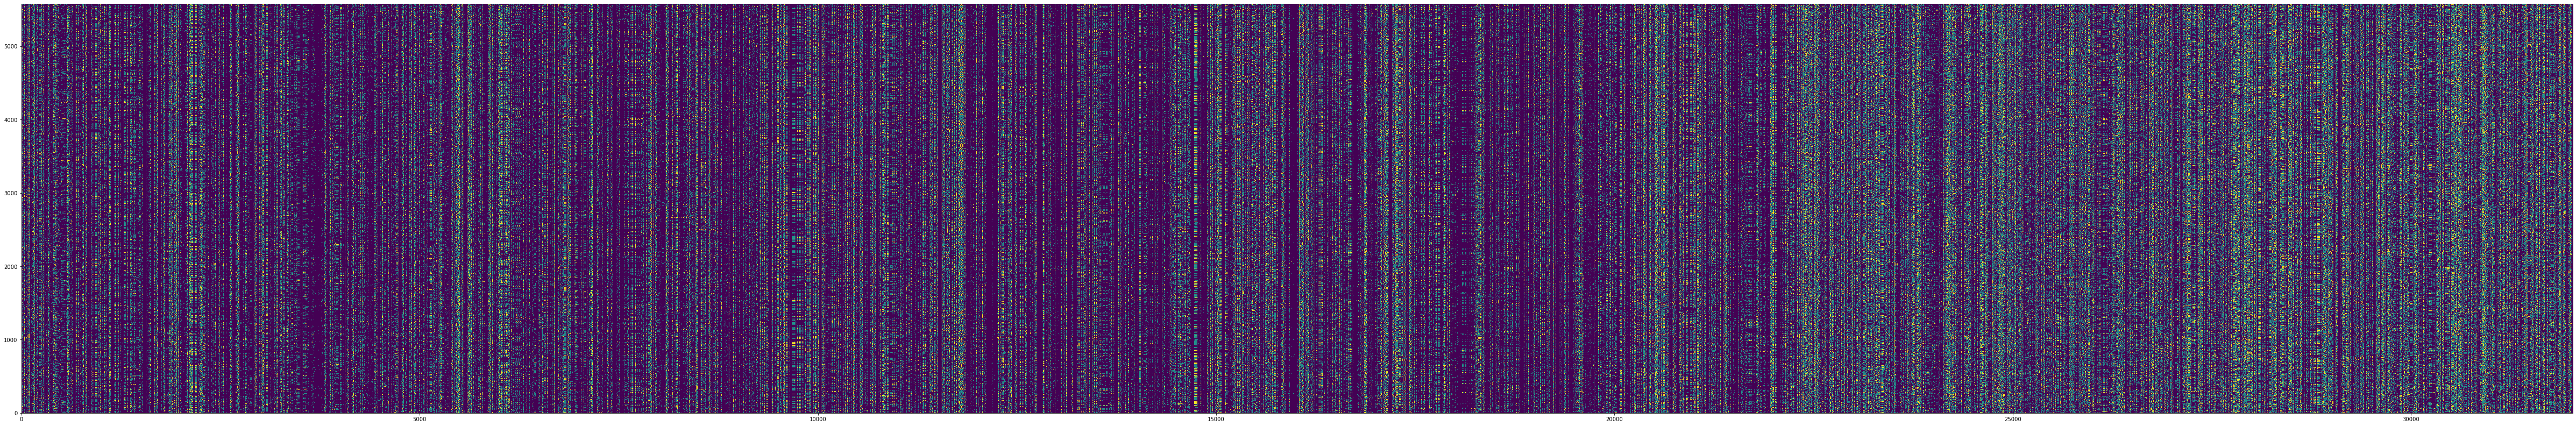

In [124]:
fig, ax = plt.subplots()

ax.pcolormesh(D)

fig.set_figwidth(85)    #  ширина и
fig.set_figheight(14)    #  высота "Figure"
#fig.set_facecolor('floralwhite')
#ax.set_facecolor('seashell')

plt.show()

In [24]:
#Res=OnlineOABic(D)

In [25]:
#len(Res)

In [26]:
A=np.array([[0, 1],[2, 0]])

In [27]:
A

array([[0, 1],
       [2, 0]])

In [28]:
BinScale(A,0)

array([[1, 0],
       [0, 1]])

In [29]:
BinScale(A,1)

array([[0, 1],
       [0, 0]])

In [30]:
BinScale(A,2)

array([[0, 0],
       [1, 0]])

In [31]:
BinScale(A,3)

array([[0, 0],
       [0, 0]])

In [32]:
%%time
D0=BinScale(D,0)

CPU times: user 2min 9s, sys: 1.93 s, total: 2min 10s
Wall time: 2min 11s


In [33]:
%%time
D1=BinScale(D,1)

CPU times: user 2min 6s, sys: 2.16 s, total: 2min 8s
Wall time: 2min 8s


In [34]:
%%time
D2=BinScale(D,2)

CPU times: user 2min 7s, sys: 2.14 s, total: 2min 9s
Wall time: 2min 10s


## 3. Biclustering

In [54]:
%%time

Res0=OnlineOABicRS(D0,dic2.values())

CPU times: user 26min 7s, sys: 57.1 s, total: 27min 5s
Wall time: 27min 30s


In [55]:
len(Res0)

10154

In [58]:
%%time

Res1=OnlineOABicRS(D1,dic2.values())

CPU times: user 7min 47s, sys: 21.4 s, total: 8min 9s
Wall time: 8min 13s


In [59]:
len(Res1)

13051

In [35]:
%%time

Res2=OnlineOABicRS(D2,dic2.values())

CPU times: user 1min 40s, sys: 1.41 s, total: 1min 42s
Wall time: 1min 42s


In [36]:
len(Res2)

4700

In [38]:
Res2[0]

(6,
 22327,
 [6,
  8,
  13,
  25,
  58,
  98,
  119,
  125,
  130,
  135,
  144,
  152,
  168,
  184,
  202,
  213,
  219,
  232,
  281,
  282,
  286,
  304,
  320,
  327,
  333,
  346,
  386,
  387,
  394,
  396,
  412,
  512,
  526,
  593,
  604,
  629,
  638,
  639,
  649,
  658,
  673,
  674,
  689,
  709,
  732,
  736,
  778,
  816,
  817,
  835,
  836,
  848,
  878,
  880,
  894,
  896,
  931,
  936,
  951,
  976,
  981,
  995,
  998,
  1025,
  1026,
  1032,
  1034,
  1056,
  1078,
  1084,
  1094,
  1098,
  1103,
  1110,
  1127,
  1131,
  1146,
  1149,
  1152,
  1161,
  1179,
  1188,
  1194,
  1206,
  1209,
  1213,
  1216,
  1223,
  1231,
  1241,
  1253,
  1259,
  1271,
  1280,
  1282,
  1285,
  1289,
  1291,
  1298,
  1332,
  1333,
  1347,
  1349,
  1353,
  1355,
  1374,
  1393,
  1405,
  1409,
  1432,
  1434,
  1435,
  1439,
  1442,
  1454,
  1464,
  1490,
  1507,
  1510,
  1523,
  1539,
  1546,
  1548,
  1574,
  1583,
  1592,
  1597,
  1603,
  1604,
  1613,
  1640,
  1641,
  1

In [231]:
ED_Density(D2, Res2[0],0.1,0.85)

n= 130
num= 1947
ones= 14
len(cells) 130


0.11001125665501987

In [240]:
ED_Density(D2, Res2[0],0.1,0.85)

0.14837289795006497

In [228]:
Density2(D2, Res2[0][2:])

0.14835591645845345

In [236]:
expd={}
dens=Density2(D2, Res2[0][2:])
for e in np.arange(0.05,0.55,0.05):
    for d in np.arange(0.5,1.0,0.05):
        if ED_Density(D2, Res2[0],e,d)>=dens:
            expd[(e,d)]=1
        else:
            expd[(e,d)]=0
            
            
            
        

n= 278
num= 1947
ones= 29
len(cells) 278
n= 299
num= 1947
ones= 42
len(cells) 299
n= 322
num= 1947
ones= 49
len(cells) 322
n= 349
num= 1947
ones= 51
len(cells) 349
n= 380
num= 1947
ones= 54
len(cells) 380
n= 416
num= 1947
ones= 64
len(cells) 416
n= 461
num= 1947
ones= 71
len(cells) 461
n= 519
num= 1947
ones= 79
len(cells) 519
n= 600
num= 1947
ones= 89
len(cells) 600
n= 738
num= 1947
ones= 88
len(cells) 738
n= 70
num= 1947
ones= 11
len(cells) 70
n= 75
num= 1947
ones= 11
len(cells) 75
n= 81
num= 1947
ones= 15
len(cells) 81
n= 88
num= 1947
ones= 14
len(cells) 88
n= 95
num= 1947
ones= 17
len(cells) 95
n= 104
num= 1947
ones= 15
len(cells) 104
n= 116
num= 1947
ones= 21
len(cells) 116
n= 130
num= 1947
ones= 15
len(cells) 130
n= 150
num= 1947
ones= 15
len(cells) 150
n= 185
num= 1947
ones= 28
len(cells) 185
n= 31
num= 1947
ones= 5
len(cells) 31
n= 34
num= 1947
ones= 6
len(cells) 34
n= 36
num= 1947
ones= 7
len(cells) 36
n= 39
num= 1947
ones= 4
len(cells) 39
n= 43
num= 1947
ones= 4
len(cells) 43


In [242]:
expd={}
dens=Density2(D2, Res2[0][2:])
for e in np.arange(0.05,0.55,0.05):
    for d in np.arange(0.5,1.0,0.05):
        if ED_Density(D2, Res2[0],e,d)>=dens:
            expd[(e,d)]=1
        else:
            expd[(e,d)]=0
            

In [267]:
# def ED_exp(D,Bicls):
#     expd={}
#     cnt=0
#     for b in Bicls:
#         dens=Density2(D2, b[2:])
#         for e in np.arange(0.05,0.55,0.05):
#             for d in np.arange(0.5,1.0,0.05):
#                 if abs(ED_Density(D2,b,e,d)-dens)<=e: 
#                     if (e,d) in expd.keys():
#                         expd[(e,d)]+=1
#                     else:
#                         expd[(e,d)]=1
#                 else:
#                     if (e,d) in expd.keys():
#                         pass
#                     else:
#                         expd[(e,d)]=0
#         cnt+=1
#         if cnt%10==0: print(cnt)
            
#     lB=len(Bicls)                    
#     for k in expd.keys():
#         expd[k]=expd[k]/lB

    
#     return expd

# def PrintExpTable(expd):
#     res=np.zeros((10,10))
#     for key in expd.keys():
#         res[int((key[0]-0.05)/0.05),int((key[1]-0.5)/0.05)]=expd[key]
#     return res
        

In [237]:
expd.values()

dict_values([0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0])

In [243]:
expd.values()

dict_values([1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0])

In [274]:
%%time
ED_exp_dic0=ED_exp(D0,Res0)

10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2190
2200
2210
222

In [275]:
%%time
ED_exp_dic1=ED_exp(D1,Res1)

10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2190
2200
2210
222

In [270]:
%%time
ED_exp(D2,Res2)

10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2190
2200
2210
222

{(0.05, 0.5): 0.9789361702127659,
 (0.05, 0.55): 0.9846808510638297,
 (0.05, 0.6000000000000001): 0.9904255319148936,
 (0.05, 0.6500000000000001): 0.9912765957446809,
 (0.05, 0.7000000000000002): 0.9968085106382979,
 (0.05, 0.7500000000000002): 0.9948936170212765,
 (0.05, 0.8000000000000003): 0.9976595744680851,
 (0.05, 0.8500000000000003): 0.9989361702127659,
 (0.05, 0.9000000000000004): 1.0,
 (0.05, 0.9500000000000004): 0.9997872340425532,
 (0.1, 0.5): 0.981063829787234,
 (0.1, 0.55): 0.9848936170212766,
 (0.1, 0.6000000000000001): 0.9934042553191489,
 (0.1, 0.6500000000000001): 0.994468085106383,
 (0.1, 0.7000000000000002): 0.9938297872340426,
 (0.1, 0.7500000000000002): 0.9959574468085106,
 (0.1, 0.8000000000000003): 0.9970212765957447,
 (0.1, 0.8500000000000003): 0.9980851063829788,
 (0.1, 0.9000000000000004): 0.9989361702127659,
 (0.1, 0.9500000000000004): 0.9997872340425532,
 (0.15000000000000002, 0.5): 0.9861702127659574,
 (0.15000000000000002, 0.55): 0.9848936170212766,
 (0.15

In [271]:
ED_exp_dic={(0.05, 0.5): 0.9789361702127659,
 (0.05, 0.55): 0.9846808510638297,
 (0.05, 0.6000000000000001): 0.9904255319148936,
 (0.05, 0.6500000000000001): 0.9912765957446809,
 (0.05, 0.7000000000000002): 0.9968085106382979,
 (0.05, 0.7500000000000002): 0.9948936170212765,
 (0.05, 0.8000000000000003): 0.9976595744680851,
 (0.05, 0.8500000000000003): 0.9989361702127659,
 (0.05, 0.9000000000000004): 1.0,
 (0.05, 0.9500000000000004): 0.9997872340425532,
 (0.1, 0.5): 0.981063829787234,
 (0.1, 0.55): 0.9848936170212766,
 (0.1, 0.6000000000000001): 0.9934042553191489,
 (0.1, 0.6500000000000001): 0.994468085106383,
 (0.1, 0.7000000000000002): 0.9938297872340426,
 (0.1, 0.7500000000000002): 0.9959574468085106,
 (0.1, 0.8000000000000003): 0.9970212765957447,
 (0.1, 0.8500000000000003): 0.9980851063829788,
 (0.1, 0.9000000000000004): 0.9989361702127659,
 (0.1, 0.9500000000000004): 0.9997872340425532,
 (0.15000000000000002, 0.5): 0.9861702127659574,
 (0.15000000000000002, 0.55): 0.9848936170212766,
 (0.15000000000000002, 0.6000000000000001): 0.9865957446808511,
 (0.15000000000000002, 0.6500000000000001): 0.9887234042553191,
 (0.15000000000000002, 0.7000000000000002): 0.9938297872340426,
 (0.15000000000000002, 0.7500000000000002): 0.995531914893617,
 (0.15000000000000002, 0.8000000000000003): 0.9974468085106383,
 (0.15000000000000002, 0.8500000000000003): 0.997872340425532,
 (0.15000000000000002, 0.9000000000000004): 0.9987234042553191,
 (0.15000000000000002, 0.9500000000000004): 0.9997872340425532,
 (0.2, 0.5): 0.9904255319148936,
 (0.2, 0.55): 0.9827659574468085,
 (0.2, 0.6000000000000001): 0.9929787234042553,
 (0.2, 0.6500000000000001): 0.9938297872340426,
 (0.2, 0.7000000000000002): 0.9957446808510638,
 (0.2, 0.7500000000000002): 0.9940425531914894,
 (0.2, 0.8000000000000003): 0.9974468085106383,
 (0.2, 0.8500000000000003): 0.9980851063829788,
 (0.2, 0.9000000000000004): 0.9995744680851064,
 (0.2, 0.9500000000000004): 0.9995744680851064,
 (0.25, 0.5): 0.9819148936170212,
 (0.25, 0.55): 0.9748936170212766,
 (0.25, 0.6000000000000001): 0.9951063829787234,
 (0.25, 0.6500000000000001): 0.9880851063829788,
 (0.25, 0.7000000000000002): 0.9968085106382979,
 (0.25, 0.7500000000000002): 0.9906382978723405,
 (0.25, 0.8000000000000003): 0.9976595744680851,
 (0.25, 0.8500000000000003): 0.9985106382978723,
 (0.25, 0.9000000000000004): 0.9993617021276596,
 (0.25, 0.9500000000000004): 0.9995744680851064,
 (0.3, 0.5): 0.9768085106382979,
 (0.3, 0.55): 0.9880851063829788,
 (0.3, 0.6000000000000001): 0.9874468085106383,
 (0.3, 0.6500000000000001): 0.9921276595744681,
 (0.3, 0.7000000000000002): 0.9859574468085106,
 (0.3, 0.7500000000000002): 0.9968085106382979,
 (0.3, 0.8000000000000003): 0.9940425531914894,
 (0.3, 0.8500000000000003): 0.9970212765957447,
 (0.3, 0.9000000000000004): 0.9987234042553191,
 (0.3, 0.9500000000000004): 0.9993617021276596,
 (0.35000000000000003, 0.5): 0.9668085106382979,
 (0.35000000000000003, 0.55): 0.9880851063829788,
 (0.35000000000000003, 0.6000000000000001): 0.9870212765957447,
 (0.35000000000000003, 0.6500000000000001): 0.987872340425532,
 (0.35000000000000003, 0.7000000000000002): 0.987872340425532,
 (0.35000000000000003, 0.7500000000000002): 0.994468085106383,
 (0.35000000000000003, 0.8000000000000003): 0.9951063829787234,
 (0.35000000000000003, 0.8500000000000003): 0.997872340425532,
 (0.35000000000000003, 0.9000000000000004): 0.997872340425532,
 (0.35000000000000003, 0.9500000000000004): 0.9993617021276596,
 (0.4, 0.5): 0.9736170212765958,
 (0.4, 0.55): 0.9738297872340426,
 (0.4, 0.6000000000000001): 0.9934042553191489,
 (0.4, 0.6500000000000001): 0.9936170212765958,
 (0.4, 0.7000000000000002): 0.9931914893617021,
 (0.4, 0.7500000000000002): 0.9874468085106383,
 (0.4, 0.8000000000000003): 0.9976595744680851,
 (0.4, 0.8500000000000003): 0.995531914893617,
 (0.4, 0.9000000000000004): 0.9982978723404256,
 (0.4, 0.9500000000000004): 0.9989361702127659,
 (0.45, 0.5): 0.9872340425531915,
 (0.45, 0.55): 0.9891489361702127,
 (0.45, 0.6000000000000001): 0.9889361702127659,
 (0.45, 0.6500000000000001): 0.9848936170212766,
 (0.45, 0.7000000000000002): 0.9870212765957447,
 (0.45, 0.7500000000000002): 0.9938297872340426,
 (0.45, 0.8000000000000003): 0.9942553191489362,
 (0.45, 0.8500000000000003): 0.997872340425532,
 (0.45, 0.9000000000000004): 0.9965957446808511,
 (0.45, 0.9500000000000004): 0.9993617021276596,
 (0.5, 0.5): 0.9453191489361702,
 (0.5, 0.55): 0.9436170212765957,
 (0.5, 0.6000000000000001): 0.9880851063829788,
 (0.5, 0.6500000000000001): 0.9882978723404255,
 (0.5, 0.7000000000000002): 0.9891489361702127,
 (0.5, 0.7500000000000002): 0.9982978723404256,
 (0.5, 0.8000000000000003): 0.9989361702127659,
 (0.5, 0.8500000000000003): 0.9934042553191489,
 (0.5, 0.9000000000000004): 0.9951063829787234,
 (0.5, 0.9500000000000004): 1.0}

In [272]:
ED_exp_dic

{(0.05, 0.5): 0.9789361702127659,
 (0.05, 0.55): 0.9846808510638297,
 (0.05, 0.6000000000000001): 0.9904255319148936,
 (0.05, 0.6500000000000001): 0.9912765957446809,
 (0.05, 0.7000000000000002): 0.9968085106382979,
 (0.05, 0.7500000000000002): 0.9948936170212765,
 (0.05, 0.8000000000000003): 0.9976595744680851,
 (0.05, 0.8500000000000003): 0.9989361702127659,
 (0.05, 0.9000000000000004): 1.0,
 (0.05, 0.9500000000000004): 0.9997872340425532,
 (0.1, 0.5): 0.981063829787234,
 (0.1, 0.55): 0.9848936170212766,
 (0.1, 0.6000000000000001): 0.9934042553191489,
 (0.1, 0.6500000000000001): 0.994468085106383,
 (0.1, 0.7000000000000002): 0.9938297872340426,
 (0.1, 0.7500000000000002): 0.9959574468085106,
 (0.1, 0.8000000000000003): 0.9970212765957447,
 (0.1, 0.8500000000000003): 0.9980851063829788,
 (0.1, 0.9000000000000004): 0.9989361702127659,
 (0.1, 0.9500000000000004): 0.9997872340425532,
 (0.15000000000000002, 0.5): 0.9861702127659574,
 (0.15000000000000002, 0.55): 0.9848936170212766,
 (0.15

In [276]:
PrintExpTable(ED_exp_dic0)

array([[0.96897774, 0.97823518, 0.98089423, 0.98453811, 0.98926531,
        0.99182588, 0.994091  , 0.9976364 , 0.9982273 , 0.99960607],
       [0.97173528, 0.97862911, 0.97902305, 0.98276541, 0.988182  ,
        0.99261375, 0.99428797, 0.99635612, 0.99803033, 0.9994091 ],
       [0.97675793, 0.97892456, 0.97744731, 0.98246996, 0.99212133,
        0.99202285, 0.99635612, 0.9970455 , 0.99803033, 0.99921213],
       [0.96700808, 0.98719716, 0.98650778, 0.99005318, 0.99517432,
        0.98985621, 0.99507583, 0.9964546 , 0.99862123, 0.99931062],
       [0.98749261, 0.9864093 , 0.9793185 , 0.99123498, 0.98256845,
        0.99399252, 0.99576522, 0.99724247, 0.99783337, 0.99901517],
       [0.95686429, 0.9893638 , 0.98571991, 0.97636399, 0.99143195,
        0.98798503, 0.9964546 , 0.99871972, 0.99862123, 0.99960607],
       [0.98828048, 0.97902305, 0.97725034, 0.99281071, 0.99478038,
        0.98788655, 0.99635612, 0.99379555, 0.99625763, 0.99931062],
       [0.95676581, 0.95735671, 0.9885759

In [278]:
PrintExpTable(ED_exp_dic1)

array([[0.9141062 , 0.92950732, 0.93379818, 0.94674738, 0.95509923,
        0.96429392, 0.97371849, 0.98084438, 0.99042219, 0.99432994],
       [0.91625163, 0.92253467, 0.93510076, 0.94674738, 0.96007969,
        0.96774194, 0.97440809, 0.98184047, 0.98965597, 0.99448318],
       [0.91372309, 0.93356831, 0.92483335, 0.95540572, 0.95678492,
        0.96597962, 0.97808597, 0.98283656, 0.98911961, 0.99524941],
       [0.91372309, 0.91678799, 0.95548234, 0.95119148, 0.94567466,
        0.96774194, 0.97027048, 0.98544173, 0.98934948, 0.99670523],
       [0.93058003, 0.93172937, 0.96030955, 0.95111486, 0.96053942,
        0.95961995, 0.9689679 , 0.98888974, 0.98973259, 0.99570914],
       [0.94398897, 0.96705233, 0.96988736, 0.95218757, 0.97295226,
        0.9870508 , 0.96820167, 0.98605471, 0.99134166, 0.99678186],
       [0.90805302, 0.94766685, 0.94935254, 0.93870202, 0.94077082,
        0.96605624, 0.98413915, 0.98038464, 0.99287411, 0.99670523],
       [0.93280208, 0.92559957, 0.9678185

In [273]:
PrintExpTable(ED_exp_dic)

array([[0.97893617, 0.98468085, 0.99042553, 0.9912766 , 0.99680851,
        0.99489362, 0.99765957, 0.99893617, 1.        , 0.99978723],
       [0.98106383, 0.98489362, 0.99340426, 0.99446809, 0.99382979,
        0.99595745, 0.99702128, 0.99808511, 0.99893617, 0.99978723],
       [0.98617021, 0.98489362, 0.98659574, 0.9887234 , 0.99382979,
        0.99553191, 0.99744681, 0.99787234, 0.9987234 , 0.99978723],
       [0.99042553, 0.98276596, 0.99297872, 0.99382979, 0.99574468,
        0.99404255, 0.99744681, 0.99808511, 0.99957447, 0.99957447],
       [0.98191489, 0.97489362, 0.99510638, 0.98808511, 0.99680851,
        0.9906383 , 0.99765957, 0.99851064, 0.9993617 , 0.99957447],
       [0.97680851, 0.98808511, 0.98744681, 0.99212766, 0.98595745,
        0.99680851, 0.99404255, 0.99702128, 0.9987234 , 0.9993617 ],
       [0.96680851, 0.98808511, 0.98702128, 0.98787234, 0.98787234,
        0.99446809, 0.99510638, 0.99787234, 0.99787234, 0.9993617 ],
       [0.97361702, 0.97382979, 0.9934042

In [259]:
np.zeros((10,10))

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])


### Biclustering with code value 0

In [60]:
%%time

dic_den0=biclDenLenArr(D0,Res0,range(len(Res0)))

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
CPU times: user 5h 11min 11s, sys: 1h 15min 39s, total: 6h 26min 51s
Wall time: 6h 29min 7s


In [85]:
%%time

dic_pur0=biclPurArr(Res0,Pos)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
CPU times: user 4h 21min 6s, sys: 2min 54s, total: 4h 24min 1s
Wall time: 4h 25min 19s


In [287]:
import re
timestring="4h 25min 19s"
timestring2="7h 14min 43s"

triple=[int(s) for s in re.findall(r'\b\d+', timestring)]

secs1=triple[0]*3600+triple[1]*60+triple[2]

triple=[int(s) for s in re.findall(r'\b\d+', timestring2)]

secs2=triple[0]*3600+triple[1]*60+triple[2]

In [291]:
secs/(secs2/100)

61.03208986696316

### Biclustering with code value 0

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

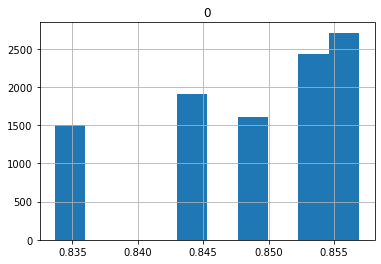

In [91]:
pd.DataFrame(dic_pur0.values()).hist()

In [77]:
Res0[0]

(3,
 22327,
 [3,
  4,
  5,
  11,
  14,
  15,
  16,
  18,
  20,
  21,
  23,
  27,
  28,
  30,
  32,
  36,
  37,
  38,
  39,
  40,
  41,
  43,
  44,
  45,
  46,
  48,
  49,
  50,
  51,
  52,
  53,
  55,
  56,
  57,
  59,
  60,
  61,
  62,
  67,
  68,
  69,
  70,
  76,
  77,
  78,
  80,
  81,
  83,
  84,
  87,
  88,
  89,
  90,
  91,
  92,
  93,
  99,
  101,
  102,
  106,
  108,
  109,
  110,
  112,
  116,
  120,
  121,
  122,
  123,
  124,
  126,
  128,
  132,
  133,
  137,
  138,
  139,
  140,
  141,
  142,
  146,
  147,
  148,
  149,
  151,
  154,
  155,
  156,
  158,
  161,
  163,
  164,
  165,
  166,
  167,
  169,
  170,
  172,
  175,
  177,
  179,
  180,
  181,
  182,
  183,
  189,
  190,
  191,
  192,
  194,
  196,
  197,
  198,
  201,
  204,
  205,
  208,
  210,
  211,
  212,
  214,
  215,
  216,
  217,
  220,
  221,
  223,
  224,
  225,
  227,
  228,
  229,
  230,
  231,
  233,
  236,
  237,
  240,
  244,
  245,
  246,
  250,
  251,
  253,
  256,
  258,
  259,
  260,
  261,
  262

In [78]:
Purity(Res0[0][2],Pos)

0.8569321533923304

In [111]:
dic0_full=biclDicGlue(dic_den0, dic_pur0)

In [103]:
list(dic_den0.keys())[0]

(3, 22327)

In [104]:
dic_den0[(3, 22327)]

(0.820307899122275, 2712, 23417)

In [106]:
dic_pur0[(3, 22327)]

0.8569321533923304

In [109]:
dic_den0[(3, 22327)]+(dic_pur0[(3, 22327)],)

(0.820307899122275, 2712, 23417, 0.8569321533923304)

In [112]:
import pandas as pd
Bicl_stat0=[list(val) for val in dic0_full.values()]
df_Bs0=pd.DataFrame(Bicl_stat0,columns =['Density', 'Extent', 'Intent', 'Purity'])

/var/folders/_3/lhn1ctt11sbb8sfyh3x9r3vm0000gq/T/ipykernel_8283/3035610077.py:7: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  df_Bs0.hist(ax = ax, bins=100)


array([[<AxesSubplot:title={'center':'Density'}>,
        <AxesSubplot:title={'center':'Extent'}>],
       [<AxesSubplot:title={'center':'Intent'}>,
        <AxesSubplot:title={'center':'Purity'}>]], dtype=object)

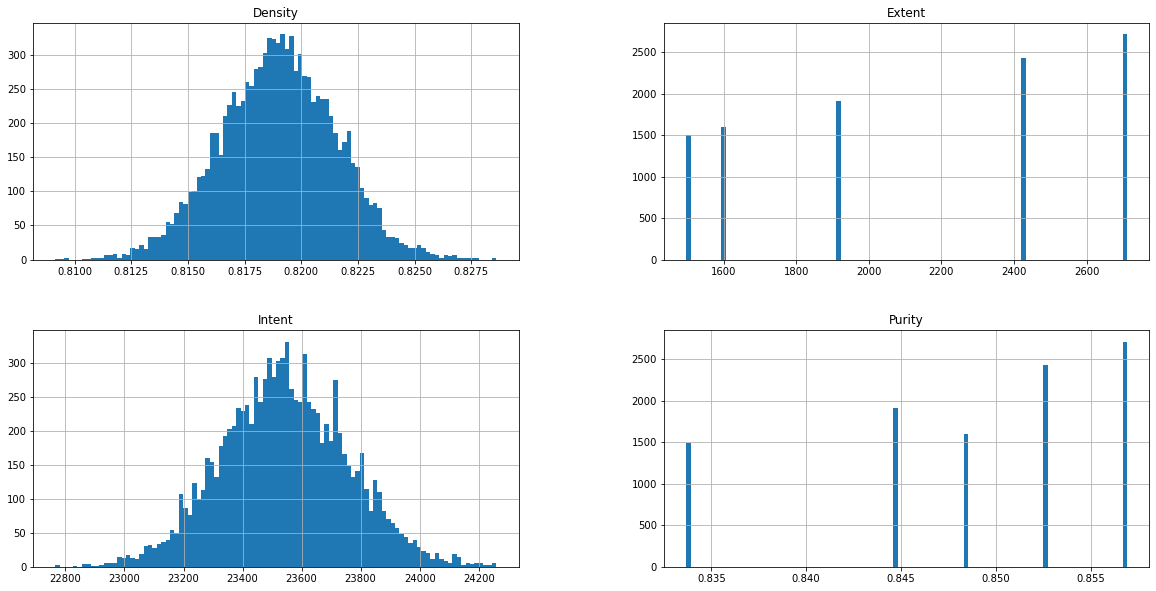

In [113]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (20,10))
ax = fig.gca()


df_Bs0.hist(ax = ax, bins=100)

In [128]:
Sel0=Selection(Bicl_stat0, 0.8255, 1, 1400, 2800, 20000, 25000)

In [133]:
Sel0

[[0.8259813653642993, 2712, 23201, 0.8569321533923304],
 [0.8272386348151688, 2712, 23055, 0.8569321533923304],
 [0.8265458438176638, 2712, 22994, 0.8569321533923304],
 [0.8276988090110045, 2712, 22989, 0.8569321533923304],
 [0.8255658181282147, 2712, 23053, 0.8569321533923304],
 [0.8256906768157215, 2712, 23415, 0.8569321533923304],
 [0.8286162754015971, 2712, 22919, 0.8569321533923304],
 [0.8267801752990548, 2712, 22942, 0.8569321533923304],
 [0.8267867986560817, 2712, 23084, 0.8569321533923304],
 [0.8258990882204196, 2712, 23028, 0.8569321533923304],
 [0.8259371356486171, 2712, 23150, 0.8569321533923304],
 [0.8256068644499764, 2712, 23114, 0.8569321533923304],
 [0.8266524880506115, 2712, 23081, 0.8569321533923304],
 [0.8263192080532444, 2712, 22862, 0.8569321533923304],
 [0.8256641623821617, 2712, 23006, 0.8569321533923304],
 [0.8259222444205174, 1603, 23155, 0.8484092326887087],
 [0.8258414885981064, 1603, 22948, 0.8484092326887087],
 [0.8255615896205046, 1603, 23010, 0.84840923268

In [136]:
Sel0=SelectionD(dic0_full, 0.8255, 1, 1400, 2800, 20000, 25000)

In [137]:
Sel0

{(722, 22327): (0.8259813653642993, 2712, 23201, 0.8569321533923304),
 (1735, 22327): (0.8272386348151688, 2712, 23055, 0.8569321533923304),
 (1746, 22327): (0.8265458438176638, 2712, 22994, 0.8569321533923304),
 (1823, 22327): (0.8276988090110045, 2712, 22989, 0.8569321533923304),
 (1988, 22327): (0.8255658181282147, 2712, 23053, 0.8569321533923304),
 (2041, 22327): (0.8256906768157215, 2712, 23415, 0.8569321533923304),
 (2718, 22327): (0.8286162754015971, 2712, 22919, 0.8569321533923304),
 (3159, 22327): (0.8267801752990548, 2712, 22942, 0.8569321533923304),
 (3495, 22327): (0.8267867986560817, 2712, 23084, 0.8569321533923304),
 (3753, 22327): (0.8258990882204196, 2712, 23028, 0.8569321533923304),
 (3889, 22327): (0.8259371356486171, 2712, 23150, 0.8569321533923304),
 (4405, 22327): (0.8256068644499764, 2712, 23114, 0.8569321533923304),
 (5017, 22327): (0.8266524880506115, 2712, 23081, 0.8569321533923304),
 (5434, 22327): (0.8263192080532444, 2712, 22862, 0.8569321533923304),
 (5564,

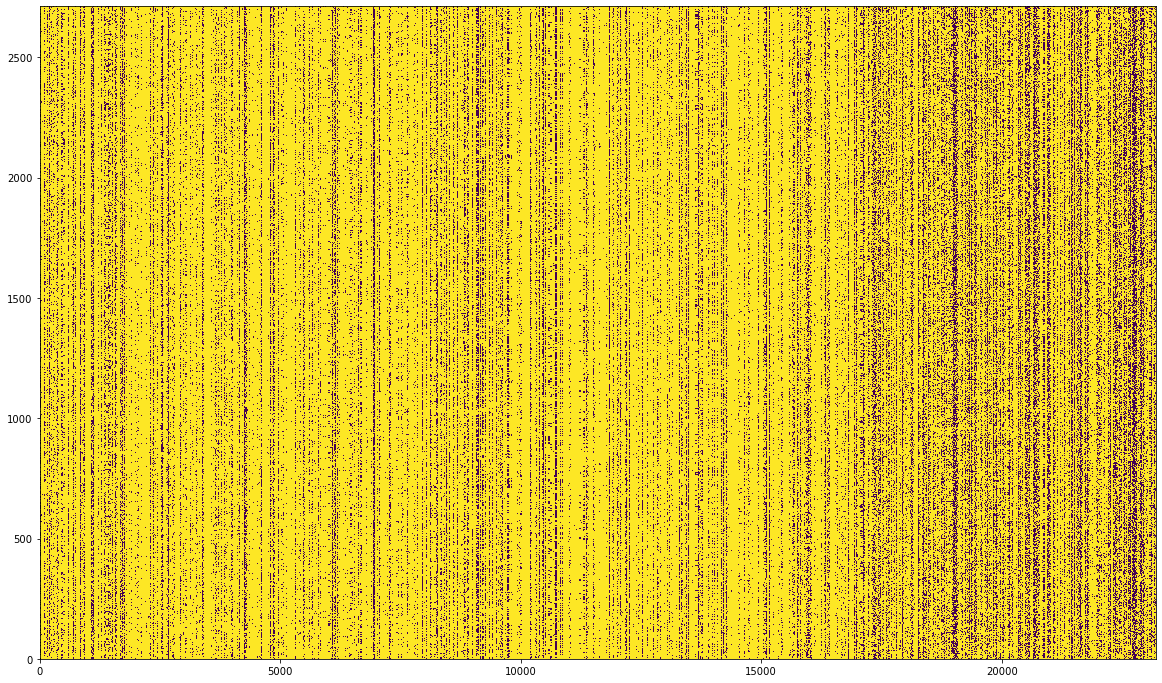

In [145]:
fig, ax = plt.subplots()

B=FindBic(Res0,(722, 22327))

ax.pcolormesh(D0[B[0],:][:,B[1]])

fig.set_figwidth(20)    #  ширина и
fig.set_figheight(12)    #  высота "Figure"
#fig.set_facecolor('floralwhite')
#ax.set_facecolor('seashell')

plt.show()

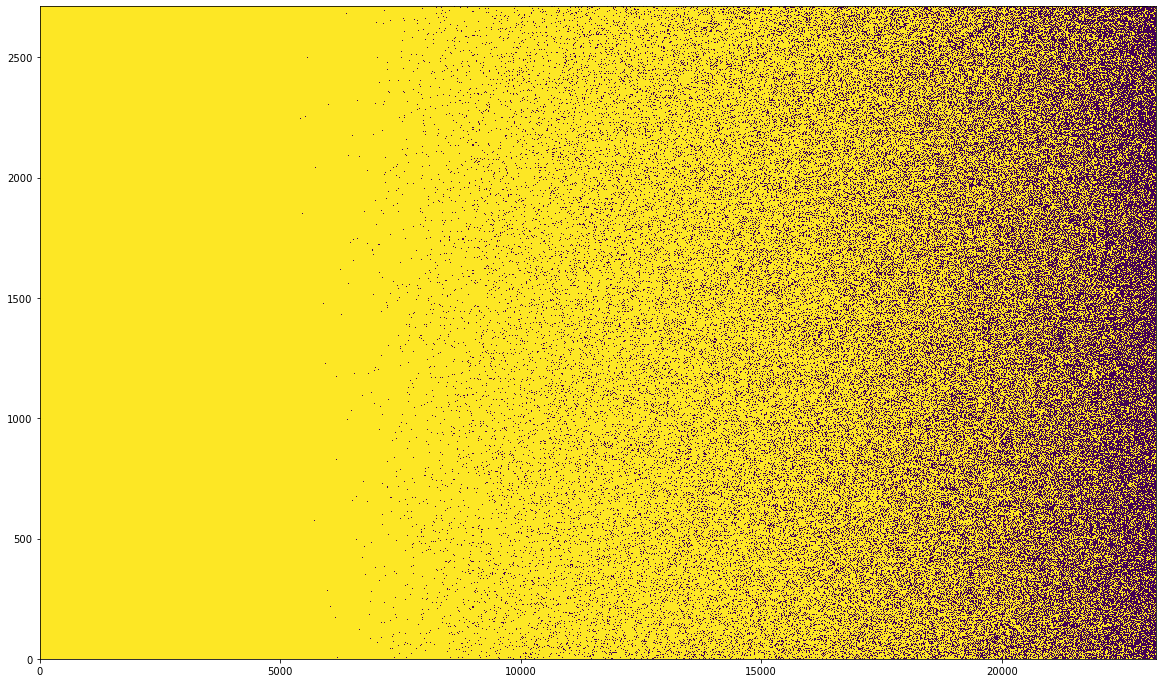

In [162]:
fig, ax = plt.subplots()

B=FindBic(Res0,(722, 22327))

ax.pcolormesh(D0[B[0],:][:,SortedIntent])

fig.set_figwidth(20)    #  ширина и
fig.set_figheight(12)    #  высота "Figure"
#fig.set_facecolor('floralwhite')
#ax.set_facecolor('seashell')

plt.show()

In [153]:
SNPswithinBiclBySupp(B, D0)

{0: (2712, 1.0),
 2: (2712, 1.0),
 3: (2712, 1.0),
 5: (2533, 0.9339970501474927),
 6: (2403, 0.8860619469026548),
 8: (2708, 0.9985250737463127),
 10: (2518, 0.9284660766961652),
 11: (2709, 0.9988938053097345),
 12: (1975, 0.7282448377581121),
 14: (2534, 0.9343657817109144),
 17: (2712, 1.0),
 18: (1207, 0.4450589970501475),
 19: (1201, 0.44284660766961653),
 21: (1207, 0.4450589970501475),
 22: (2224, 0.8200589970501475),
 23: (1874, 0.6910029498525073),
 24: (1361, 0.5018436578171092),
 25: (2520, 0.9292035398230089),
 26: (1207, 0.4450589970501475),
 27: (2600, 0.9587020648967551),
 28: (2712, 1.0),
 29: (2712, 1.0),
 31: (2711, 0.9996312684365781),
 33: (1771, 0.653023598820059),
 35: (2712, 1.0),
 38: (2495, 0.9199852507374632),
 40: (2566, 0.946165191740413),
 41: (2577, 0.9502212389380531),
 42: (2635, 0.9716076696165191),
 43: (972, 0.3584070796460177),
 44: (2697, 0.9944690265486725),
 45: (2710, 0.9992625368731564),
 46: (2049, 0.7555309734513275),
 47: (2048, 0.7551622418

In [155]:
SNPs=SNPswithinBiclBySupp(B, D0)

In [158]:
SNPs_sort=sorted([(SNPs[k][0],SNPs[k][1],k) for k in SNPs.keys()])
SNPs_sort.reverse()

In [160]:
print(SNPs_sort)

[(2712, 1.0, 32026), (2712, 1.0, 31994), (2712, 1.0, 31977), (2712, 1.0, 31970), (2712, 1.0, 31952), (2712, 1.0, 31939), (2712, 1.0, 31937), (2712, 1.0, 31932), (2712, 1.0, 31927), (2712, 1.0, 31907), (2712, 1.0, 31893), (2712, 1.0, 31885), (2712, 1.0, 31876), (2712, 1.0, 31841), (2712, 1.0, 31834), (2712, 1.0, 31818), (2712, 1.0, 31814), (2712, 1.0, 31799), (2712, 1.0, 31780), (2712, 1.0, 31779), (2712, 1.0, 31770), (2712, 1.0, 31759), (2712, 1.0, 31741), (2712, 1.0, 31732), (2712, 1.0, 31722), (2712, 1.0, 31712), (2712, 1.0, 31689), (2712, 1.0, 31669), (2712, 1.0, 31642), (2712, 1.0, 31637), (2712, 1.0, 31624), (2712, 1.0, 31590), (2712, 1.0, 31565), (2712, 1.0, 31553), (2712, 1.0, 31537), (2712, 1.0, 31522), (2712, 1.0, 31504), (2712, 1.0, 31502), (2712, 1.0, 31436), (2712, 1.0, 31431), (2712, 1.0, 31405), (2712, 1.0, 31393), (2712, 1.0, 31382), (2712, 1.0, 31369), (2712, 1.0, 31356), (2712, 1.0, 31336), (2712, 1.0, 31317), (2712, 1.0, 31306), (2712, 1.0, 31297), (2712, 1.0, 31262),

In [164]:
SNPs_sort_rs=[(t[0],t[1],list(DF.columns)[t[2]+2]) for t in SNPs_sort]

In [165]:
print(SNPs_sort_rs)

[(2712, 1.0, 'rs5771007_C'), (2712, 1.0, 'rs6151427_C'), (2712, 1.0, 'rs8137073_C'), (2712, 1.0, 'rs2269383_T'), (2712, 1.0, 'rs8141871_T'), (2712, 1.0, 'rs13053471_T'), (2712, 1.0, 'rs2236032_A'), (2712, 1.0, 'rs6010103_A'), (2712, 1.0, 'rs17781316_A'), (2712, 1.0, 'rs11091006_A'), (2712, 1.0, 'rs12484714_T'), (2712, 1.0, 'rs17248287_T'), (2712, 1.0, 'rs2294398_A'), (2712, 1.0, 'rs875845_C'), (2712, 1.0, 'rs2076126_A'), (2712, 1.0, 'rs17013076_T'), (2712, 1.0, 'rs5771129_A'), (2712, 1.0, 'rs28639866_T'), (2712, 1.0, 'rs6009917_A'), (2712, 1.0, 'rs9627781_C'), (2712, 1.0, 'rs1569956_A'), (2712, 1.0, 'rs9628136_A'), (2712, 1.0, 'rs6009305_A'), (2712, 1.0, 'rs12159187_G'), (2712, 1.0, 'rs11912517_T'), (2712, 1.0, 'rs6009784_T'), (2712, 1.0, 'rs6009750_C'), (2712, 1.0, 'rs8142118_A'), (2712, 1.0, 'rs17000951_T'), (2712, 1.0, 'rs17000918_A'), (2712, 1.0, 'rs762923_A'), (2712, 1.0, 'rs7284139_C'), (2712, 1.0, 'rs6009626_C'), (2712, 1.0, 'rs9627968_A'), (2712, 1.0, 'rs9627936_T'), (2712, 1.0

In [171]:
#names=list(DF.columns)
for t in SNPs_sort_rs:
    for rs in RS:
        if rs in t[2]:
            print(t)

(2712, 1.0, 'rs9606478_G')
(1171, 0.43178466076696165, 'rs4823464_G')


In [161]:
SortedIntent=[t[2] for t in SNPs_sort]

In [139]:
Res0[0]

(3,
 22327,
 [3,
  4,
  5,
  11,
  14,
  15,
  16,
  18,
  20,
  21,
  23,
  27,
  28,
  30,
  32,
  36,
  37,
  38,
  39,
  40,
  41,
  43,
  44,
  45,
  46,
  48,
  49,
  50,
  51,
  52,
  53,
  55,
  56,
  57,
  59,
  60,
  61,
  62,
  67,
  68,
  69,
  70,
  76,
  77,
  78,
  80,
  81,
  83,
  84,
  87,
  88,
  89,
  90,
  91,
  92,
  93,
  99,
  101,
  102,
  106,
  108,
  109,
  110,
  112,
  116,
  120,
  121,
  122,
  123,
  124,
  126,
  128,
  132,
  133,
  137,
  138,
  139,
  140,
  141,
  142,
  146,
  147,
  148,
  149,
  151,
  154,
  155,
  156,
  158,
  161,
  163,
  164,
  165,
  166,
  167,
  169,
  170,
  172,
  175,
  177,
  179,
  180,
  181,
  182,
  183,
  189,
  190,
  191,
  192,
  194,
  196,
  197,
  198,
  201,
  204,
  205,
  208,
  210,
  211,
  212,
  214,
  215,
  216,
  217,
  220,
  221,
  223,
  224,
  225,
  227,
  228,
  229,
  230,
  231,
  233,
  236,
  237,
  240,
  244,
  245,
  246,
  250,
  251,
  253,
  256,
  258,
  259,
  260,
  261,
  262

In [129]:
df_Sel0=pd.DataFrame(Sel0, columns =['Density', 'Extent', 'Intent', 'Purity'])

/var/folders/_3/lhn1ctt11sbb8sfyh3x9r3vm0000gq/T/ipykernel_8283/3168079989.py:6: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  df_Sel0.hist(ax = ax, bins=100, log=True)


array([[<AxesSubplot:title={'center':'Density'}>,
        <AxesSubplot:title={'center':'Extent'}>],
       [<AxesSubplot:title={'center':'Intent'}>,
        <AxesSubplot:title={'center':'Purity'}>]], dtype=object)

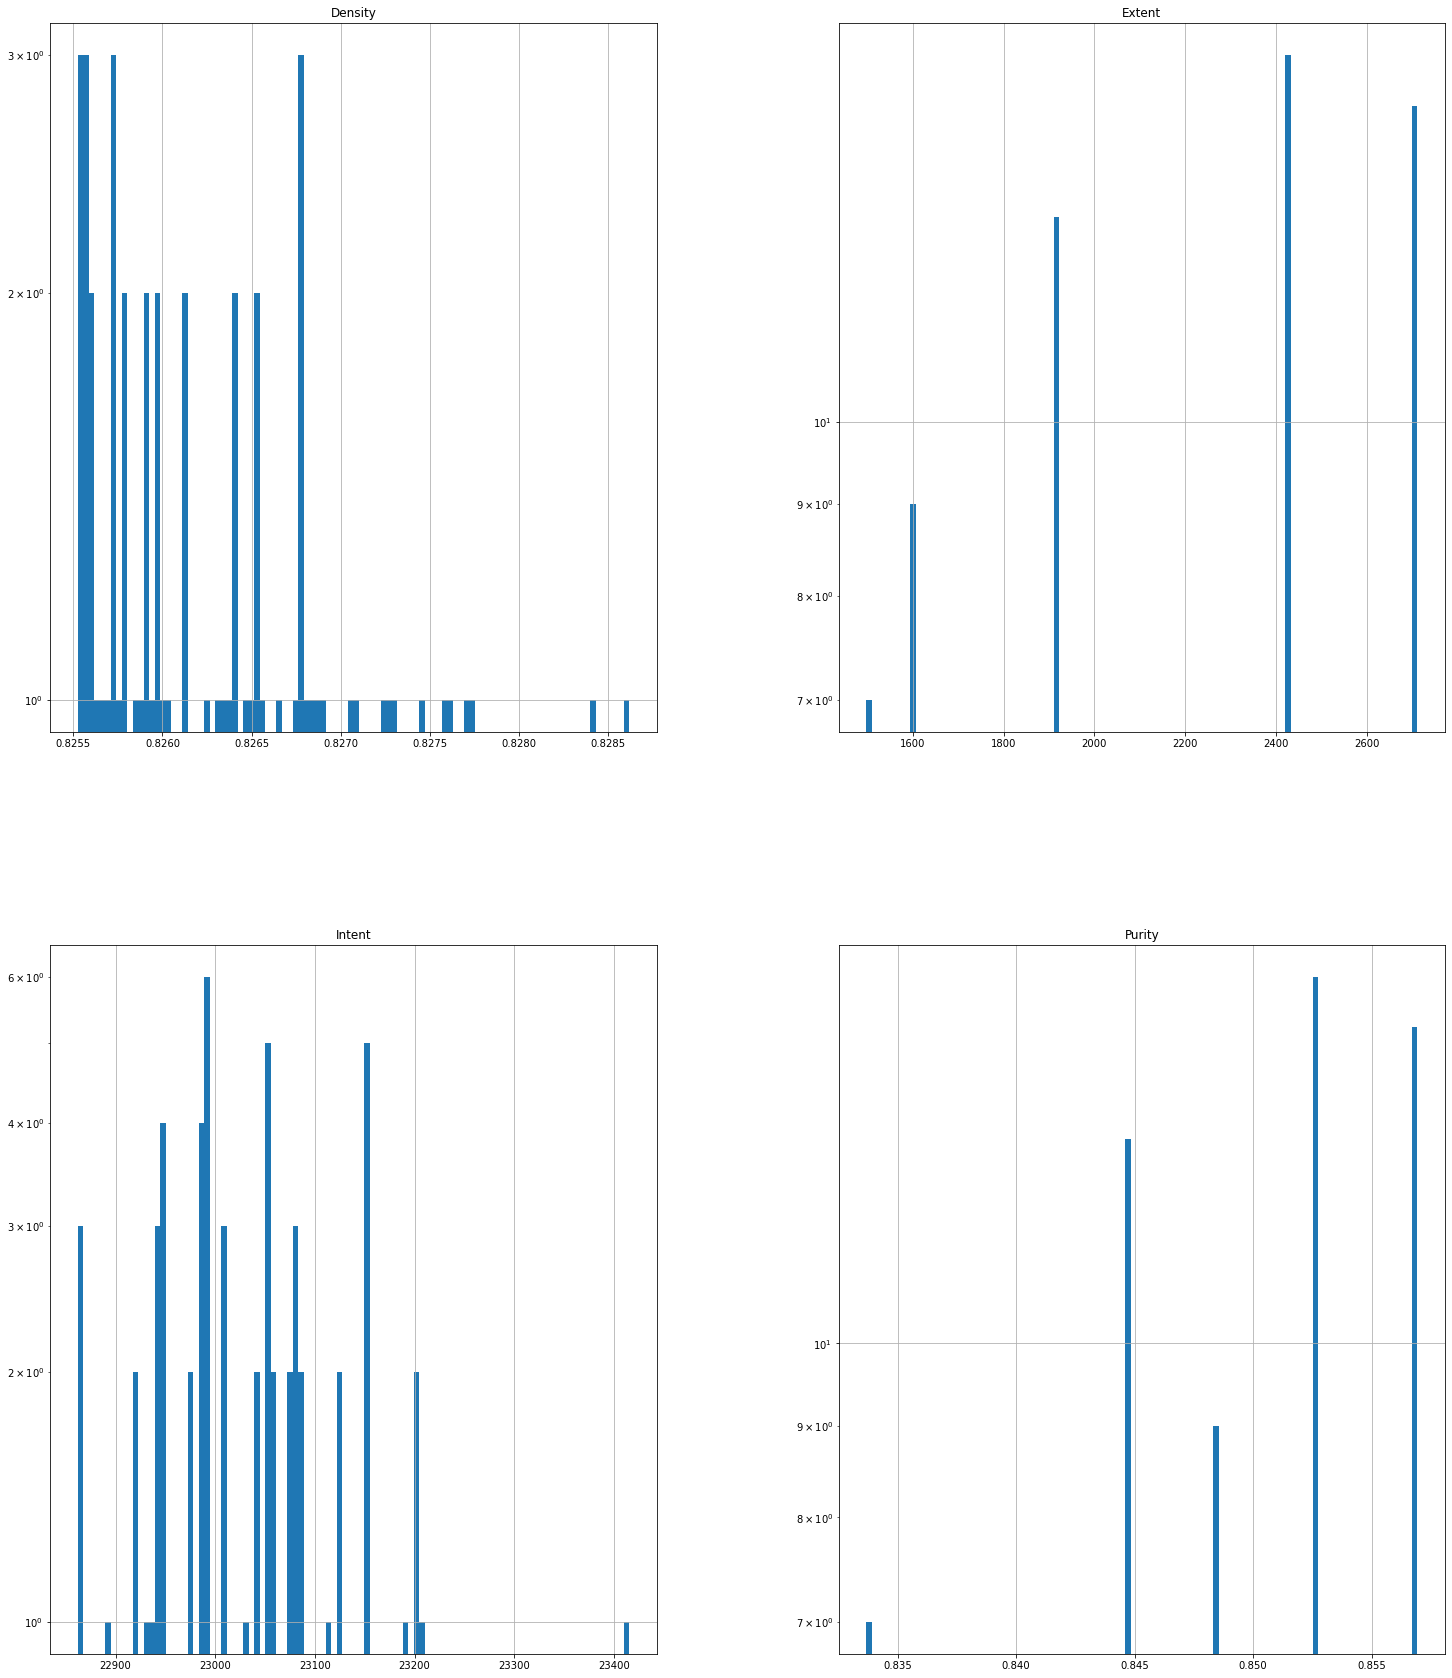

In [130]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (25,30))
ax = fig.gca()

df_Sel0.hist(ax = ax, bins=100, log=True)

### Biclustering with code value 1

In [61]:
%%time

dic_den1=biclDenLenArr(D1,Res1,range(len(Res1)))

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
CPU times: user 5h 26min 55s, sys: 1h 23min 18s, total: 6h 50min 13s
Wall time: 6h 53min 27s


In [93]:
%%time

dic_pur1=biclPurArr(Res1,Pos)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
CPU times: user 7h 33min 9s, sys: 3min 52s, total: 7h 37min 1s
Wall time: 7h 38min 3s


array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

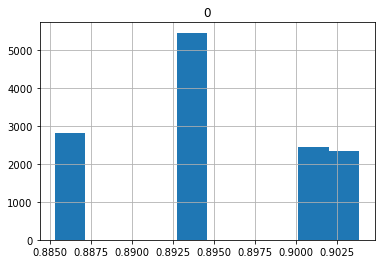

In [94]:
pd.DataFrame(dic_pur1.values()).hist()

In [114]:
dic1_full=biclDicGlue(dic_den1, dic_pur1)

In [116]:
import pandas as pd
Bicl_stat1=[list(val) for val in dic1_full.values()]
df_Bs1=pd.DataFrame(Bicl_stat1,columns =['Density', 'Extent', 'Intent', 'Purity'])

/var/folders/_3/lhn1ctt11sbb8sfyh3x9r3vm0000gq/T/ipykernel_8283/673659779.py:7: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  df_Bs1.hist(ax = ax, bins=100)


array([[<AxesSubplot:title={'center':'Density'}>,
        <AxesSubplot:title={'center':'Extent'}>],
       [<AxesSubplot:title={'center':'Intent'}>,
        <AxesSubplot:title={'center':'Purity'}>]], dtype=object)

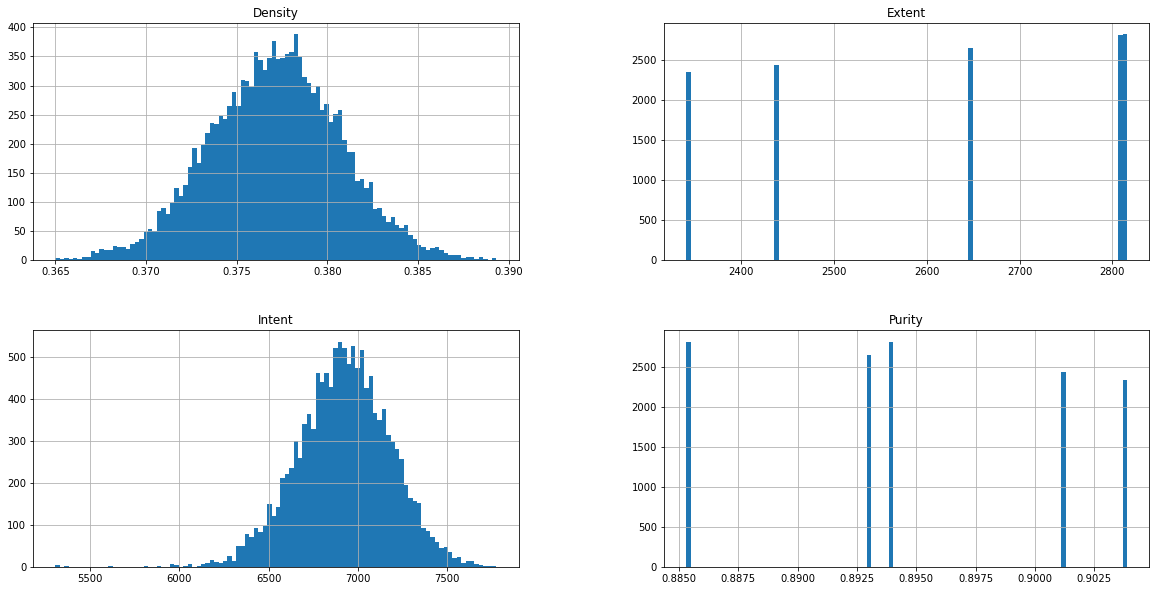

In [117]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (20,10))
ax = fig.gca()


df_Bs1.hist(ax = ax, bins=100)

In [172]:
Sel1=Selection(Bicl_stat1, 0.387, 1, 2000, 2900, 5000, 8000)

In [173]:
Sel1

[[0.3878756090519545, 2341, 7083, 0.9038872276804785],
 [0.3872205433528022, 2341, 6853, 0.9038872276804785],
 [0.38786414241563827, 2341, 6572, 0.9038872276804785],
 [0.3872391153584418, 2341, 6967, 0.9038872276804785],
 [0.387522829469631, 2816, 6894, 0.8852982954545454],
 [0.387946158566956, 2816, 7027, 0.8852982954545454],
 [0.38761647010403877, 2816, 6737, 0.8852982954545454],
 [0.389254177684429, 2816, 6790, 0.8852982954545454],
 [0.3870236983410958, 2810, 6996, 0.8939501779359431],
 [0.388543719415128, 2810, 6521, 0.8939501779359431],
 [0.3872737671581088, 2810, 6160, 0.8939501779359431],
 [0.38714791166154916, 2810, 6925, 0.8939501779359431],
 [0.38763502013540696, 2810, 6808, 0.8939501779359431],
 [0.3879073385392455, 2810, 7288, 0.8939501779359431],
 [0.3873720654362879, 2810, 6708, 0.8939501779359431],
 [0.3884123955181369, 2810, 6572, 0.8939501779359431],
 [0.3885886639266493, 2810, 6894, 0.8939501779359431],
 [0.3882447316831317, 2810, 7027, 0.8939501779359431],
 [0.387001

In [174]:
Sel1=SelectionD(dic1_full, 0.387, 1, 2000, 2900, 5000, 8000)

In [175]:
Sel1

{(1339, 22327): (0.3878756090519545, 2341, 7083, 0.9038872276804785),
 (2785, 22327): (0.3872205433528022, 2341, 6853, 0.9038872276804785),
 (3150, 22327): (0.38786414241563827, 2341, 6572, 0.9038872276804785),
 (5310, 22327): (0.3872391153584418, 2341, 6967, 0.9038872276804785),
 (3763, 22965): (0.387522829469631, 2816, 6894, 0.8852982954545454),
 (4088, 22965): (0.387946158566956, 2816, 7027, 0.8852982954545454),
 (4300, 22965): (0.38761647010403877, 2816, 6737, 0.8852982954545454),
 (5142, 22965): (0.389254177684429, 2816, 6790, 0.8852982954545454),
 (693, 24080): (0.3870236983410958, 2810, 6996, 0.8939501779359431),
 (915, 24080): (0.388543719415128, 2810, 6521, 0.8939501779359431),
 (937, 24080): (0.3872737671581088, 2810, 6160, 0.8939501779359431),
 (1372, 24080): (0.38714791166154916, 2810, 6925, 0.8939501779359431),
 (1936, 24080): (0.38763502013540696, 2810, 6808, 0.8939501779359431),
 (2041, 24080): (0.3879073385392455, 2810, 7288, 0.8939501779359431),
 (2710, 24080): (0.3873

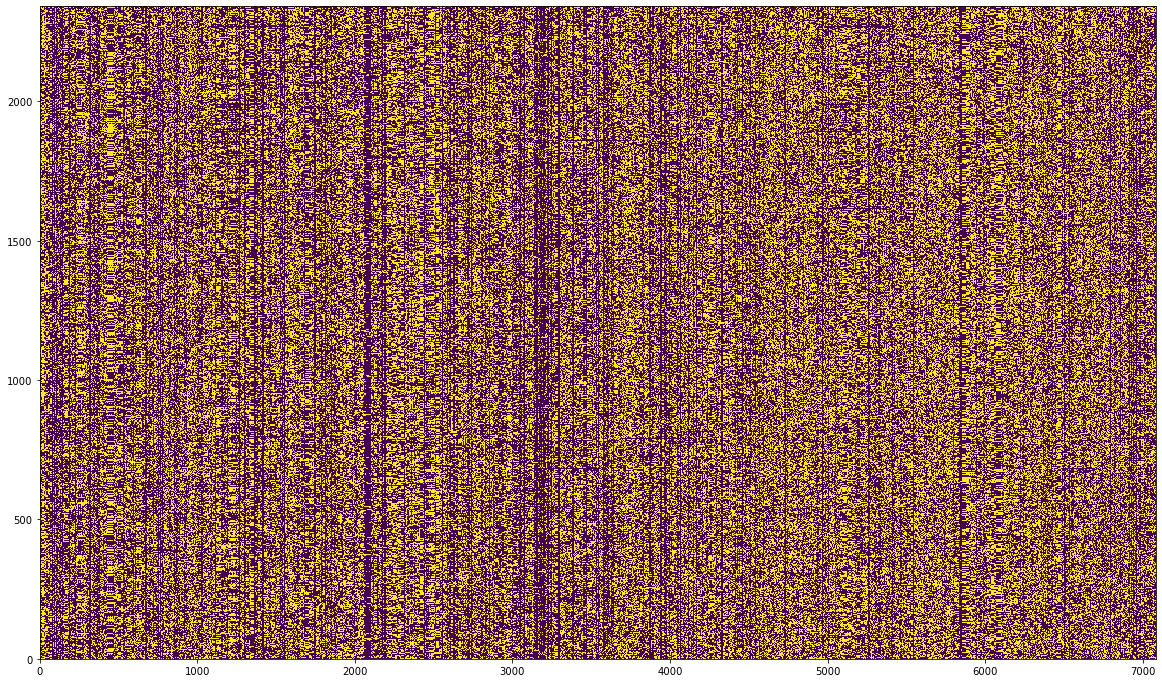

In [176]:
fig, ax = plt.subplots()

B=FindBic(Res1,(1339, 22327))

ax.pcolormesh(D1[B[0],:][:,B[1]])

fig.set_figwidth(20)    #  ширина и
fig.set_figheight(12)    #  высота "Figure"
#fig.set_facecolor('floralwhite')
#ax.set_facecolor('seashell')

plt.show()

In [177]:
SNPswithinBiclBySupp(B, D1)

{7: (1194, 0.5100384451089278),
 10: (120, 0.05126014523707817),
 14: (103, 0.043998291328492097),
 15: (942, 0.40239214011106367),
 16: (1200, 0.5126014523707817),
 18: (962, 0.4109354976505767),
 19: (963, 0.41136266552755235),
 20: (1022, 0.43656557026911574),
 21: (960, 0.41008116189662536),
 26: (960, 0.41008116189662536),
 27: (51, 0.021785561725758223),
 30: (991, 0.4233233660828706),
 37: (1119, 0.47800085433575396),
 39: (1186, 0.5066211020931226),
 41: (442, 0.18880820162323794),
 43: (1072, 0.4579239641178983),
 78: (266, 0.11362665527552328),
 85: (1290, 0.5510465612985903),
 87: (1273, 0.5437847073900043),
 88: (226, 0.09653994019649723),
 93: (1244, 0.5313968389577104),
 94: (1310, 0.5595899188381034),
 95: (1292, 0.5519008970525416),
 96: (1235, 0.5275523280649295),
 99: (1405, 0.6001708671507903),
 109: (201, 0.08586074327210594),
 114: (56, 0.02392140111063648),
 127: (764, 0.3263562580093977),
 132: (1147, 0.4899615548910722),
 138: (768, 0.3280649295173003),
 139: (1

In [183]:
SNPs=SNPswithinBiclBySupp(B, D1)

In [184]:
SNPs_sort=sorted([(SNPs[k][0],SNPs[k][1],k) for k in SNPs.keys()])
SNPs_sort.reverse()

In [185]:
SNPs_sort

[(2341, 1.0, 22327),
 (1459, 0.6232379325074754, 22324),
 (1405, 0.6001708671507903, 22331),
 (1405, 0.6001708671507903, 99),
 (1310, 0.5595899188381034, 94),
 (1292, 0.5519008970525416, 95),
 (1290, 0.5510465612985903, 22323),
 (1290, 0.5510465612985903, 85),
 (1273, 0.5437847073900043, 87),
 (1244, 0.5313968389577104, 93),
 (1243, 0.5309696710807348, 22325),
 (1242, 0.5305425032037591, 22866),
 (1235, 0.5275523280649295, 96),
 (1233, 0.5266979923109782, 22329),
 (1233, 0.5266979923109782, 19458),
 (1233, 0.5266979923109782, 19456),
 (1232, 0.5262708244340025, 31227),
 (1231, 0.5258436565570269, 19561),
 (1227, 0.5241349850491243, 26056),
 (1226, 0.5237078171721486, 20461),
 (1226, 0.5237078171721486, 18340),
 (1225, 0.523280649295173, 26726),
 (1225, 0.523280649295173, 22871),
 (1225, 0.523280649295173, 14356),
 (1225, 0.523280649295173, 14355),
 (1224, 0.5228534814181973, 19449),
 (1223, 0.5224263135412217, 22872),
 (1222, 0.5219991456642461, 23202),
 (1222, 0.5219991456642461, 1944

In [186]:
names=list(DF.columns)
SNPs_sort_rs=[(t[0],t[1],names[t[2]+2]) for t in SNPs_sort]

In [187]:
SNPs_sort_rs

[(2341, 1.0, 'rs9606478_G'),
 (1459, 0.6232379325074754, 'rs874836_A'),
 (1405, 0.6001708671507903, 'rs9606481_C'),
 (1405, 0.6001708671507903, 'chr22:17312790_T'),
 (1310, 0.5595899188381034, 'chr22:17306270_A'),
 (1292, 0.5519008970525416, 'chr22:17307742_A'),
 (1290, 0.5510465612985903, 'rs874835_G'),
 (1290, 0.5510465612985903, 'chr22:17294997_A'),
 (1273, 0.5437847073900043, 'chr22:17299033_C'),
 (1244, 0.5313968389577104, 'chr22:17304246_T'),
 (1243, 0.5309696710807348, 'rs5994031_T'),
 (1242, 0.5305425032037591, 'rs712958_C'),
 (1235, 0.5275523280649295, 'chr22:17309362_G'),
 (1233, 0.5266979923109782, 'rs175149_A'),
 (1233, 0.5266979923109782, 'chr22:48161783_G'),
 (1233, 0.5266979923109782, 'chr22:48158986_G'),
 (1232, 0.5262708244340025, 'rs130191_T'),
 (1231, 0.5258436565570269, 'chr22:48282309_C'),
 (1227, 0.5241349850491243, 'rs2240430_C'),
 (1226, 0.5237078171721486, 'chr22:49116883_C'),
 (1226, 0.5237078171721486, 'chr22:46902787_T'),
 (1225, 0.523280649295173, 'rs575459

In [188]:
SortedIntent=[t[2] for t in SNPs_sort]

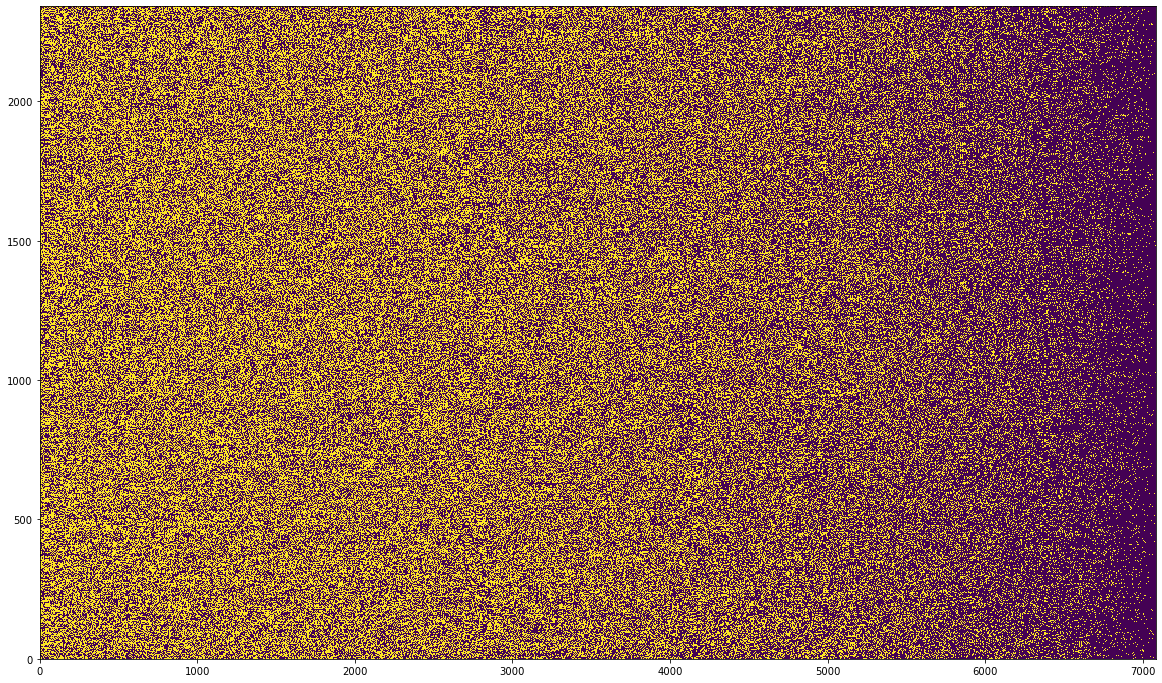

In [190]:
fig, ax = plt.subplots()

B=FindBic(Res1,(1339, 22327))

ax.pcolormesh(D1[B[0],:][:,SortedIntent])

fig.set_figwidth(20)    #  ширина и
fig.set_figheight(12)    #  высота "Figure"
#fig.set_facecolor('floralwhite')
#ax.set_facecolor('seashell')

plt.show()

In [191]:
#names=list(DF.columns)
for t in SNPs_sort_rs:
    for rs in RS:
        if rs in t[2]:
            print(t)

(2341, 1.0, 'rs9606478_G')
(1117, 0.4771465185818026, 'rs137425_A')
(1014, 0.43314822725331054, 'rs4823464_G')


### Biclustering with code value 2

In [50]:
%%time

dic_den2=biclDenLenArr(D2,Res2,range(len(Res2)))

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
CPU times: user 39min 21s, sys: 9min 58s, total: 49min 20s
Wall time: 49min 56s


In [92]:
%%time

dic_pur2=biclPurArr(Res2,Pos)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
CPU times: user 1h 33min 25s, sys: 40.4 s, total: 1h 34min 6s
Wall time: 1h 34min 12s


array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

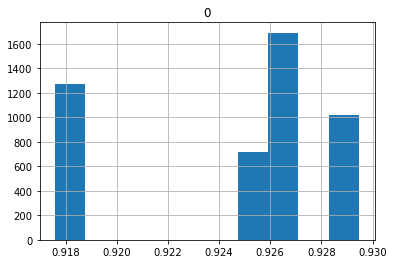

In [95]:
pd.DataFrame(dic_pur2.values()).hist()

In [49]:
%%time

dic_den2=biclDenLenArr(D2,Res2,[0])

0
CPU times: user 262 ms, sys: 73.3 ms, total: 335 ms
Wall time: 335 ms


In [67]:
list(dic_den2.values())[0]

(0.14835591645845345, 528, 1419)

In [68]:
list(dic_den2.keys())[0]

(6, 22327)

In [69]:
Res2[0]

(6,
 22327,
 [6,
  8,
  13,
  25,
  58,
  98,
  119,
  125,
  130,
  135,
  144,
  152,
  168,
  184,
  202,
  213,
  219,
  232,
  281,
  282,
  286,
  304,
  320,
  327,
  333,
  346,
  386,
  387,
  394,
  396,
  412,
  512,
  526,
  593,
  604,
  629,
  638,
  639,
  649,
  658,
  673,
  674,
  689,
  709,
  732,
  736,
  778,
  816,
  817,
  835,
  836,
  848,
  878,
  880,
  894,
  896,
  931,
  936,
  951,
  976,
  981,
  995,
  998,
  1025,
  1026,
  1032,
  1034,
  1056,
  1078,
  1084,
  1094,
  1098,
  1103,
  1110,
  1127,
  1131,
  1146,
  1149,
  1152,
  1161,
  1179,
  1188,
  1194,
  1206,
  1209,
  1213,
  1216,
  1223,
  1231,
  1241,
  1253,
  1259,
  1271,
  1280,
  1282,
  1285,
  1289,
  1291,
  1298,
  1332,
  1333,
  1347,
  1349,
  1353,
  1355,
  1374,
  1393,
  1405,
  1409,
  1432,
  1434,
  1435,
  1439,
  1442,
  1454,
  1464,
  1490,
  1507,
  1510,
  1523,
  1539,
  1546,
  1548,
  1574,
  1583,
  1592,
  1597,
  1603,
  1604,
  1613,
  1640,
  1641,
  1

In [119]:
dic2_full=biclDicGlue(dic_den2, dic_pur2)

In [120]:
import pandas as pd
Bicl_stat=[list(val) for val in dic2_full.values()]
df_Bs=pd.DataFrame(Bicl_stat,columns =['Density', 'Extent', 'Intent', 'Purity'])

In [40]:
A=[[1, 0, 0, 0],[0, 1, 1, 0],[0, 1, 0, 1],[0, 0, 0, 1]]

In [53]:
df_Bs.describe()

Density       Extent       Intent
count  4700.000000  4700.000000  4700.000000
mean      0.148941  1022.504255  1577.901702
std       0.005277   252.637993   130.632181
min       0.128722   528.000000  1160.000000
25%       0.145348   715.000000  1488.750000
50%       0.148971  1162.000000  1572.000000
75%       0.152521  1274.000000  1661.000000
max       0.167039  1274.000000  2316.000000

/var/folders/_3/lhn1ctt11sbb8sfyh3x9r3vm0000gq/T/ipykernel_8283/1773473993.py:7: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  df_Bs.hist(ax = ax, bins=100)


array([[<AxesSubplot:title={'center':'Density'}>,
        <AxesSubplot:title={'center':'Extent'}>],
       [<AxesSubplot:title={'center':'Intent'}>,
        <AxesSubplot:title={'center':'Purity'}>]], dtype=object)

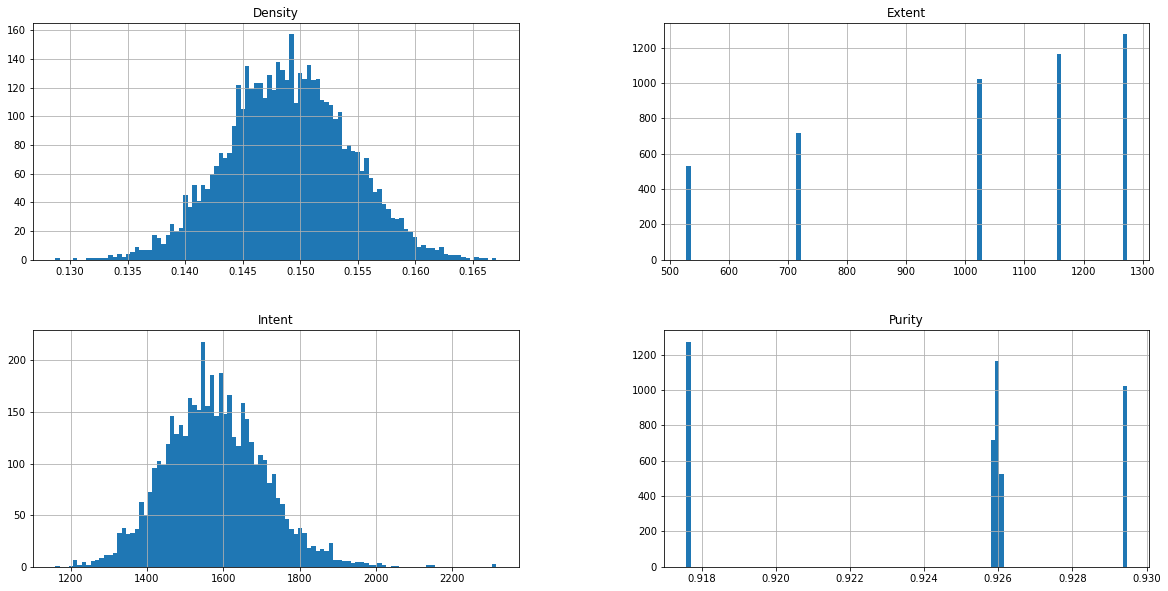

In [121]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (20,10))
ax = fig.gca()


df_Bs.hist(ax = ax, bins=100)

In [196]:
Sel2=Selection(Bicl_stat, 0.162, 1, 500, 1300, 1100, 2300)

In [197]:
Sel2

[[0.16237561745986512, 528, 1276, 0.9261363636363636],
 [0.16394171730847948, 1274, 1396, 0.9175824175824175],
 [0.1652802504757812, 1274, 1432, 0.9175824175824175],
 [0.16314009922225742, 1274, 1398, 0.9175824175824175],
 [0.16269439826311627, 1274, 1423, 0.9175824175824175],
 [0.16216454030644295, 1274, 1347, 0.9175824175824175],
 [0.16231090988827782, 1274, 1371, 0.9175824175824175],
 [0.1635684512531803, 1274, 1160, 0.9175824175824175],
 [0.1636479332955021, 1274, 1516, 0.9175824175824175],
 [0.1620180624204769, 1274, 1562, 0.9175824175824175],
 [0.16703876892728553, 1274, 1407, 0.9175824175824175],
 [0.16366486353577575, 1274, 1328, 0.9175824175824175],
 [0.16317747799601626, 1274, 1421, 0.9175824175824175],
 [0.16535710536970116, 1274, 1361, 0.9175824175824175],
 [0.1620000468614541, 1274, 1340, 0.9175824175824175],
 [0.16208595396050848, 1274, 1403, 0.9175824175824175],
 [0.16324155101636473, 1274, 1553, 0.9175824175824175],
 [0.16268658702072747, 1274, 1416, 0.9175824175824175]

In [198]:
Sel2=SelectionD(dic2_full,  0.162, 1, 500, 1300, 1100, 2300)

In [199]:
Sel2

{(3400, 22327): (0.16237561745986512, 528, 1276, 0.9261363636363636),
 (260, 24080): (0.16394171730847948, 1274, 1396, 0.9175824175824175),
 (444, 24080): (0.1652802504757812, 1274, 1432, 0.9175824175824175),
 (466, 24080): (0.16314009922225742, 1274, 1398, 0.9175824175824175),
 (513, 24080): (0.16269439826311627, 1274, 1423, 0.9175824175824175),
 (700, 24080): (0.16216454030644295, 1274, 1347, 0.9175824175824175),
 (727, 24080): (0.16231090988827782, 1274, 1371, 0.9175824175824175),
 (1013, 24080): (0.1635684512531803, 1274, 1160, 0.9175824175824175),
 (1020, 24080): (0.1636479332955021, 1274, 1516, 0.9175824175824175),
 (1386, 24080): (0.1620180624204769, 1274, 1562, 0.9175824175824175),
 (1428, 24080): (0.16703876892728553, 1274, 1407, 0.9175824175824175),
 (1548, 24080): (0.16366486353577575, 1274, 1328, 0.9175824175824175),
 (2007, 24080): (0.16317747799601626, 1274, 1421, 0.9175824175824175),
 (2093, 24080): (0.16535710536970116, 1274, 1361, 0.9175824175824175),
 (2785, 24080): (

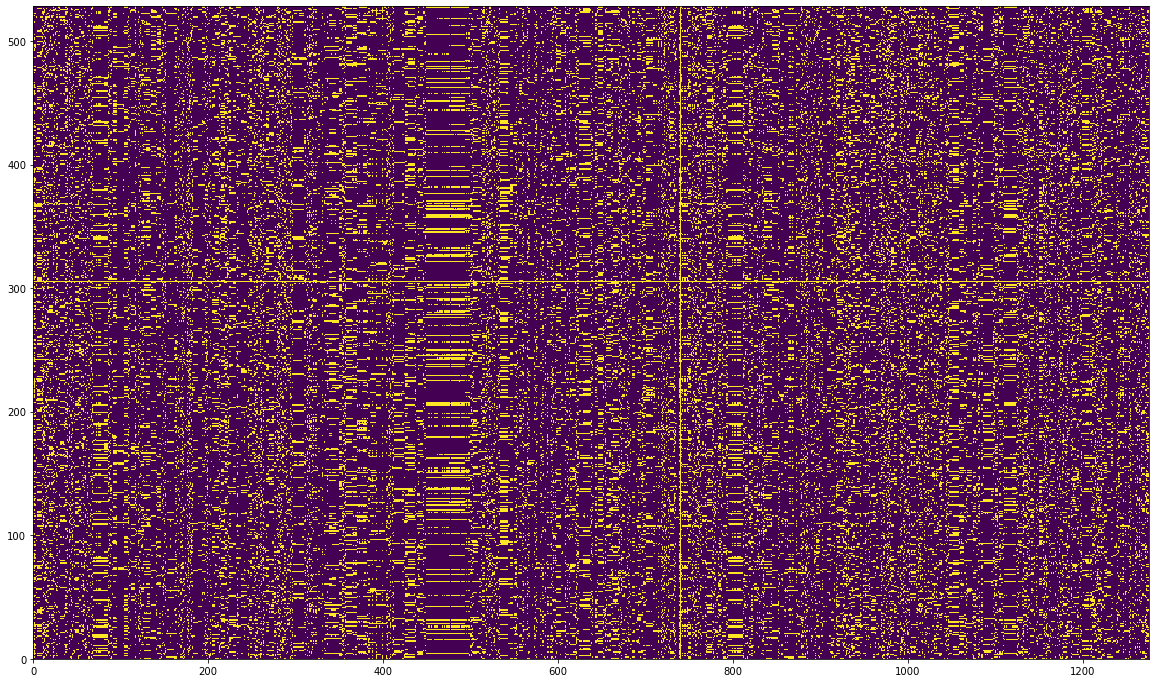

In [200]:
fig, ax = plt.subplots()

B=FindBic(Res2,(3400, 22327))

ax.pcolormesh(D2[B[0],:][:,B[1]])

fig.set_figwidth(20)    #  ширина и
fig.set_figheight(12)    #  высота "Figure"
#fig.set_facecolor('floralwhite')
#ax.set_facecolor('seashell')

plt.show()

In [201]:
SNPswithinBiclBySupp(B, D2)

{89: (160, 0.30303030303030304),
 96: (213, 0.4034090909090909),
 102: (88, 0.16666666666666666),
 212: (50, 0.0946969696969697),
 216: (121, 0.22916666666666666),
 230: (121, 0.22916666666666666),
 235: (121, 0.22916666666666666),
 240: (121, 0.22916666666666666),
 243: (116, 0.2196969696969697),
 244: (115, 0.2178030303030303),
 364: (128, 0.24242424242424243),
 365: (144, 0.2727272727272727),
 401: (124, 0.23484848484848486),
 465: (109, 0.20643939393939395),
 466: (99, 0.1875),
 617: (124, 0.23484848484848486),
 620: (100, 0.1893939393939394),
 621: (100, 0.1893939393939394),
 691: (97, 0.18371212121212122),
 694: (102, 0.19318181818181818),
 701: (97, 0.18371212121212122),
 706: (97, 0.18371212121212122),
 731: (76, 0.14393939393939395),
 750: (118, 0.22348484848484848),
 797: (77, 0.14583333333333334),
 826: (59, 0.11174242424242424),
 961: (121, 0.22916666666666666),
 975: (94, 0.17803030303030304),
 1002: (37, 0.07007575757575757),
 1007: (73, 0.13825757575757575),
 1018: (10, 

In [202]:
SNPs=SNPswithinBiclBySupp(B, D2)

In [203]:
SNPs_sort=sorted([(SNPs[k][0],SNPs[k][1],k) for k in SNPs.keys()])
SNPs_sort.reverse()

In [204]:
SNPs_sort

[(528, 1.0, 22327),
 (216, 0.4090909090909091, 22324),
 (213, 0.4034090909090909, 22329),
 (213, 0.4034090909090909, 96),
 (160, 0.30303030303030304, 89),
 (150, 0.2840909090909091, 16302),
 (149, 0.2821969696969697, 30932),
 (149, 0.2821969696969697, 29654),
 (149, 0.2821969696969697, 25398),
 (147, 0.2784090909090909, 26622),
 (147, 0.2784090909090909, 18340),
 (146, 0.2765151515151515, 22451),
 (145, 0.2746212121212121, 24688),
 (145, 0.2746212121212121, 22455),
 (144, 0.2727272727272727, 22452),
 (144, 0.2727272727272727, 16308),
 (144, 0.2727272727272727, 365),
 (143, 0.2708333333333333, 26369),
 (143, 0.2708333333333333, 18552),
 (143, 0.2708333333333333, 16275),
 (142, 0.2689393939393939, 27167),
 (142, 0.2689393939393939, 10100),
 (141, 0.26704545454545453, 29652),
 (141, 0.26704545454545453, 29651),
 (141, 0.26704545454545453, 24747),
 (141, 0.26704545454545453, 16288),
 (141, 0.26704545454545453, 16285),
 (141, 0.26704545454545453, 16284),
 (141, 0.26704545454545453, 16283),


In [205]:
names=list(DF.columns)
SNPs_sort_rs=[(t[0],t[1],names[t[2]+2]) for t in SNPs_sort]

In [206]:
SNPs_sort_rs

[(528, 1.0, 'rs9606478_G'),
 (216, 0.4090909090909091, 'rs874836_A'),
 (213, 0.4034090909090909, 'rs175149_A'),
 (213, 0.4034090909090909, 'chr22:17309362_G'),
 (160, 0.30303030303030304, 'chr22:17300320_A'),
 (150, 0.2840909090909091, 'chr22:44914354_A'),
 (149, 0.2821969696969697, 'rs133530_A'),
 (149, 0.2821969696969697, 'rs4823329_T'),
 (149, 0.2821969696969697, 'rs5752628_G'),
 (147, 0.2784090909090909, 'rs4420793_A'),
 (147, 0.2784090909090909, 'chr22:46902787_T'),
 (146, 0.2765151515151515, 'rs5747018_T'),
 (145, 0.2746212121212121, 'rs9613168_A'),
 (145, 0.2746212121212121, 'rs362129_G'),
 (144, 0.2727272727272727, 'rs17807317_A'),
 (144, 0.2727272727272727, 'chr22:44922761_A'),
 (144, 0.2727272727272727, 'chr22:17678128_G'),
 (143, 0.2708333333333333, 'rs3213515_C'),
 (143, 0.2708333333333333, 'chr22:47115756_G'),
 (143, 0.2708333333333333, 'chr22:44888063_A'),
 (142, 0.2689393939393939, 'rs5755492_C'),
 (142, 0.2689393939393939, 'chr22:35517686_A'),
 (141, 0.26704545454545453

In [207]:
SortedIntent=[t[2] for t in SNPs_sort]

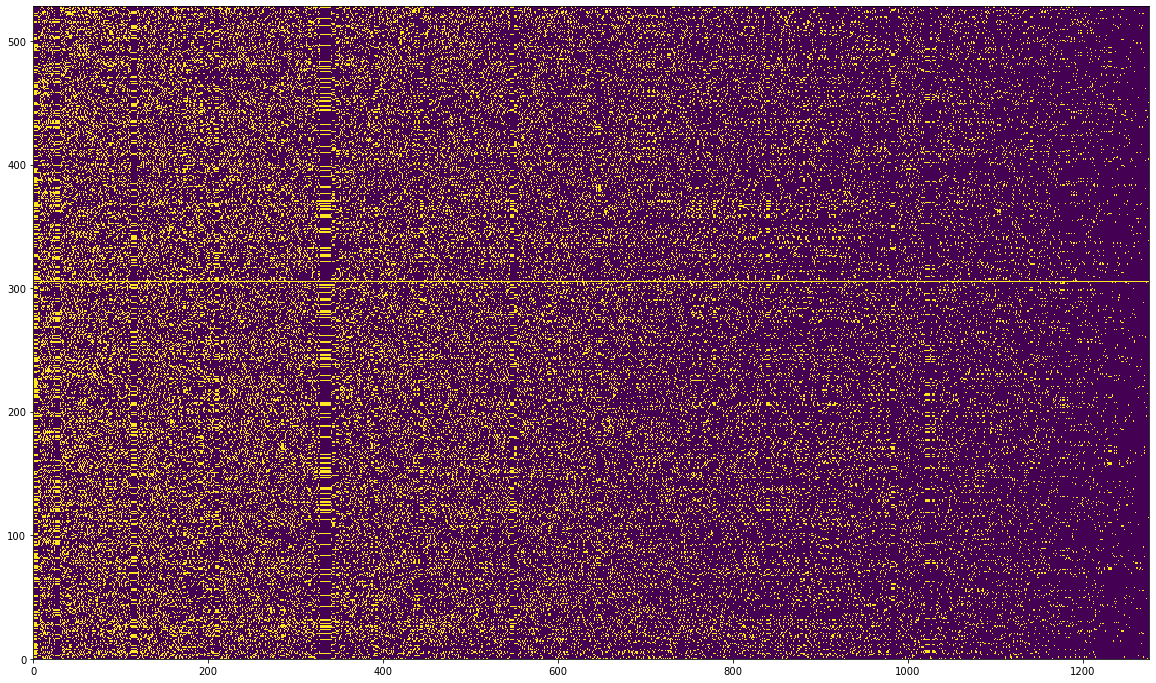

In [209]:
fig, ax = plt.subplots()

B=FindBic(Res2,(3400, 22327))

ax.pcolormesh(D2[B[0],:][:,SortedIntent])

fig.set_figwidth(20)    #  ширина и
fig.set_figheight(12)    #  высота "Figure"
#fig.set_facecolor('floralwhite')
#ax.set_facecolor('seashell')

plt.show()

In [210]:
#names=list(DF.columns)
for t in SNPs_sort_rs:
    for rs in RS:
        if rs in t[2]:
            print(t)

(528, 1.0, 'rs9606478_G')


In [45]:
OnlineOABic(A)

[(0, 0, [0], [0]),
 (1, 1, [1, 2], [1, 2]),
 (2, 1, [1, 2], [1, 3]),
 (1, 2, [1], [1, 2]),
 (2, 3, [2, 3], [1, 3]),
 (3, 3, [2, 3], [3])]

In [46]:
A=[[0, 1, 1, 1],[1, 0, 1, 1],[1, 1, 0, 1],[1, 1, 1, 0]]

In [47]:
OnlineOABic(A)

[(1, 0, [1, 2, 3], [0, 2, 3]),
 (2, 0, [1, 2, 3], [0, 1, 3]),
 (3, 0, [1, 2, 3], [0, 1, 2]),
 (0, 1, [0, 2, 3], [1, 2, 3]),
 (2, 1, [0, 2, 3], [0, 1, 3]),
 (3, 1, [0, 2, 3], [0, 1, 2]),
 (0, 2, [0, 1, 3], [1, 2, 3]),
 (1, 2, [0, 1, 3], [0, 2, 3]),
 (3, 2, [0, 1, 3], [0, 1, 2]),
 (0, 3, [0, 1, 2], [1, 2, 3]),
 (1, 3, [0, 1, 2], [0, 2, 3]),
 (2, 3, [0, 1, 2], [0, 1, 3])]